In [1]:
#Jump to: Maximizing/Matching CONTROL
 #or: Maximizing/Matching SOCIAL  

import csv
import pandas as pd
import numpy as np
import glob
import matplotlib
import scipy as sp
from matplotlib import pyplot as plt
from itertools import cycle, islice
from scipy import stats
from datetime import datetime

import seaborn as sns

-plot score for 50 and 20 intervals 


-removing 1st trials?
-RT
-questionnaire
-JSD for max/match
-win-stay, lose-switch

9/25
need to:

1. look into c07 (key error 399): need to code first 3 trials
2. compare 100, 200, 300 timestamps
4. write script to add probabilities to hand coded df 
5. work on reaction time analyses
    import timestamps from hand coded files 
7. hand code first 3 trials of c07 and add to analyses 

This notebook is for analyzing behavior data in the social multi-armed bandit (SMAB) paradigm.
It uses Pandas dataframes (https://pandas.pydata.org/docs/getting_started/index.html#getting-started).
The 's' datasets are single-player sessions from SMAB3 and the 'j' datasets are multi-player sessions from SMAB3.
The 'c' datasets are single-player sessions from SMAB4 and the 'm' datasets are multi-player sessions from SMAB4.

Updated by Bar Y. 8/4/20

In [2]:
'''
These functions import csv files into pandas dataframes and rename the columns.
input: filename of the csv file to import; the path needs to be included, as well
output: pandas dataframe

There are multiple iterations of this function because the data is in slightly different formats. 
'''


def organize_trial_by_trial(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward", 6:"time", 7:"P1 score", 8:"P2 score"})
    #drops first 20 trials of game 1
    #remove if you want to analyze the whole session
    #df = df[40:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    #df = df.drop(['reward'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df



#0 means "next" button
#need to exclude zero?

def organize_trial_by_trial_floatclick(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"type", 1:"game number", 2:"trial", 3:"player", 4:"arm", 5:"probability", 6:"P1 score", 7:"P2 score", 8:""})
    #have 402 so need to restrict
    #df = df[1:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    df = df.drop(['type'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df



def organize_trial_by_trial_300(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"type", 1:"game number", 2:"trial", 3:"player", 4:"arm", 5:"probability", 6:"reward", 7:"time", 8:"P1 score", 9:"P2 score"})
    #df = df[40:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    #df = df.drop(['type', 'reward'], axis=1)
    df = df.drop(['type'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df

#used before changes were made to template
def organize_trial_by_trial_hand_code(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    #remove first row with column headings
    df = df.drop(df.index[0])
    #convert values to numbers (NEED TO FIX)
    df.reset_index(drop=True,inplace=True)
    df = df.drop(range(0, 8))
    df.reset_index(drop=True,inplace=True)
    #df = df.apply(pd.to_numeric)
    #add column headings
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward",6:"time",7:"P1 score", 8:"P2 score"})
    df.head()
    
    return df

#use this function for hand coded game data files 
def organize_trial_by_trial_hand_code2(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    #remove first row with column headings
    df = df.drop(df.index[0])
    #convert values to numbers (NEED TO FIX)
    df.reset_index(drop=True,inplace=True)
    df = df.drop(range(0, 8))
    df.reset_index(drop=True,inplace=True)
    #drop comment columns
    #df = df.drop(range(7,9), axis = 1)
    #add p1 and p2 score columns
    df.insert
    #add column headings
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward",6:"time",7:"comment 1", 8:"comment 2", 9:"P1 score", 10:"P2 score"})
    
    #remove the time and comment columns (we'll add them back in a moment)
    #we are removing them bc we are converting all the values to numbeic and this can't be done to these columns
    time = df['time']
    df = df.drop('time', axis = 1 )
    
    comment_1 = df['comment 1']
    comment_2 = df['comment 2']
    df = df.drop('comment 1', axis = 1 )
    df = df.drop('comment 2', axis = 1 )
    
    df = df.apply(pd.to_numeric)
    
    #add dropped columns back in
    df['time'] = time
    df['comment 1'] = comment_1
    df['comment 2'] = comment_2
    
    #convert time and comment 1 to date time objects
    df['time']= pd.to_datetime(df['time'], errors = 'coerce', format = '%M:%S.%f')
    df['comment 1']= pd.to_datetime(df['comment 1'], errors = 'coerce', format = '%M:%S.%f')

    df.head()
    
    return df

In [3]:
'''
This function returns the score for game 1 and game 2. call_get_score can be used to call this function.
'''
def get_score(df, player_number, game_number):
    if game_number == 1:
        row = 199
    elif game_number == 2:
        row = 399
    if player_number == 1:
        column = 'P1 score'
    elif player_number == 2:
        column = 'P2 score'
    score = df.loc[row, column]
    return score

'''Here we get the score at trial 50 of both games'''
def get_score_at_50(df, player_number, game_number):
    if game_number == 1:
        row = 99
    elif game_number == 2:
        row = 300
    if player_number == 1:
        column = 'P1 score'
    elif player_number == 2:
        column = 'P2 score'
    score = df.loc[row, column]
    return score

In [4]:
#create a dataframes for scores
scores = pd.DataFrame(columns=['s_g1','s_g2','c_g1','c_g2', 'j_g1', 'j_g2', 'm_g1', 'm_g2'])

'''This function calls get_score.
input: dataframe with game data and version*
output: scores for each player and each game**
*version is 's' for single player SMAB3, 'c' for single player SMAB4, 'j' for multiplayer SMAB3, 
'm' for multiplayer SMAB4
**only 1 player score is outputted for each game in the single player sessions, while scores for both players are 
outputted for multiplayer sessions'''
def call_get_score(df, version):
    p1_g1 = get_score(df, 1, 1)
    p1_g2 = get_score(df, 1, 2)
    p1_score_diff = p1_g2 - p1_g1
    
    p1_g1_50 = get_score_at_50(df, 1, 1)
    p1_g2_50 = get_score_at_50(df, 1, 2)
    
    if version == 'j' or version == 'm':
        p1_g1 = get_score(df, 1, 1)
        p1_g2 = get_score(df, 1, 2)
        p1_score_diff = p1_g2 - p1_g1
        
        p1_g1_50 = get_score_at_50(df, 1, 1)
        p1_g2_50 = get_score_at_50(df, 1, 2)
        
        p2_g1 = get_score(df, 2, 1)
        p2_g2 = get_score(df, 2, 2)
        p2_score_diff = p2_g2 - p2_g1
        
        p2_g1_50 = get_score_at_50(df, 2, 1)
        p2_g2_50 = get_score_at_50(df, 2, 2)
        return p1_g1, p1_g2, p2_g1, p2_g2, p1_score_diff, p2_score_diff, p1_g1_50,p1_g2_50, p2_g1_50, p2_g2_50

    return p1_g1, p1_g2, p1_score_diff, p1_g1_50, p1_g2_50

In [5]:
'''This functions separates the dataframes by player and game.
input: dataframe with gamedata and version*
output: four dataframes separated by player and game
*same as call_get_score above'''
def separate_df(df, version):
    df_p1 = df[df['player'] == 1]
    df_p1_g1 = df_p1[df['game number'] == 1]
    df_p1_g2 = df_p1[df['game number'] == 2]
    
    #remove trials for g1
    #df_p1_g1 = df_p1_g1[20:40]
    #remove trials for g2
    #df_p1_g2 = df_p1_g2[20:40]
    
    if version == 's':
        return df_p1_g1, df_p1_g2
    if version == 'c':
        return df_p1_g1, df_p1_g2
    df_p2 = df[df['player'] ==2 ]
    df_p2_g1 = df_p2[df['game number'] == 1]
    df_p2_g2 = df_p2[df['game number'] == 2]
    
    #remove trials for g1
   # df_p2_g1 = df_p2_g1[20:40]
    #remove trials for g2
    #df_p2_g2= df_p2_g2[20:40]
    
    return df_p1_g1, df_p1_g2, df_p2_g1, df_p2_g2

In [6]:
#ignore for now
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [7]:
'''This function separates reaction times into post-win and post-loss arrays.
NOTE that it is intended to be called with dataframes separated by separate_df (ex. s01_p1_g1)'''
def reaction_time(df, time):
    df.reset_index(drop=True, inplace=True)
    post_win_time = []
    post_loss_time = []
    for index, row in df.iterrows():
        if index > 0 and index < 101:
            prev_rew = df.loc[index - 1, 'reward']
            if prev_rew == 1:
                post_win_time.append(df.loc[index, 'time'])
            elif prev_rew == 0:
                post_loss_time.append(df.loc[index, 'time'])
    post_win_mean = np.mean(post_win_time)
    post_loss_mean = np.mean(post_loss_time)
    name = str(get_df_name(df))
    time = time.append({'session' : name , 'post win' : post_win_mean, 'post loss': post_loss_mean} , ignore_index=True)
    return(time)

In [8]:
'''This functionfixes the reward column in the files imported using the '300' function. 
This function works for dataframes that have already been split up by game and player by separate_df (ex. c12_p1_g1)
NOTE that this function had to be written for a subset of the data that had a bug that caused the reward column to be
0 for all trials.'''
def fix_reward(df):
    df.reset_index(drop=True, inplace=True)
    for index, row in df.iterrows():
        if df.loc[index, 'player'] == 1:
                score_column = 'P1 score'
        elif df.loc[index, 'player'] == 2:
                score_column = 'P2 score'
        if index == 0:
            if df.loc[index, score_column] == 1:
                df.loc[index, 'reward'] = 1
            #not necessary here because the values are all 0
            else:
                df.loc[index, 'reward'] = 0
        elif index > 0:
            prev_score = df.loc[index - 1, score_column]
            curr_score = df.loc[index, score_column]
            score_diff = curr_score - prev_score
            df.loc[index, 'reward'] = score_diff
    return(df)

In [9]:
'''This function outputs the hole-probability mappings in each game. 
input: df of session data
output: df with the hole-probability mappings
g = game
p = player
h = hole
r = reward (1 means yes and 0 means no)
'''

def hole_prob_map(df):
    h1_prob = df.loc[df['arm'] == 1, 'probability'].iloc[0]
    h2_prob = df.loc[df['arm'] == 2, 'probability'].iloc[0]
    h3_prob = df.loc[df['arm'] == 3, 'probability'].iloc[0]
    h_probs = pd.DataFrame({'h1_prob': [h1_prob], 'h2_prob': [h2_prob], 'h3_prob': [h3_prob]})
    
    return h_probs


In [10]:
'''Here we compare the choice distributions to idealized models of two decision-making strategies: 
matching and maximizing. Matching would be choosing each each hole proportionally to its reward rate, 
and maximizing would be always choosing the high reward hole.'''

#JSD: Jensen Shannon Divergence. Measures the similarity between two probability distributions. Taken from 
#https://urldefense.com/v3/__https://gist.github.com/zhiyzuo/f80e2b1cfb493a5711330d271a228a3d__;!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX94Xg7JRI$ . *Note: probability distributions need to be
#normalized.'''
#parameters: p and q are the two probability distributions to be compared.

def jsd(p, q, base=np.e):
    
    
    #Implementation of pairwise `jsd` based on https://urldefense.com/v3/__https://en.wikipedia.org/wiki/Jensen**BShannon_divergence__;4oCT!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX9SSBIvMc$ 
    # convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    # normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.



#Idealized probability distributions to use for comparison. You can change these or add more models.

maximize = [0,0,100]
match = [30/180 * 100,60/180 * 100,90/180 * 100]
random = [30/90 * 100,30/90 * 100,30/90 * 100]
social = [1/3 * 100,1/3 * 100, 1/3 * 100]


#This function calls jsd. 
#Input: counts- a player's choice distributions in a particular game (ex. s01_p1_g1_counts)
#Output: maxi- JSD score for the maximizing strategy
        #matchi- JSD score for the matching strategy
def call_jsd(counts):
    maxi = jsd(counts,maximize) #(p, q)
    matchi = jsd(counts,match)
    randi = jsd(counts,random)
    soci = jsd(counts,social)
    return maxi,matchi,randi, soci

# Hand Coding Functions
These functions can be used for game data files that were created by hand coding.

In [11]:
'''This function calculates the number of times each hole was chosen and the 
probability with which each hole rewarded each player in each game.
input: hand coded game data file in a df
output: df with the number of times each hole was chosen by each player in each game and the percentage of choices that were
rewarded
g = game
p = player
h = hole
r = reward (1 means yes and 0 means no)'''

def handcode_calc_prob(df):
    
    #NOTE: turn into function with parameters for game and player
    #get counts for g1, p1
    g1_p1_h1_r1_count,g1_p1_h1_r0_count,g1_p1_h2_r1_count,g1_p1_h2_r0_count,g1_p1_h3_r1_count,g1_p1_h3_r0_count = get_count(df, 1,1)
    
    g1_p2_h1_r1_count,g1_p2_h1_r0_count,g1_p2_h2_r1_count,g1_p2_h2_r0_count,g1_p2_h3_r1_count,g1_p2_h3_r0_count = get_count(df, 2,1)
    
    g2_p1_h1_r1_count,g2_p1_h1_r0_count,g2_p1_h2_r1_count,g2_p1_h2_r0_count,g2_p1_h3_r1_count,g2_p1_h3_r0_count = get_count(df, 1,2)
    
    g2_p2_h1_r1_count,g2_p2_h1_r0_count,g2_p2_h2_r1_count,g2_p2_h2_r0_count,g2_p2_h3_r1_count,g2_p2_h3_r0_count = get_count(df, 2,2)
    
    #calculate reward rate of each hole in each condition
    
    g1_p1_h1 = calc_prob(g1_p1_h1_r1_count,g1_p1_h1_r0_count)
    g1_p1_h2 = calc_prob(g1_p1_h2_r1_count,g1_p1_h2_r0_count)
    g1_p1_h3 = calc_prob(g1_p1_h3_r1_count,g1_p1_h3_r0_count)
    
    g1_p2_h1 = calc_prob(g1_p2_h1_r1_count,g1_p2_h1_r0_count)
    g1_p2_h2 = calc_prob(g1_p2_h2_r1_count,g1_p2_h2_r0_count)
    g1_p2_h3 = calc_prob(g1_p2_h3_r1_count,g1_p2_h3_r0_count)
    
    g2_p1_h1 = calc_prob(g2_p1_h1_r1_count,g2_p1_h1_r0_count)
    g2_p1_h2 = calc_prob(g2_p1_h2_r1_count,g2_p1_h2_r0_count)
    g2_p1_h3 = calc_prob(g2_p1_h3_r1_count,g2_p1_h3_r0_count)
    
    g2_p2_h1 = calc_prob(g2_p2_h1_r1_count,g2_p2_h1_r0_count)
    g2_p2_h2 = calc_prob(g2_p2_h2_r1_count,g2_p2_h2_r0_count)
    g2_p2_h3 = calc_prob(g2_p2_h3_r1_count,g2_p2_h3_r0_count)
    
    
    #NEED to add indices to these
    p1_counts_d = {'g1_p1_h1_count': [g1_p1_h1_r1_count, g1_p1_h1_r0_count], 'g1_p1_h2_count': [g1_p1_h2_r1_count, g1_p1_h2_r0_count],
        'g1_p1_h3_count': [g1_p1_h3_r1_count, g1_p1_h3_r0_count], 'g2_p1_h1_count': [g2_p1_h1_r1_count, g2_p1_h1_r0_count], 
         'g2_p1_h2_count': [g2_p1_h2_r1_count, g2_p1_h2_r0_count],
        'g2_p1_h3_count': [g2_p1_h3_r1_count, g2_p1_h3_r0_count] }
    p1_counts_df = pd.DataFrame(p1_counts_d)
    
    p2_counts_d = {'g1_p2_h1_count': [g1_p2_h1_r1_count, g1_p2_h1_r0_count], 'g1_p2_h2_count': [g1_p2_h2_r1_count, g1_p2_h2_r0_count],
        'g1_p2_h3_count': [g1_p2_h3_r1_count, g1_p2_h3_r0_count], 'g2_p2_h1_count': [g2_p2_h1_r1_count, g2_p2_h1_r0_count], 
         'g2_p2_h2_count': [g2_p2_h2_r1_count, g2_p2_h2_r0_count],
        'g2_p2_h3_count': [g2_p2_h3_r1_count, g2_p2_h3_r0_count] }
    p2_counts_df = pd.DataFrame(p2_counts_d)
    
    p1_counts_df.index = ['rewarded', 'non-rewarded']
    p2_counts_df.index = ['rewarded','non-rewarded']
    
    p1_probs_d = {'p1_h1':[g1_p1_h1, g2_p1_h1], 'p1_h2':[g1_p1_h2, g2_p1_h2], 'p1_h3':[g1_p1_h3, g2_p1_h3]}
    p1_probs_df = pd.DataFrame(p1_probs_d)
    
    p2_probs_d = {'p2_h1':[g1_p2_h1, g2_p2_h1], 'p1_h2':[g1_p2_h2, g2_p2_h2], 'p1_h3':[g1_p2_h3, g2_p2_h3]}
    p2_probs_df = pd.DataFrame(p2_probs_d)
    
    p1_probs_df.index = ['game 1', 'game 2'] 
    p2_probs_df.index = ['game 1','game 2']
    
    return p1_counts_df, p2_counts_df, p1_probs_df, p2_probs_df


In [12]:
'''This function is called in handcode_calc_prob and calculates the number of times each hole was chosen and rewarded/not rewarded
input: df, player and game numbers
output: counts for each hole and outcome (rewarded/not rewarded)
'''
def get_count(df,player,game):
    h1_r1_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==1) & (df['reward']==1)])
    h1_r0_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==1) & (df['reward']==0)])
    h2_r1_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==2) & (df['reward']==1)])
    h2_r0_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==2) & (df['reward']==0)])
    h3_r1_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==3) & (df['reward']==1)])
    h3_r0_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==3) & (df['reward']==0)])
    return h1_r1_count, h1_r0_count, h2_r1_count, h2_r0_count, h3_r1_count, h2_r0_count

In [13]:
'''This function is called in handcode_calc_prob and calculates the reward probability of a hole.
input: number of rewarded trials, number of un-rewarded trials
output: percentage of rewarded trials for that hole'''
def calc_prob(r1,r0):
    try:
        return (r1/(r1+r0) * 100)
    #if the hole was never chosen and the denominator is 0
    except ZeroDivisionError:
        return 0

In [14]:
'''This function fills in the dataframe with the probabilities (30, 60, or 90) to each hole for each player in each
game.
input: dataframe with gamedata, probabilities for each player/game number/hole*
output: dataframe with the probabilities filled in
*You must put the inputs in the correct order as defined in the parameters of the function.
'''
def fill_in_prob(df, p1_g1_h1, p1_g1_h2, p1_g1_h3, p1_g2_h1, p1_g2_h2, p1_g2_h3, p2_g1_h1, p2_g1_h2, p2_g1_h3, 
                 p2_g2_h1, p2_g2_h2, p2_g2_h3):
    for index, row in df.iterrows():
        if df.loc[index,'game number'] == 1:
            if df.loc[index,'player'] == 1:
                if df.loc[index,'arm'] == 1:
                    df.loc[index,'probability'] = p1_g1_h1
                elif df.loc[index,'arm'] == 2:
                    df.loc[index,'probability'] = p1_g1_h2
                elif df.loc[index,'arm'] == 3:
                    df.loc[index,'probability'] = p1_g1_h3
            elif df.loc[index,'player'] == 2:
                if df.loc[index,'arm'] == 1:
                    df.loc[index,'probability'] = p2_g1_h1
                elif df.loc[index,'arm'] == 2:
                    df.loc[index,'probability'] = p2_g1_h2
                elif df.loc[index,'arm'] == 3:
                    df.loc[index,'probability'] = p2_g1_h3
        elif df.loc[index,'game number'] == 2:
            if df.loc[index,'player'] == 1:
                if df.loc[index,'arm'] == 1:
                    df.loc[index,'probability'] = p1_g2_h1
                elif df.loc[index,'arm'] == 2:
                    df.loc[index,'probability'] = p1_g2_h2
                elif df.loc[index,'arm'] == 3:
                    df.loc[index,'probability'] = p1_g2_h3
            elif df.loc[index,'player'] == 2:
                if df.loc[index,'arm'] == 1:
                    df.loc[index,'probability'] = p2_g2_h1
                elif df.loc[index,'arm'] == 2:
                    df.loc[index,'probability'] = p2_g2_h2
                elif df.loc[index,'arm'] == 3:
                    df.loc[index,'probability'] = p2_g2_h3
    return df

# SMAB3 Single Player Analysis

In [15]:
'''
Here, we load all of the csv files into pandas dataframes using organize_trial_by_trial and get the game 1 and 2 scores using 
call_get_score.'''

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s01_gamedata.csv')
s01 = df
s01_p1_g1_score,s01_p1_g2_score,s01_score_diff,s01_p1_g1_50,s01_p1_g2_50 = call_get_score(s01, 's')
s01.head()

''''#in the s files, p2 is the confederate- NEED TO WORK ON
df = organize_trial_by_trial('data/s02_gamedata.csv')
s02 = df
s02_p1_g1_score = get_score(s02, 1, 1)
s02_p1_g1_score,s02_p1_g2_score,s02_score_diff,s02_p1_g1_50,s02_p1_g2_50 = call_get_score(s02, 's')
s02.head()'''


#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s03_gamedata.csv')
s03 = df
s03_p1_g1_score,s03_p1_g2_score,s03_score_diff,s03_p1_g1_50,s03_p1_g2_50 = call_get_score(s03, 's')
s03.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s05_gamedata.csv')
s05 = df
s05_p1_g1_score,s05_p1_g2_score,s05_score_diff, s05_p1_g1_50,s05_p1_g2_50 = call_get_score(s05, 's')
s05.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s06_gamedata.csv')
s06 = df
s06_p1_g1_score,s06_p1_g2_score,s06_score_diff, s06_p1_g1_50,s06_p1_g2_50 = call_get_score(s06, 's')
s06.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s07_gamedata.csv')
s07 = df
s07_p1_g1_score,s07_p1_g2_score,s07_score_diff, s07_p1_g1_50,s07_p1_g2_50 = call_get_score(s07, 's')
s07.head()

pd.set_option('display.max_columns', None)  

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s08_gamedata.csv')
s08 = df
s08_p1_g1_score,s08_p1_g2_score,s08_score_diff, s08_p1_g1_50,s08_p1_g2_50 = call_get_score(s08, 's')
s08.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s09_gamedata.csv')
s09 = df
s09_p1_g1_score,s09_p1_g2_score,s09_score_diff, s09_p1_g1_50,s09_p1_g2_50 = call_get_score(s09, 's')
s09.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s11_gamedata2.csv')
s11 = df
s11_p1_g1_score,s11_p1_g2_score,s11_score_diff,s11_p1_g1_50,s11_p1_g2_50 = call_get_score(s11, 's')
s11.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s12_gamedata.csv')
s12 = df
s12_p1_g1_score,s12_p1_g2_score,s12_score_diff, s12_p1_g1_50,s12_p1_g2_50 = call_get_score(s12, 's')
s12.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_hand_code2('data/s14_gamedata_handcode.csv')
s14 = df
#s12_p1_g1_score,s12_p1_g2_score,s12_score_diff, s12_p1_g1_50,s12_p1_g2_50 = call_get_score(s12, 's')
s14.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s15_gamedata2.csv')
s15 = df
s15_p1_g1_score,s15_p1_g2_score,s15_score_diff,s15_p1_g1_50,s15_p1_g2_50 = call_get_score(s15, 's')
s15.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s16_gamedata2.csv')
s16 = df
s16_p1_g1_score,s16_p1_g2_score,s16_score_diff,s16_p1_g1_50,s16_p1_g2_50 = call_get_score(s16, 's')
s16.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s19_gamedata.csv')
s19 = df
s19_p1_g1_score,s19_p1_g2_score,s19_score_diff,s19_p1_g1_50,s19_p1_g2_50 = call_get_score(s19, 's')
s19.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s17_gamedata2.csv')
s17 = df
s17_p1_g1_score,s17_p1_g2_score,s17_score_diff,s17_p1_g1_50,s17_p1_g2_50 = call_get_score(s17, 's')
s17.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s20_gamedata.csv')
s20 = df
s20_p1_g1_score,s20_p1_g2_score,s20_score_diff, s20_p1_g1_50,s20_p1_g2_50= call_get_score(s20, 's')
s20.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,1,90,0,0
1,1,1,2,0,90,1,0
2,1,2,1,2,60,1,1
3,1,2,2,0,90,2,1
4,1,3,1,3,30,2,2


In [16]:
s14

,game number,trial,player,arm,probability,reward,time,comment 1,comment 2
0,1,1,1,2.0,NaN,0.0,1900-01-01 00:08:05.158,NaT,
1,1,2,2,NaN,NaN,NaN,NaT,NaT,
2,1,3,1,2.0,NaN,1.0,1900-01-01 00:08:11.966,NaT,
3,1,4,2,NaN,NaN,NaN,NaT,NaT,
4,1,5,1,2.0,NaN,1.0,1900-01-01 00:08:17.495,NaT,
...,...,...,...,...,...,...,...,...,...
395,2,196,2,NaN,NaN,NaN,NaT,NaT,
396,2,197,1,2.0,NaN,1.0,1900-01-01 00:21:03.108,NaT,
397,2,198,2,NaN,NaN,NaN,NaT,NaT,
398,2,199,1,2.0,NaN,1.0,1900-01-01 00:21:07.732,1900-01-01 00:21:08.972,


In [17]:
s14_p1_counts, s14_p2_counts, s14_p1_probs, s14_p2_probs = handcode_calc_prob(s14)

In [18]:
s14_p1_probs

,p1_h1,p1_h2,p1_h3
game 1,0.0,88.659794,0.0
game 2,0.0,87.755102,0.0


In [19]:
'''The Hand Code Functions are called for s14'''
s14 = fill_in_prob(s14, 60,90,30,60,90,30,60,90,30,60,90,30)
s14_p1_g1, s14_p1_g2 = separate_df(s14, 'c')
s14_p1_g1_score = s14_p1_g1['reward'].sum()
s14_p1_g2_score = s14_p1_g2['reward'].sum()

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [20]:
'''
Here, we create a dataframe of all of the scores and score differences between game 1 and 2'''

#list out all the scores in game 1 by participant
s_scores_1 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's14','s15', 's16', 's17', 's19', 's20'], 'score':
     [s01_p1_g1_score, s03_p1_g1_score, s05_p1_g1_score,
      s06_p1_g1_score, s07_p1_g1_score, s08_p1_g1_score, s09_p1_g1_score, s11_p1_g1_score, s12_p1_g1_score, s14_p1_g1_score, s15_p1_g1_score, s16_p1_g1_score, s17_p1_g1_score, s19_p1_g1_score, s20_p1_g1_score]})
#to prevent an extra column that numbers each row:
s_scores_1.set_index('participant', inplace=True, drop=True)

#game 2 data is split by same (s) and different (d) contingencies in g1 and g2
#list out all the scores in game 2 by participant
s_scores_2_d = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09',], 'score':
    [s01_p1_g2_score, s03_p1_g2_score, s05_p1_g2_score, 
s06_p1_g2_score, s07_p1_g2_score, s08_p1_g2_score, s09_p1_g2_score]})

#to prevent an extra column that numbers each row:
s_scores_2_d.set_index('participant', inplace=True, drop=True)

s_scores_2_s = pd.DataFrame({'participant':['s11', 's12', 's14','s15', 's16', 's17', 's19', 's20'], 'score':
    [s11_p1_g2_score, s12_p1_g2_score, s14_p1_g2_score, s15_p1_g2_score, s16_p1_g2_score, s17_p1_g2_score, s19_p1_g2_score, s20_p1_g2_score]})

#to prevent an extra column that numbers each row:
s_scores_2_s.set_index('participant', inplace=True, drop=True)


#list out all the scores in game 1 by participant
s_scores_1_50 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_1_50':
     [s01_p1_g1_50, s03_p1_g1_50, s05_p1_g1_50,
      s06_p1_g1_50, s07_p1_g1_50, s08_p1_g1_50, s09_p1_g1_50, s11_p1_g1_50, s12_p1_g1_50, s15_p1_g1_50, s16_p1_g1_50, s17_p1_g1_50, s19_p1_g1_50, s20_p1_g1_50]})
#to prevent an extra column that numbers each row:
s_scores_1_50.set_index('participant', inplace=True, drop=True)

#list out all the scores in game 2 by participant
s_scores_2_50 = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_2_50':
    [s01_p1_g2_50, s03_p1_g2_50, s05_p1_g2_50, 
s06_p1_g2_50, s07_p1_g2_50, s08_p1_g2_50, s09_p1_g2_50, s11_p1_g2_50, s12_p1_g2_50, s15_p1_g2_50, s16_p1_g2_50, s17_p1_g2_50, s19_p1_g2_50, s20_p1_g2_50]})
s_scores_2_50.set_index('participant', inplace=True, drop=True)

#frames = [s_scores_1_50,s_scores_2_50,s_scores_1,s_scores_2]'''

"\n#merge both games by participant:\ns_scores = pd.merge(s_scores_1, s_scores_2,on='participant')\n\n#label columns\ns_scores.columns=['Game 1','Game 2']\n\ns_scores"

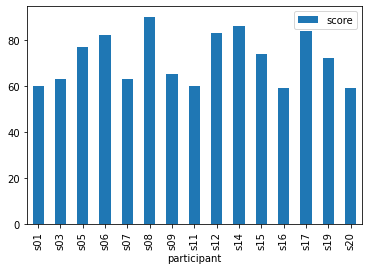

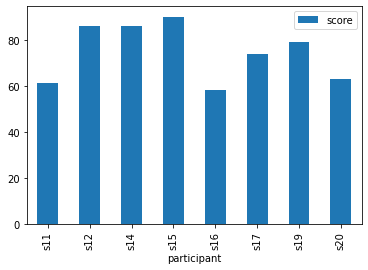

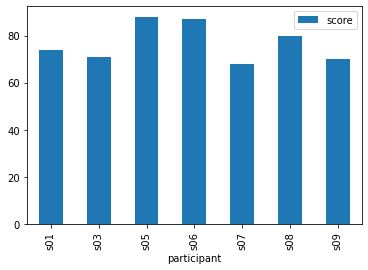

In [21]:
'''Here we plot the scores.'''

s_scores_1_bar = s_scores_1.plot.bar()

s_scores_2_s_bar = s_scores_2_s.plot.bar()

s_scores_2_d_bar = s_scores_2_d.plot.bar()

'''
#merge both games by participant:
s_scores = pd.merge(s_scores_1, s_scores_2,on='participant')

#label columns
s_scores.columns=['Game 1','Game 2']

s_scores'''

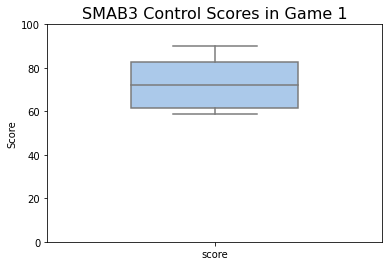

In [22]:
#make a boxplot of the scores in game 1 and game 2 
#s_scores_box = s_scores.boxplot(labels=['Game 1','Game 2'])
#plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))

s_scores1_box = sns.boxplot( 
                 data=s_scores_1,
                 width=0.5,
                 palette="pastel")
s_scores1_box.axes.set_title("SMAB3 Control Scores in Game 1",
                    fontsize=16)

plot_file_name="s_score1_box.jpg"
 
plt.ylim(0, 100)
s_scores1_box.axes.set(ylabel='Score')

# save as jpeg
s_scores1_box.figure.savefig(plot_file_name,
                    format='jpeg')

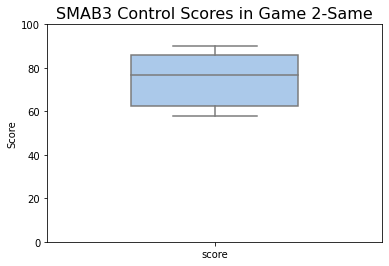

In [23]:
#make a boxplot of the scores in game 1 and game 2 
#s_scores_box = s_scores.boxplot(labels=['Game 1','Game 2'])
#plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))

s_scores2s_box = sns.boxplot( 
                 data=s_scores_2_s,
                 width=0.5,
                 palette="pastel")
s_scores2s_box.axes.set_title("SMAB3 Control Scores in Game 2-Same",
                    fontsize=16)

plot_file_name="s_score_2s_box.jpg"
 
plt.ylim(0, 100)
s_scores2s_box.axes.set(ylabel='Score')

# save as jpeg
s_scores2s_box.figure.savefig(plot_file_name,
                    format='jpeg')

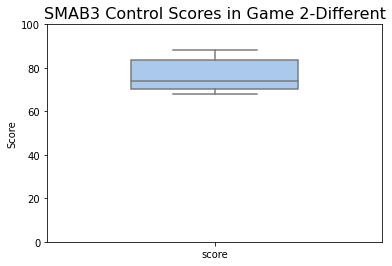

In [24]:
#make a boxplot of the scores in game 1 and game 2 
#s_scores_box = s_scores.boxplot(labels=['Game 1','Game 2'])
#plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))

s_scores2d_box = sns.boxplot( 
                 data=s_scores_2_d,
                 width=0.5,
                 palette="pastel")
s_scores2d_box.axes.set_title("SMAB3 Control Scores in Game 2-Different",
                    fontsize=16)

plot_file_name="s_score_2d_box.jpg"
 
plt.ylim(0, 100)
s_scores2d_box.axes.set(ylabel='Score')

# save as jpeg
s_scores2d_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [25]:
'''Here we look at the means, standard deviations, and medians of the scores in games 1 and 2.'''

s_scores_1_mean = s_scores_1.mean()

In [26]:
s_scores_1_std = s_scores_1.std()

In [27]:
s_scores_1_mean, s_scores_1_std

(score    71.8
 dtype: float64,
 score    11.181618
 dtype: float64)

In [28]:
s_scores_2s_mean = s_scores_2_s.mean()

In [29]:
s_scores_2s_std = s_scores_2_s.std()

In [30]:
s_scores_2d_mean = s_scores_2_d.mean()

In [31]:
s_scores_2d_std = s_scores_2_d.std()

In [32]:
s_scores_2s_mean, s_scores_2s_std

(score    74.625
 dtype: float64,
 score    12.603146
 dtype: float64)

In [33]:
s_scores_2d_mean, s_scores_2d_std

(score    76.857143
 dtype: float64,
 score    8.214389
 dtype: float64)

In [34]:
sp.stats.ttest_ind(s_scores_2_s, s_scores_2_d)

Ttest_indResult(statistic=array([-0.39928923]), pvalue=array([0.69616225]))

In [35]:
'''Here we separate the dataframes of game 1 and game 2 for each subject.'''


s01_p1_g1, s01_p1_g2 = separate_df(s01, 's')
s03_p1_g1, s03_p1_g2 = separate_df(s03, 's')
s05_p1_g1, s05_p1_g2 = separate_df(s05, 's')
s06_p1_g1, s06_p1_g2 = separate_df(s06, 's')
s07_p1_g1, s07_p1_g2 = separate_df(s07, 's')
s08_p1_g1, s08_p1_g2 = separate_df(s08, 's')
s09_p1_g1, s09_p1_g2 = separate_df(s09, 's')
s11_p1_g1, s11_p1_g2 = separate_df(s11, 's')
s12_p1_g1, s12_p1_g2 = separate_df(s12, 's')
s15_p1_g1, s15_p1_g2 = separate_df(s15, 's')
s16_p1_g1, s16_p1_g2 = separate_df(s16, 's')
s17_p1_g1, s17_p1_g2 = separate_df(s17, 's')
s19_p1_g1, s19_p1_g2 = separate_df(s19, 's')
s20_p1_g1, s20_p1_g2 = separate_df(s20, 's')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anacon

In [36]:
s01_p1_g1

,game number,trial,player,arm,probability,reward,time,P1 score,P2 score
0,1,1,1,2,30,1,11.220698,1,0
2,1,2,1,3,60,1,5.362458,2,1
4,1,3,1,2,30,0,3.489552,2,2
6,1,4,1,3,60,0,3.210886,2,3
8,1,5,1,3,60,1,2.904784,3,4
...,...,...,...,...,...,...,...,...,...
190,1,96,1,3,60,1,1.272485,56,87
192,1,97,1,2,30,1,1.465173,57,88
194,1,98,1,3,60,1,1.440924,58,89
196,1,99,1,3,60,1,1.370627,59,90


In [37]:
'''Here we check the arm-probability mappings in each game'''
s01_p1_g1_map = hole_prob_map(s01_p1_g1)
s01_p1_g2_map = hole_prob_map(s01_p1_g2)

s03_p1_g1_map = hole_prob_map(s03_p1_g1)
s03_p1_g2_map = hole_prob_map(s03_p1_g2)

s05_p1_g1_map = hole_prob_map(s05_p1_g1)
#s05_p1_g2_map = hole_prob_map(s05_p1_g2)

s07_p1_g1_map = hole_prob_map(s07_p1_g1)
s07_p1_g2_map = hole_prob_map(s07_p1_g2)

s08_p1_g1_map = hole_prob_map(s08_p1_g1)
s08_p1_g2_map = hole_prob_map(s08_p1_g2)

s09_p1_g1_map = hole_prob_map(s09_p1_g1)
s09_p1_g2_map = hole_prob_map(s09_p1_g2)

s11_p1_g1_map = hole_prob_map(s11_p1_g1)
s11_p1_g2_map = hole_prob_map(s11_p1_g2)

s12_p1_g1_map = hole_prob_map(s12_p1_g1)
s12_p1_g2_map = hole_prob_map(s12_p1_g2)

s15_p1_g1_map = hole_prob_map(s15_p1_g1)
s15_p1_g2_map = hole_prob_map(s15_p1_g2)

s16_p1_g1_map = hole_prob_map(s16_p1_g1)
s16_p1_g2_map = hole_prob_map(s16_p1_g2)

s17_p1_g1_map = hole_prob_map(s17_p1_g1)
#s17_p1_g2_map = hole_prob_map(s17_p1_g2)

In [38]:
s01_p1_g1

,game number,trial,player,arm,probability,reward,time,P1 score,P2 score
0,1,1,1,2,30,1,11.220698,1,0
2,1,2,1,3,60,1,5.362458,2,1
4,1,3,1,2,30,0,3.489552,2,2
6,1,4,1,3,60,0,3.210886,2,3
8,1,5,1,3,60,1,2.904784,3,4
...,...,...,...,...,...,...,...,...,...
190,1,96,1,3,60,1,1.272485,56,87
192,1,97,1,2,30,1,1.465173,57,88
194,1,98,1,3,60,1,1.440924,58,89
196,1,99,1,3,60,1,1.370627,59,90


In [39]:
'''Here we count the number of times that each hole was selected by each subject in each game by calling value_counts'''


s01_p1_g1_count = s01_p1_g1['probability'].value_counts(sort=False)
s01_p1_g2_count = s01_p1_g2['probability'].value_counts(sort=False)
s03_p1_g1_count = s03_p1_g1['probability'].value_counts(sort=False)
s03_p1_g2_count = s03_p1_g2['probability'].value_counts(sort=False)
s05_p1_g1_count = s05_p1_g1['probability'].value_counts(sort=False)
s05_p1_g2_count = s05_p1_g2['probability'].value_counts(sort=False)
s06_p1_g1_count = s06_p1_g1['probability'].value_counts(sort=False)
s06_p1_g2_count = s06_p1_g2['probability'].value_counts(sort=False)
s07_p1_g1_count = s07_p1_g1['probability'].value_counts(sort=False)
s07_p1_g2_count = s07_p1_g2['probability'].value_counts(sort=False)
s08_p1_g1_count = s08_p1_g1['probability'].value_counts(sort=False)
s08_p1_g2_count = s08_p1_g2['probability'].value_counts(sort=False)
s09_p1_g1_count = s09_p1_g1['probability'].value_counts(sort=False)
s09_p1_g2_count = s09_p1_g2['probability'].value_counts(sort=False)
s11_p1_g1_count = s11_p1_g1['probability'].value_counts(sort=False)
s11_p1_g2_count = s11_p1_g2['probability'].value_counts(sort=False)
s12_p1_g1_count = s12_p1_g1['probability'].value_counts(sort=False)
s12_p1_g2_count = s12_p1_g2['probability'].value_counts(sort=False)
s14_p1_g1_count = s14_p1_g1['probability'].value_counts(sort=False)
s14_p1_g2_count = s14_p1_g2['probability'].value_counts(sort=False)
s15_p1_g1_count = s15_p1_g1['probability'].value_counts(sort=False)
s15_p1_g2_count = s15_p1_g2['probability'].value_counts(sort=False)
s16_p1_g1_count = s16_p1_g1['probability'].value_counts(sort=False)
s16_p1_g2_count = s16_p1_g2['probability'].value_counts(sort=False)
s17_p1_g1_count = s17_p1_g1['probability'].value_counts(sort=False)
s17_p1_g2_count = s17_p1_g2['probability'].value_counts(sort=False)
s19_p1_g1_count = s19_p1_g1['probability'].value_counts(sort=False)
s19_p1_g2_count = s19_p1_g2['probability'].value_counts(sort=False)
s20_p1_g1_count = s20_p1_g1['probability'].value_counts(sort=False)
s20_p1_g2_count = s20_p1_g2['probability'].value_counts(sort=False)

In [40]:
s01_p1_g1_count

30    38
60    43
90    19
Name: probability, dtype: int64

In [41]:
s01_p1_g2_count

30    38
60    16
90    46
Name: probability, dtype: int64

In [42]:
'''Here we create dataframes with the counts for game 1.'''

s_g1_counts = pd.DataFrame([s01_p1_g1_count, s03_p1_g1_count, s05_p1_g1_count, s06_p1_g1_count, s07_p1_g1_count, 
                s08_p1_g1_count, s09_p1_g1_count, s11_p1_g1_count, s12_p1_g1_count,s14_p1_g1_count, s15_p1_g1_count, s16_p1_g1_count,
                    s17_p1_g1_count, s19_p1_g1_count, s20_p1_g1_count],
                          index=['s01_p1_g1_count', 's03_p1_g1_count', 
                            's05_p1_g1_count', 's06_p1_g1_count', 's07_p1_g1_count', 's08_p1_g1_count', 
                                 's09_p1_g1_count', 's11_p1_g1_count', 's12_p1_g1_count','s14_p1_g1_count', 's15_p1_g1_count', 
                                 's16_p1_g1_count','s17_p1_g1_count', 's19_p1_g1_count', 's20_p1_g1_count'])



#How to prevent NaN: df = df.fillna(0). This makes the value 0 if a hole was never selected by a subject.
s_g1_counts = s_g1_counts.fillna(0)

#print
s_g1_counts

,30.0,60.0,90.0
s01_p1_g1_count,38,43,19
s03_p1_g1_count,28,38,34
s05_p1_g1_count,11,35,54
s06_p1_g1_count,11,13,76
s07_p1_g1_count,25,29,46
s08_p1_g1_count,2,6,92
s09_p1_g1_count,17,38,45
s11_p1_g1_count,30,34,36
s12_p1_g1_count,7,28,65
s14_p1_g1_count,2,1,97


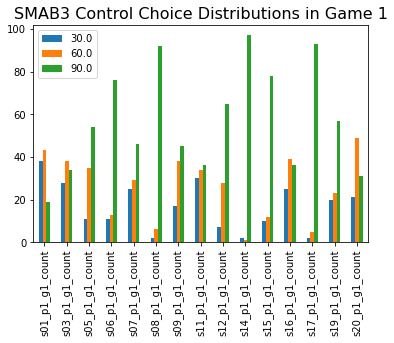

In [43]:
#Here we plot the value counts

s_g1_counts.sum(axis=1)


s_g1_counts_bar = s_g1_counts.plot.bar()

s_g1_counts_bar.axes.set_title("SMAB3 Control Choice Distributions in Game 1",
                    fontsize=16)

# save as jpeg
s_g1_counts_bar.figure.savefig("s_g1_counts_bar.jpg",
                    format='jpeg')

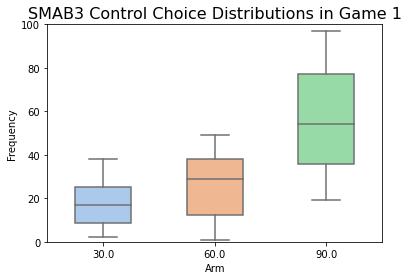

In [44]:
s_g1_counts_box = sns.boxplot( 
                 data=s_g1_counts, 
                 width=0.5,
                 palette="pastel")
s_g1_counts_box.axes.set_title("SMAB3 Control Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="s_g1_counts_box.jpg"
 
plt.ylim(0, 100)
s_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
s_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [45]:
'''Here we get the mean and standard deviation of the number of selections of each hole where low is the 0th column and the 30% hole, 
med is the 1st column and the 60% hole, and high is the 2nd column and the 90% hole.'''


s_g1_low = np.mean(s_g1_counts.iloc[:,0])
s_g1_med = np.mean(s_g1_counts.iloc[:,1])
s_g1_high = np.mean(s_g1_counts.iloc[:,2])


s_g1_low_std = np.std(s_g1_counts.iloc[:,0])
s_g1_med_std = np.std(s_g1_counts.iloc[:,1])
s_g1_high_std = np.std(s_g1_counts.iloc[:,2])

In [46]:
s_g1_low, s_g1_med, s_g1_high

(16.6, 26.2, 57.266666666666666)

In [47]:
 s_g1_low_std, s_g1_med_std, s_g1_high_std

(10.886076734373438, 14.770240350109406, 24.208722027860585)

In [48]:
'''Here we create dataframes with the counts for game 2.'''


s_g2_s_counts = pd.DataFrame([s01_p1_g2_count, s03_p1_g2_count, 
                            s05_p1_g2_count, s06_p1_g2_count, s07_p1_g2_count, s08_p1_g2_count, s09_p1_g2_count],
                             index= ['s01_p1_g2_count', 's03_p1_g2_count', 's05_p1_g2_count', 's06_p1_g2_count',
                                 's07_p1_g2_count', 's08_p1_g2_count', 's09_p1_g2_count'])


#How to prevent NaN: df = df.fillna(0)
s_g2_s_counts = s_g2_s_counts.fillna(0)

#print
s_g2_s_counts

s_g2_s_counts.sum(axis=1)

s01_p1_g2_count    100.0
s03_p1_g2_count    100.0
s05_p1_g2_count    100.0
s06_p1_g2_count    100.0
s07_p1_g2_count    100.0
s08_p1_g2_count    100.0
s09_p1_g2_count    100.0
dtype: float64

In [49]:
s_g2_d_counts = pd.DataFrame([s11_p1_g2_count, s12_p1_g2_count, s14_p1_g2_count, s15_p1_g2_count, s16_p1_g2_count,
                    s17_p1_g2_count, s19_p1_g2_count, s20_p1_g2_count],
index= ['s11_p1_g2_count', 's12_p1_g2_count', 's14_p1_g2_count', 's15_p1_g2_count',
                                 's16_p1_g2_count', 's17_p1_g2_count', 's19_p1_g2_count', 's20_p1_g2_count'])


#How to prevent NaN: df = df.fillna(0)
s_g2_d_counts = s_g2_d_counts.fillna(0)


s_g2_d_counts.sum(axis=1)

s11_p1_g2_count    100.0
s12_p1_g2_count    100.0
s14_p1_g2_count    100.0
s15_p1_g2_count    100.0
s16_p1_g2_count    100.0
s17_p1_g2_count    100.0
s19_p1_g2_count    100.0
s20_p1_g2_count    101.0
dtype: float64

In [50]:
s_g2_d_counts

,30.0,60.0,90.0
s11_p1_g2_count,28.0,30.0,42.0
s12_p1_g2_count,7.0,5.0,88.0
s14_p1_g2_count,2.0,0.0,98.0
s15_p1_g2_count,3.0,7.0,90.0
s16_p1_g2_count,29.0,44.0,27.0
s17_p1_g2_count,0.0,22.0,78.0
s19_p1_g2_count,12.0,9.0,79.0
s20_p1_g2_count,10.0,54.0,37.0


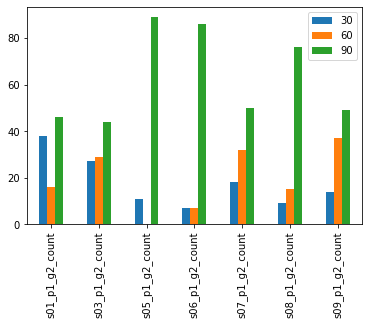

In [51]:
'''Here we plot the counts in game 2.'''

s_g2_s_counts_bar = s_g2_s_counts.plot.bar()

# save as jpeg
s_g2_s_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

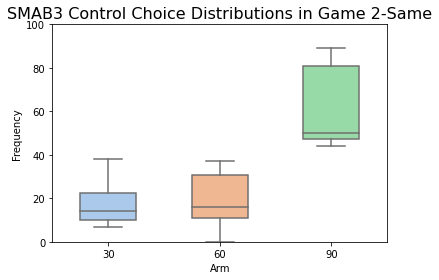

In [52]:
s_g2_s_counts_box = sns.boxplot( 
                 data=s_g2_s_counts, 
                 width=0.5,
                 palette="pastel")
s_g2_s_counts_box.axes.set_title("SMAB3 Control Choice Distributions in Game 2-Same",
                    fontsize=16)

plot_file_name="s_g2_s_counts_box.jpg"

plt.ylim(0, 100)
s_g2_s_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
s_g2_s_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

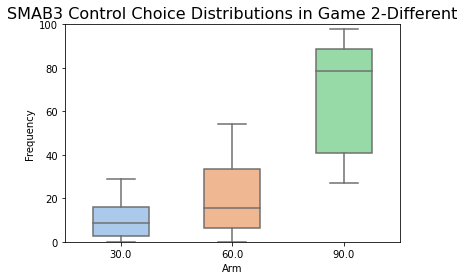

In [53]:
s_g2_d_counts_box = sns.boxplot( 
                 data=s_g2_d_counts, 
                 width=0.5,
                 palette="pastel")
s_g2_d_counts_box.axes.set_title("SMAB3 Control Choice Distributions in Game 2-Different",
                    fontsize=16)

plot_file_name="s_g2_d_counts_box.jpg"

plt.ylim(0, 100)
s_g2_d_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
s_g2_d_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [54]:
'''Here we get the mean and standard deviation of the number of times participants chose each hole.'''


s_g2_s_low = np.mean(s_g2_s_counts.iloc[:,0])
s_g2_s_med = np.mean(s_g2_s_counts.iloc[:,1])
s_g2_s_high = np.mean(s_g2_s_counts.iloc[:,2])


In [55]:
'''Here we get the mean and standard deviation of the number of times participants chose each hole.'''


s_g2_d_low = np.mean(s_g2_d_counts.iloc[:,0])
s_g2_d_med = np.mean(s_g2_d_counts.iloc[:,1])
s_g2_d_high = np.mean(s_g2_d_counts.iloc[:,2])


In [56]:
s_g2_s_low_std = np.std(s_g2_s_counts.iloc[:,0])
s_g2_s_med_std = np.std(s_g2_s_counts.iloc[:,1])
s_g2_s_high_std = np.std(s_g2_s_counts.iloc[:,2])

In [57]:
s_g2_d_low_std = np.std(s_g2_d_counts.iloc[:,0])
s_g2_d_med_std = np.std(s_g2_d_counts.iloc[:,1])
s_g2_d_high_std = np.std(s_g2_d_counts.iloc[:,2])

In [58]:
'''Here we place the value counts for each hole for each game into separate numy arrays and compare them statistically.


import researchpy as rp


s_90_1 = np.array(s_g1_counts.iloc[:,2])
s_90_2 = np.array(s_g2_counts.iloc[:,2])

s_60_1 = np.array(s_g1_counts.iloc[:,1])
s_60_2 = np.array(s_g2_counts.iloc[:,1])


s_30_1 = np.array(s_g1_counts.iloc[:,0])
s_30_2 = np.array(s_g2_counts.iloc[:,0])

s_90_p = sp.stats.ttest_rel(s_90_1,s_90_2)
s_60_p = sp.stats.ttest_rel(s_60_1,s_60_2)
s_30_p = sp.stats.ttest_rel(s_30_1,s_30_2)'''

'Here we place the value counts for each hole for each game into separate numy arrays and compare them statistically.\n\n\nimport researchpy as rp\n\n\ns_90_1 = np.array(s_g1_counts.iloc[:,2])\ns_90_2 = np.array(s_g2_counts.iloc[:,2])\n\ns_60_1 = np.array(s_g1_counts.iloc[:,1])\ns_60_2 = np.array(s_g2_counts.iloc[:,1])\n\n\ns_30_1 = np.array(s_g1_counts.iloc[:,0])\ns_30_2 = np.array(s_g2_counts.iloc[:,0])\n\ns_90_p = sp.stats.ttest_rel(s_90_1,s_90_2)\ns_60_p = sp.stats.ttest_rel(s_60_1,s_60_2)\ns_30_p = sp.stats.ttest_rel(s_30_1,s_30_2)'

In [59]:
s01_p1_g1.reset_index(drop=True, inplace=True)

# Reaction Time Analyses

In [60]:
'Here we get the reaction times'
time_s_1 = pd.DataFrame(columns = ['session','post win','post loss'])
time_s_2 = pd.DataFrame(columns = ['session','post win','post loss'])

In [61]:
time_s_1 = reaction_time(s01_p1_g1, time_s_1)

In [62]:
time_s_1 = reaction_time(s03_p1_g1, time_s_1)
time_s_1 = reaction_time(s05_p1_g1, time_s_1)
time_s_1 = reaction_time(s06_p1_g1, time_s_1)
time_s_1 = reaction_time(s07_p1_g1, time_s_1)
time_s_1 = reaction_time(s08_p1_g1, time_s_1)
time_s_1 = reaction_time(s09_p1_g1, time_s_1)
time_s_1 = reaction_time(s11_p1_g1, time_s_1)
time_s_1 = reaction_time(s12_p1_g1, time_s_1)
time_s_1 = reaction_time(s15_p1_g1, time_s_1)
time_s_1 = reaction_time(s16_p1_g1, time_s_1)
time_s_1 = reaction_time(s17_p1_g1, time_s_1)
time_s_1 = reaction_time(s19_p1_g1, time_s_1)
#time_s_1 = reaction_time(s20_p1_g1, time_s_1)

In [63]:
time_s_2 = reaction_time(s03_p1_g2, time_s_2)
time_s_2 = reaction_time(s05_p1_g2, time_s_2)
time_s_2 = reaction_time(s06_p1_g2, time_s_2)
time_s_2 = reaction_time(s07_p1_g2, time_s_2)
time_s_2 = reaction_time(s08_p1_g2, time_s_2)
time_s_2 = reaction_time(s09_p1_g2, time_s_2)
time_s_2 = reaction_time(s11_p1_g2, time_s_2)
time_s_2 = reaction_time(s12_p1_g2, time_s_2)
time_s_2 = reaction_time(s15_p1_g2, time_s_2)
time_s_2 = reaction_time(s16_p1_g2, time_s_2)
time_s_2 = reaction_time(s17_p1_g2, time_s_2)
time_s_2 = reaction_time(s19_p1_g2, time_s_2)
#time_s_2 = reaction_time(s20_p1_g2, time_s_2)

In [64]:
sp.stats.ttest_rel(time_s_1['post win'], time_s_1['post loss'])

Ttest_relResult(statistic=-0.22232713395530926, pvalue=0.8277981973516864)

In [65]:
sp.stats.ttest_rel(time_s_2['post win'], time_s_2['post loss'])

Ttest_relResult(statistic=1.6133551404642006, pvalue=0.1349630881166298)

In [66]:
#sp.stats.ttest_rel(time_s_1['post loss'], time_s_2['post loss'])

In [67]:
s01_p1_g1.loc[0,'time']

11.22069836

In [68]:
'''Here we get the average reaction times for each subject in games 1 and 2'''
s01_p1_g1_t = s01_p1_g1['time'].mean()
s01_p1_g2_t = s01_p1_g2['time'].mean()

# SMAB4 Single Player Analysis

In [455]:
'''Here we load the csv files into pandas dataframes by calling organize_trial_by_trial and get the scores in games
1 and 2 by calling call_get_score.'''

df = organize_trial_by_trial_hand_code2('data/c01_gamedata_handcode.csv')
c01 = df
#c02_p1_g1_score,c02_p1_g2_score,c02_score_diff, c02_p1_g1_50,c02_p1_g2_50 = call_get_score(c02, 'c')
c01.head()

df = organize_trial_by_trial('data/c02_gamedata.csv')
c02 = df
c02_p1_g1_score,c02_p1_g2_score,c02_score_diff, c02_p1_g1_50,c02_p1_g2_50 = call_get_score(c02, 'c')
c02.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c03_gamedata.csv')
c03 = df
c03_p1_g1_score,c03_p1_g2_score,c03_score_diff, c03_p1_g1_50,c03_p1_g2_50 = call_get_score(c03, 'c')
c03.head()

#missing trials! excluded
df = organize_trial_by_trial_hand_code2('data/c04_gamedata_handcode.csv')
c04 = df
#c04_p1_g1_score,c04_p1_g2_score,c04_score_diff, c04_p1_g1_50,c04_p1_g2_50 = call_get_score(c04, 'c')
c04.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c05_gamedata.csv')
c05 = df
c05_p1_g1_score,c05_p1_g2_score,c05_score_diff, c05_p1_g1_50,c05_p1_g2_50 = call_get_score(c05, 'c')
c05.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c06_gamedata.csv')
c06 = df
c06_p1_g1_score,c06_p1_g2_score,c06_score_diff, c06_p1_g1_50,c06_p1_g2_50 = call_get_score(c06, 'c')
c06.head()


#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c07_gamedata.csv')
c07 = df
c07_p1_g1_score,c07_p1_g2_score,c07_score_diff, c07_p1_g1_50,c07_p1_g2_50 = 78, 86, 8, 34, 42 
#c07.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c09_gamedata.csv')
c09 = df
c09_p1_g1_score,c09_p1_g2_score,c09_score_diff, c09_p1_g1_50,c09_p1_g2_50 = call_get_score(c09, 'c')
c09.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c10_gamedata.csv')
c10 = df
c10_p1_g1_score,c10_p1_g2_score,c10_score_diff, c10_p1_g1_50,c10_p1_g2_50 = call_get_score(c10, 'c')
c10.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c11_gamedata.csv')
c11 = df
c11_p1_g1_score,c11_p1_g2_score,c11_score_diff, c11_p1_g1_50,c11_p1_g2_50 = call_get_score(c11, 'c')
c11.head()

pd.set_option('display.max_columns', None)  

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c12_gamedata2.csv')
c12 = df
c12_p1_g1_score,c12_p1_g2_score,c12_score_diff, c12_p1_g1_50,c12_p1_g2_50 = call_get_score(c12, 'c')
c12.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c13_gamedata2.csv')
c13 = df
c13_p1_g1_score,c13_p1_g2_score,c13_score_diff, c13_p1_g1_50,c13_p1_g2_50 = call_get_score(c13, 'c')
c13.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c14_gamedata2.csv')
c14 = df
c14_p1_g1_score,c14_p1_g2_score,c14_score_diff, c14_p1_g1_50,c14_p1_g2_50 = call_get_score(c14, 'c')
c14.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c15_gamedata.csv')
c15 = df
c15_p1_g1_score,c15_p1_g2_score,c15_score_diff, c15_p1_g1_50,c15_p1_g2_50 = call_get_score(c15, 'c')


#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c16_gamedata2.csv')
c16 = df
c16_p1_g1_score,c16_p1_g2_score,c16_score_diff, c16_p1_g1_50,c16_p1_g2_50 = call_get_score(c16, 'c')
c16.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c17_gamedata2.csv')
c17 = df
c17_p1_g1_score,c17_p1_g2_score,c17_score_diff, c17_p1_g1_50,c17_p1_g2_50 = call_get_score(c17, 'c')
c17#in the s files, p2 is the confederate

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c18_gamedata.csv')
c18 = df
c18_p1_g1_score,c18_p1_g2_score,c18_score_diff, c18_p1_g1_50,c18_p1_g2_50 = call_get_score(c18, 'c')
c18#in the s files, p2 is the confederate



,game number,trial,player,arm,probability,reward,time,P1 score,P2 score
0,1,1,1,3,90,0,5.135425,0,0
1,1,2,2,3,30,0,2.545789,1,0
2,1,3,1,2,60,0,7.996138,1,0
3,1,4,2,3,30,0,3.018310,2,0
4,1,4,1,3,90,0,1.015114,2,0
5,1,6,2,3,30,0,5.250202,3,0
6,1,6,1,3,90,0,1.011486,3,1
7,1,7,2,3,30,0,1.681567,4,1
8,1,8,1,3,90,0,1.076922,4,1
9,1,10,2,3,30,0,56.465390,5,1


In [70]:
c01_p1_counts, c01_p2_counts, c01_p1_probs, c01_p2_probs = handcode_calc_prob(c01)
c04_p1_counts, c04_p2_counts, c04_p1_probs, c04_p2_probs = handcode_calc_prob(c04)

In [71]:
c01_p1_counts

,g1_p1_h1_count,g1_p1_h2_count,g1_p1_h3_count,g2_p1_h1_count,g2_p1_h2_count,g2_p1_h3_count
rewarded,39,20,7,53,20,2
non-rewarded,4,14,14,9,10,10


In [72]:
c04_p1_counts

,g1_p1_h1_count,g1_p1_h2_count,g1_p1_h3_count,g2_p1_h1_count,g2_p1_h2_count,g2_p1_h3_count
rewarded,43,12,1,50,21,1
non-rewarded,5,10,10,7,17,17


In [73]:
c01_p1_probs

,p1_h1,p1_h2,p1_h3
game 1,90.697674,58.823529,33.333333
game 2,85.483871,66.666667,16.666667


In [74]:
c04_p1_probs

,p1_h1,p1_h2,p1_h3
game 1,89.583333,54.545455,9.090909
game 2,87.719298,55.263158,5.555556


In [75]:
#NOT SURE
c01 = fill_in_prob(c01, 90,60,30,90,60,30,90,60,30,90,60,30)
c04 = fill_in_prob(c04, 90,60,30,90,60,30,90,60,30,90,60,30)

In [76]:
c01_p1_g1, c01_p1_g2 = separate_df(c01, 'c')
c04_p1_g1, c04_p1_g2 = separate_df(c04, 'c')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [77]:
c01_p1_g1_score = c01_p1_g1['reward'].sum()
c01_p1_g2_score = c01_p1_g2['reward'].sum()
c04_p1_g1_score = c04_p1_g1['reward'].sum()
c04_p1_g2_score = c04_p1_g2['reward'].sum()

In [457]:
'''Here we place the scores in games 1 and 2 into dataframes.'''


#list out all the scores in game 1 by participant
c_scores_1 = pd.DataFrame({'participant':['c01','c02', 'c03', 
                               'c05', 'c06', 'c07','c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18'], 'score':
     [c01_p1_g1_score, c02_p1_g1_score, c03_p1_g1_score, c05_p1_g1_score, c06_p1_g1_score, c07_p1_g1_score,
      c09_p1_g1_score, c10_p1_g1_score, c11_p1_g1_score, c12_p1_g1_score, c13_p1_g1_score, c14_p1_g1_score, 
      c15_p1_g1_score, c16_p1_g1_score, c17_p1_g1_score, c18_p1_g1_score]})
#to prevent an extra column that numbers each row:
c_scores_1.set_index('participant', inplace=True, drop=True)

#print
c_scores_1


#list out all the scores in game 2 by participant
c_scores_2_d = pd.DataFrame({'participant':['c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11'], 'score':
                           [c02_p1_g2_score, c03_p1_g2_score, c05_p1_g2_score, c06_p1_g2_score, c09_p1_g2_score, c10_p1_g2_score, c11_p1_g2_score]})

#to prevent an extra column that numbers each row:
c_scores_2_d.set_index('participant', inplace=True, drop=True)

c_scores_2_s = pd.DataFrame({'participant':['c01','c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18'], 'score':
                           [c01_p1_g2_score, c12_p1_g2_score, c13_p1_g2_score, c14_p1_g2_score, c15_p1_g2_score, c16_p1_g2_score, c17_p1_g2_score, c18_p1_g2_score]})

#to prevent an extra column that numbers each row:
c_scores_2_s.set_index('participant', inplace=True, drop=True)

'''
#list out all the scores in game 1 by participant
c_scores_1_50 = pd.DataFrame({'participant':['c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c15', 'c14', 'c16', 'c17', 'c18'], 'score_1_50':
     [c02_p1_g1_50, c03_p1_g1_50, c05_p1_g1_50,
      c06_p1_g1_50, c09_p1_g1_50, c10_p1_g1_50, c11_p1_g1_50, c12_p1_g1_50, c13_p1_g1_50, c14_p1_g1_50, c15_p1_g1_50,
      c16_p1_g1_50, c17_p1_g1_50, c18_p1_g1_50]})
#to prevent an extra column that numbers each row:
c_scores_1_50.set_index('participant', inplace=True, drop=True)

#list out all the scores in game 2 by participant
c_scores_2_50 = pd.DataFrame({'participant':['c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17','c18'], 'score_1_50':
     [c02_p1_g2_50, c03_p1_g2_50, c05_p1_g2_50,
      c06_p1_g2_50, c09_p1_g2_50, c10_p1_g2_50, c11_p1_g2_50, c12_p1_g2_50, c13_p1_g2_50, c14_p1_g2_50, 
      c15_p1_g2_50,c16_p1_g2_50, c17_p1_g2_50, c18_p1_g2_50]})
c_scores_2_50.set_index('participant', inplace=True, drop=True)'''

"\n#list out all the scores in game 1 by participant\nc_scores_1_50 = pd.DataFrame({'participant':['c02', 'c03', \n                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c15', 'c14', 'c16', 'c17', 'c18'], 'score_1_50':\n     [c02_p1_g1_50, c03_p1_g1_50, c05_p1_g1_50,\n      c06_p1_g1_50, c09_p1_g1_50, c10_p1_g1_50, c11_p1_g1_50, c12_p1_g1_50, c13_p1_g1_50, c14_p1_g1_50, c15_p1_g1_50,\n      c16_p1_g1_50, c17_p1_g1_50, c18_p1_g1_50]})\n#to prevent an extra column that numbers each row:\nc_scores_1_50.set_index('participant', inplace=True, drop=True)\n\n#list out all the scores in game 2 by participant\nc_scores_2_50 = pd.DataFrame({'participant':['c02', 'c03', \n                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17','c18'], 'score_1_50':\n     [c02_p1_g2_50, c03_p1_g2_50, c05_p1_g2_50,\n      c06_p1_g2_50, c09_p1_g2_50, c10_p1_g2_50, c11_p1_g2_50, c12_p1_g2_50, c13_p1_g2_50, c14_p1_g2_50, \n      c15_p1_g2_50,c1

In [79]:
'''Here we combine the dataframes with the scores from the 2 games.
c_scores_50 = c_scores_1_50.merge(c_scores_2_50,right_index=True,left_index=True)
c_scores = c_scores_1.merge(c_scores_2,right_index=True,left_index=True)
c_combo = c_scores_50.merge(c_scores,right_index=True,left_index=True)

#rename columns
c_combo.columns=["score_1_50", "score_2_50", "score_1", "score_2"]'''

'Here we combine the dataframes with the scores from the 2 games.\nc_scores_50 = c_scores_1_50.merge(c_scores_2_50,right_index=True,left_index=True)\nc_scores = c_scores_1.merge(c_scores_2,right_index=True,left_index=True)\nc_combo = c_scores_50.merge(c_scores,right_index=True,left_index=True)\n\n#rename columns\nc_combo.columns=["score_1_50", "score_2_50", "score_1", "score_2"]'

In [80]:
'''Here we plot the scores in games 1 and 2.

c_scores_1_bar = c_scores_1.plot.bar()



c_scores_2_bar = c_scores_2.plot.bar()



#label columns
#c_scores.columns=['Game 1','Game 2']


c_scores'''

"Here we plot the scores in games 1 and 2.\n\nc_scores_1_bar = c_scores_1.plot.bar()\n\n\n\nc_scores_2_bar = c_scores_2.plot.bar()\n\n\n\n#label columns\n#c_scores.columns=['Game 1','Game 2']\n\n\nc_scores"

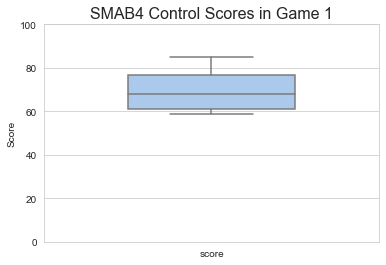

In [458]:
#c_scores1_box = c_scores_1.boxplot()
#plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))


c_scores1_box = sns.boxplot( 
                 data=c_scores_1, 
                 width=0.5,
                 palette="pastel")
c_scores1_box.axes.set_title("SMAB4 Control Scores in Game 1",
                    fontsize=16)

plot_file_name="c_g1_score_box.jpg"
 
plt.ylim(0, 100)
c_scores1_box.axes.set(ylabel='Score')

# save as jpeg
c_scores1_box.figure.savefig(plot_file_name,
                    format='jpeg')

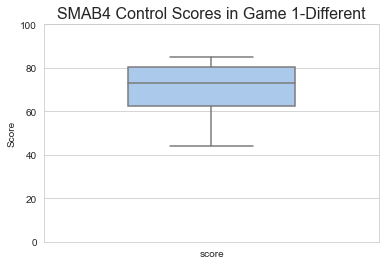

In [459]:
c_scores_2d_box = sns.boxplot( 
                 data=c_scores_2_d, 
                 width=0.5,
                 palette="pastel")
c_scores_2d_box.axes.set_title("SMAB4 Control Scores in Game 1-Different",
                    fontsize=16)

plot_file_name="c_g2d_score_box.jpg"
 
plt.ylim(0, 100)
c_scores_2d_box.axes.set(ylabel='Score')

# save as jpeg
c_scores_2d_box.figure.savefig(plot_file_name,
                    format='jpeg')

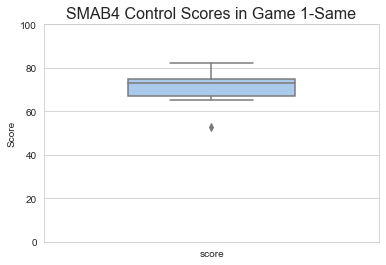

In [460]:
c_scores_2s_box = sns.boxplot( 
                 data=c_scores_2_s, 
                 width=0.5,
                 palette="pastel")
c_scores_2s_box.axes.set_title("SMAB4 Control Scores in Game 1-Same",
                    fontsize=16)

plot_file_name="c_g2s_score_box.jpg"
 
plt.ylim(0, 100)
c_scores_2s_box.axes.set(ylabel='Score')

# save as jpeg
c_scores_2s_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [461]:
c_scores_2s_mean = c_scores_2_s.mean()

In [462]:
c_scores_2s_std = c_scores_2_s.std()

In [463]:
c_scores_2d_mean = c_scores_2_d.mean()

In [464]:
c_scores_2d_std = c_scores_2_d.std()

In [465]:
c_scores_2s_mean, c_scores_2s_std

(score    70.5
 dtype: float64,
 score    8.701396
 dtype: float64)

In [466]:
c_scores_2d_mean, c_scores_2d_std

(score    69.714286
 dtype: float64,
 score    15.424162
 dtype: float64)

In [467]:
sp.stats.ttest_ind(c_scores_2_s, c_scores_2_d)

Ttest_indResult(statistic=array([0.12372052]), pvalue=array([0.903429]))

In [91]:
'''Here we make a boxplot with the scores in the first and second half of the games included
c_combo_box = sns.boxplot( 
                 data=c_combo, order = ['score_1_50','score_2_50','score_1','score_2'],
                 width=0.5,
                 palette="pastel")
c_combo_box.axes.set_title("SMAB4 Control Scores",
                    fontsize=16)

plot_file_name="c_score_box.jpg"
 
plt.ylim(0, 100)
c_combo_box.axes.set(ylabel='Score')

# save as jpeg
c_combo_box.figure.savefig(plot_file_name,
                    format='jpeg')'''

'Here we make a boxplot with the scores in the first and second half of the games included\nc_combo_box = sns.boxplot( \n                 data=c_combo, order = [\'score_1_50\',\'score_2_50\',\'score_1\',\'score_2\'],\n                 width=0.5,\n                 palette="pastel")\nc_combo_box.axes.set_title("SMAB4 Control Scores",\n                    fontsize=16)\n\nplot_file_name="c_score_box.jpg"\n \nplt.ylim(0, 100)\nc_combo_box.axes.set(ylabel=\'Score\')\n\n# save as jpeg\nc_combo_box.figure.savefig(plot_file_name,\n                    format=\'jpeg\')'

In [92]:
'''Get the p value between the scores in games 1 and 2.

c_scores_p = sp.stats.ttest_rel(c_scores['Game 1'],c_scores['Game 2'])



c_scores_p


#plot bar graph of scores


c_scores_2_bar = c_scores_2.plot.bar()



#combine g1 and g2 to one dataframe
c_combo = c_scores_1.append(c_scores_2)



c_combo = pd.DataFrame({'participant':['c02', 'c02', 'c03', 'c03',
                              'c06','c06','c09','c09','c10','c10','c11','c11','c12','c12','c13','c13','c14','c14','c16','c16','c17','c17'], 'score':
     [c02_p1_g1_score, c02_p1_g2_score, c03_p1_g1_score, c03_p1_g2_score, c05_p1_g1_score, c05_p1_g2_score, c06_p1_g1_score, c06_p1_g2_score, c09_p1_g1_score, c09_p1_g2_score, c10_p1_g1_score, c10_p1_g2_score, c11_p1_g1_score, c11_p1_g2_score, c12_p1_g1_score, c12_p1_g2_score, c13_p1_g1_score, c13_p1_g2_score, c14_p1_g1_score, c14_p1_g2_score, c16_p1_g1_score, c16_p1_g2_score, c17_p1_g1_score, c17_p1_g2_score]})
c_combo.set_index('participant', inplace=True, drop=True)


#new_index = ('c02_g1','c02_g2','c03_g1','c03_g2','c04_g1','c04_g2','c05_g1','c05_g2','c06_g1','c06_g2','c09_g1','c09_g2','c10_g1','c10_g2','c11_g1','c11_g2','c12_g1','c12_g2','c13_g1','c13_g2','c14_g1','c14_g2','c16_g1','c16_g2','c17_g1','c17_g2')
#c_combo.index = new_index


c_combo = c_combo.sort_values(by=['participant'])'''

"Get the p value between the scores in games 1 and 2.\n\nc_scores_p = sp.stats.ttest_rel(c_scores['Game 1'],c_scores['Game 2'])\n\n\n\nc_scores_p\n\n\n#plot bar graph of scores\n\n\nc_scores_2_bar = c_scores_2.plot.bar()\n\n\n\n#combine g1 and g2 to one dataframe\nc_combo = c_scores_1.append(c_scores_2)\n\n\n\nc_combo = pd.DataFrame({'participant':['c02', 'c02', 'c03', 'c03',\n                              'c06','c06','c09','c09','c10','c10','c11','c11','c12','c12','c13','c13','c14','c14','c16','c16','c17','c17'], 'score':\n     [c02_p1_g1_score, c02_p1_g2_score, c03_p1_g1_score, c03_p1_g2_score, c05_p1_g1_score, c05_p1_g2_score, c06_p1_g1_score, c06_p1_g2_score, c09_p1_g1_score, c09_p1_g2_score, c10_p1_g1_score, c10_p1_g2_score, c11_p1_g1_score, c11_p1_g2_score, c12_p1_g1_score, c12_p1_g2_score, c13_p1_g1_score, c13_p1_g2_score, c14_p1_g1_score, c14_p1_g2_score, c16_p1_g1_score, c16_p1_g2_score, c17_p1_g1_score, c17_p1_g2_score]})\nc_combo.set_index('participant', inplace=True, drop=T

In [93]:
#unnecessary graph
#need to make g1 and g2 bars diff colors
#colors = list(islice(cycle(['red','blue','green', 'yellow']),None,len(c_combo)))
#blue','red','blue','red','blue','red','blue','red','blue','red','blue']),None,len(c_combo)))
#my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
#c_combo_bar = c_combo.plot(kind='bar',color=colors)

# Checking for outliars

In [94]:
#scatter plot
'''
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(c_combo['score_2_50'], c_combo['score_2'])
ax.set_xlabel('Score at trial 50')
ax.set_ylabel('Score at trial 100')
plt.show()'''

"\nfig, ax = plt.subplots(figsize=(16,8))\nax.scatter(c_combo['score_2_50'], c_combo['score_2'])\nax.set_xlabel('Score at trial 50')\nax.set_ylabel('Score at trial 100')\nplt.show()"

In [95]:
#calculate z score
#z = np.abs(stats.zscore(c_combo['score_2']))
#print(z)

In [96]:
#z = np.abs(stats.zscore(c_combo['score_2_50']))
#print(z)

In [97]:
'''Here we get the mean, median, and standard deviation of the scores in games 1 and 2.'''

c_scores_1_mean = c_scores_1.mean()


c_scores_1_mean

score    68.588235
dtype: float64

In [98]:
c_scores_1_std = c_scores_1.std()


c_scores_1_std

score    8.846319
dtype: float64

In [99]:
c_scores_1_mean, c_scores_1_std

(score    68.588235
 dtype: float64,
 score    8.846319
 dtype: float64)

In [100]:
'''
c_scores_2_mean = c_scores_2.mean()


# In[147]:


c_scores_2_mean'''

'\nc_scores_2_mean = c_scores_2.mean()\n\n\n# In[147]:\n\n\nc_scores_2_mean'

In [101]:
# In[148]:

'''
c_scores_2_std = c_scores_2.std()


# In[149]:


c_scores_2_std'''

'\nc_scores_2_std = c_scores_2.std()\n\n\n# In[149]:\n\n\nc_scores_2_std'

In [102]:
# In[150]:

'''
c_scores_med = c_scores.median()
c_scores_med'''

'\nc_scores_med = c_scores.median()\nc_scores_med'

In [103]:
'''Here we separate the dataframes into games 1 and 2.'''

#s01_p1_g1, s01_p1_g2 = separate_df(s01, 's')
c02_p1_g1, c02_p1_g2 = separate_df(c02, 'c')
c03_p1_g1, c03_p1_g2 = separate_df(c03, 'c')
c05_p1_g1, c05_p1_g2 = separate_df(c05, 'c')
c06_p1_g1, c06_p1_g2 = separate_df(c06, 'c')
c07_p1_g1, c07_p1_g2 = separate_df(c07, 'c')
c09_p1_g1, c09_p1_g2 = separate_df(c09, 'c')
c10_p1_g1, c10_p1_g2 = separate_df(c10, 'c')
c11_p1_g1, c11_p1_g2 = separate_df(c11, 'c')
c12_p1_g1, c12_p1_g2 = separate_df(c12, 'c')
c13_p1_g1, c13_p1_g2 = separate_df(c13, 'c')
c14_p1_g1, c14_p1_g2 = separate_df(c14, 'c')
c15_p1_g1, c15_p1_g2 = separate_df(c15, 'c')
c16_p1_g1, c16_p1_g2 = separate_df(c16, 'c')
c17_p1_g1, c17_p1_g2 = separate_df(c17, 'c')
c18_p1_g1, c18_p1_g2 = separate_df(c18, 'c')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anacon

In [104]:
c13_p1_g1

,game number,trial,player,arm,probability,reward,time,P1 score,P2 score
0,1,1,1,1,60,0,5.531363,0,0
2,1,3,1,3,30,0,4.198000,0,1
4,1,5,1,1,60,0,4.325939,0,1
6,1,7,1,1,60,0,4.197999,1,2
8,1,9,1,3,30,0,3.509329,1,3
...,...,...,...,...,...,...,...,...,...
190,1,191,1,2,90,0,3.294485,59,60
192,1,193,1,2,90,0,3.540312,60,61
194,1,195,1,2,90,0,3.318419,61,61
196,1,197,1,2,90,0,3.525356,62,61


In [105]:
c02_p1_g1_map = hole_prob_map(c02_p1_g1)
c02_p1_g2_map = hole_prob_map(c02_p1_g2)

c03_p1_g1_map = hole_prob_map(c03_p1_g1)
c03_p1_g2_map = hole_prob_map(c03_p1_g2)

c07_p1_g1_map = hole_prob_map(c07_p1_g1)
c07_p1_g2_map = hole_prob_map(c07_p1_g2)

c05_p1_g1_map = hole_prob_map(c05_p1_g1)
c05_p1_g2_map = hole_prob_map(c05_p1_g2)

c06_p1_g1_map = hole_prob_map(c06_p1_g1)
c06_p1_g2_map = hole_prob_map(c06_p1_g2)

c09_p1_g1_map = hole_prob_map(c09_p1_g1)
c09_p1_g2_map = hole_prob_map(c09_p1_g2)

c10_p1_g1_map = hole_prob_map(c10_p1_g1)
c10_p1_g2_map = hole_prob_map(c10_p1_g2)

c11_p1_g1_map = hole_prob_map(c11_p1_g1)
c11_p1_g2_map = hole_prob_map(c11_p1_g2)

c12_p1_g1_map = hole_prob_map(c12_p1_g1)
c12_p1_g2_map = hole_prob_map(c12_p1_g2)

c13_p1_g1_map = hole_prob_map(c13_p1_g1)
c13_p1_g2_map = hole_prob_map(c13_p1_g2)

c14_p1_g1_map = hole_prob_map(c14_p1_g1)
c14_p1_g2_map = hole_prob_map(c14_p1_g2)

c15_p1_g1_map = hole_prob_map(c15_p1_g1)
c15_p1_g2_map = hole_prob_map(c15_p1_g2)

c16_p1_g1_map = hole_prob_map(c16_p1_g1)
c16_p1_g2_map = hole_prob_map(c16_p1_g2)

c17_p1_g1_map = hole_prob_map(c17_p1_g1)
c17_p1_g2_map = hole_prob_map(c17_p1_g2)

c18_p1_g1_map = hole_prob_map(c18_p1_g1)
c18_p1_g2_map = hole_prob_map(c18_p1_g2)

In [106]:
#call fix_reward on all of the files imported with '300' to fix the reward column
c12_p1_g1 = fix_reward(c12_p1_g1)
c12_p1_g2 = fix_reward(c12_p1_g2)
c13_p1_g1 = fix_reward(c13_p1_g1)
c13_p1_g2 = fix_reward(c13_p1_g2)
c14_p1_g1 = fix_reward(c14_p1_g1)
c14_p1_g2 = fix_reward(c14_p1_g2)
c15_p1_g1 = fix_reward(c15_p1_g1)
c15_p1_g2 = fix_reward(c15_p1_g2)
c16_p1_g1 = fix_reward(c16_p1_g1)
c16_p1_g2 = fix_reward(c16_p1_g2)
c17_p1_g1 = fix_reward(c17_p1_g1)
c17_p1_g2 = fix_reward(c17_p1_g2)
c18_p1_g1 = fix_reward(c18_p1_g1)
c18_p1_g2 = fix_reward(c18_p1_g2)


In [107]:
'''Here we count the number of times each hole was chosen in each game and place it in an array.'''

c01_p1_g1_count = c01_p1_g1['probability'].value_counts(sort=False)
c01_p1_g2_count = c01_p1_g2['probability'].value_counts(sort=False)
c02_p1_g1_count = c02_p1_g1['probability'].value_counts(sort=False)
c02_p1_g2_count = c02_p1_g2['probability'].value_counts(sort=False)
c03_p1_g1_count = c03_p1_g1['probability'].value_counts(sort=False)
c03_p1_g2_count = c03_p1_g2['probability'].value_counts(sort=False)
c04_p1_g1_count = c04_p1_g1['probability'].value_counts(sort=False)
c04_p1_g2_count = c04_p1_g2['probability'].value_counts(sort=False)
c05_p1_g1_count = c05_p1_g1['probability'].value_counts(sort=False)
c05_p1_g2_count = c05_p1_g2['probability'].value_counts(sort=False)
c06_p1_g1_count = c06_p1_g1['probability'].value_counts(sort=False)
c06_p1_g2_count = c06_p1_g2['probability'].value_counts(sort=False)
c07_p1_g1_count = c07_p1_g1['probability'].value_counts(sort=False)
c07_p1_g2_count = c07_p1_g2['probability'].value_counts(sort=False)
c09_p1_g1_count = c09_p1_g1['probability'].value_counts(sort=False)
c09_p1_g2_count = c09_p1_g2['probability'].value_counts(sort=False)
c10_p1_g1_count = c10_p1_g1['probability'].value_counts(sort=False)
c10_p1_g2_count = c10_p1_g2['probability'].value_counts(sort=False)
c11_p1_g1_count = c11_p1_g1['probability'].value_counts(sort=False)
c11_p1_g2_count = c11_p1_g2['probability'].value_counts(sort=False)
c12_p1_g1_count = c12_p1_g1['probability'].value_counts(sort=False)
c12_p1_g2_count = c12_p1_g2['probability'].value_counts(sort=False)
c13_p1_g1_count = c13_p1_g1['probability'].value_counts(sort=False)
c13_p1_g2_count = c13_p1_g2['probability'].value_counts(sort=False)
c14_p1_g1_count = c14_p1_g1['probability'].value_counts(sort=False)
c14_p1_g2_count = c14_p1_g2['probability'].value_counts(sort=False)
c15_p1_g1_count = c15_p1_g1['probability'].value_counts(sort=False)
c15_p1_g2_count = c15_p1_g2['probability'].value_counts(sort=False)
c16_p1_g1_count = c16_p1_g1['probability'].value_counts(sort=False)
c16_p1_g2_count = c16_p1_g2['probability'].value_counts(sort=False)
c17_p1_g1_count = c17_p1_g1['probability'].value_counts(sort=False)
c17_p1_g2_count = c17_p1_g2['probability'].value_counts(sort=False)
c18_p1_g1_count = c18_p1_g1['probability'].value_counts(sort=False)
c18_p1_g2_count = c18_p1_g2['probability'].value_counts(sort=False)

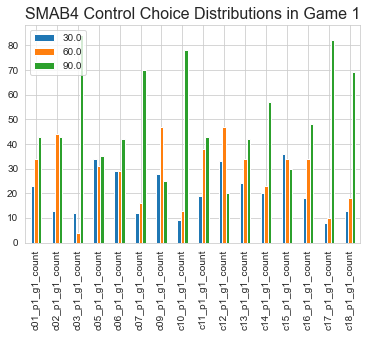

In [468]:
'''Here we place the number of times each hole was chosen by each subject in game 1 and into a dataframe.
We also plot this data and get the means and standard deviations of it.'''


c_g1_counts = pd.DataFrame([c01_p1_g1_count, c02_p1_g1_count, c03_p1_g1_count,
                            c05_p1_g1_count, c06_p1_g1_count, c07_p1_g1_count, c09_p1_g1_count, c10_p1_g1_count, c11_p1_g1_count, c12_p1_g1_count, c13_p1_g1_count, c14_p1_g1_count, c15_p1_g1_count,
                            c16_p1_g1_count, c17_p1_g1_count, c18_p1_g1_count],
         index=['c01_p1_g1_count', 'c02_p1_g1_count', 'c03_p1_g1_count', 'c05_p1_g1_count', 'c06_p1_g1_count', 
                'c07_p1_g1_count','c09_p1_g1_count', 'c10_p1_g1_count', 'c11_p1_g1_count', 'c12_p1_g1_count', 'c13_p1_g1_count', 'c14_p1_g1_count', 
                'c15_p1_g1_count', 'c16_p1_g1_count', 'c17_p1_g1_count', 'c18_p1_g1_count'])


#How to prevent NaN: df = df.fillna(0)
c_g1_counts = c_g1_counts.fillna(0)

#print
c_g1_counts


c_g1_counts.sum(axis=1)


c_g1_counts_bar = c_g1_counts.plot.bar()

c_g1_counts_bar.axes.set_title("SMAB4 Control Choice Distributions in Game 1",
                    fontsize=16)

# save as jpeg
c_g1_counts_bar.figure.savefig('c_g1_counts_bar.jpg',
                    format='jpeg',
                    dpi=100)

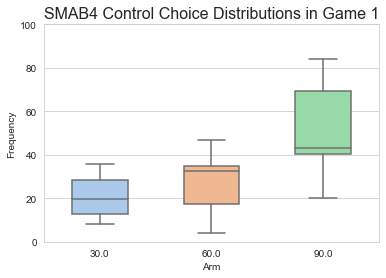

In [469]:
c_g1_counts_box = sns.boxplot( 
                 data=c_g1_counts, 
                 width=0.5,
                 palette="pastel")
c_g1_counts_box.axes.set_title("SMAB4 Control Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="c_g1_counts_box.jpg"
 
plt.ylim(0, 100)
c_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
c_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [470]:
# In[158]:


#0 is low (30), 1 is med (60), 2 is high (90)
c_g1_low = np.mean(c_g1_counts.iloc[:,0])
c_g1_med = np.mean(c_g1_counts.iloc[:,1])
c_g1_high = np.mean(c_g1_counts.iloc[:,2])

In [471]:
c_g1_low_std = np.std(c_g1_counts.iloc[:,0])
c_g1_med_std = np.std(c_g1_counts.iloc[:,1])
c_g1_high_std = np.std(c_g1_counts.iloc[:,2])

In [472]:
c_g1_low, c_g1_med, c_g1_high

(20.6875, 28.5, 50.6875)

In [473]:
c_g1_low_std, c_g1_med_std, c_g1_high_std

(8.942306399917193, 12.801367114492107, 19.67777537604289)

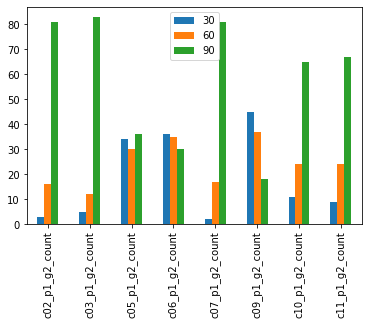

In [114]:
'''Here we place the number of times each hole was chosen by each subject in game 2 and into a dataframe.
We also plot this data and get the means and standard deviations of it.'''

c_g2_d_counts = pd.DataFrame([c02_p1_g2_count, c03_p1_g2_count,
                            c05_p1_g2_count, c06_p1_g2_count, c07_p1_g2_count, c09_p1_g2_count, c10_p1_g2_count, c11_p1_g2_count],
         index=['c02_p1_g2_count', 'c03_p1_g2_count', 'c05_p1_g2_count', 'c06_p1_g2_count', 'c07_p1_g2_count',
                'c09_p1_g2_count', 'c10_p1_g2_count', 'c11_p1_g2_count'])


#How to prevent NaN: df = df.fillna(0)
c_g2_d_counts = c_g2_d_counts.fillna(0)

#print
c_g2_d_counts


c_g2_d_counts.sum(axis=1)


c_g2_d_counts_bar = c_g2_d_counts.plot.bar()

# save as jpeg
c_g2_d_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

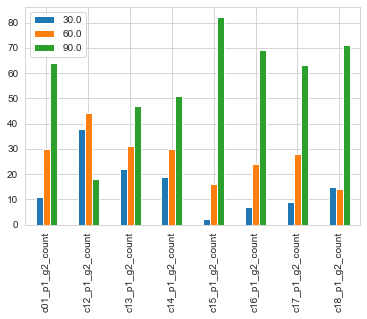

In [474]:
'''Here we place the number of times each hole was chosen by each subject in game 2 and into a dataframe.
We also plot this data and get the means and standard deviations of it.'''

c_g2_s_counts = pd.DataFrame([c01_p1_g2_count, c12_p1_g2_count, c13_p1_g2_count, c14_p1_g2_count, c15_p1_g2_count, c16_p1_g2_count, c17_p1_g2_count, c18_p1_g2_count],
         index=['c01_p1_g2_count', 'c12_p1_g2_count', 'c13_p1_g2_count', 
                'c14_p1_g2_count', 'c15_p1_g2_count',
                'c16_p1_g2_count', 'c17_p1_g2_count', 'c18_p1_g2_count'])


#How to prevent NaN: df = df.fillna(0)
c_g2_s_counts = c_g2_s_counts.fillna(0)

#print
c_g2_s_counts


c_g2_s_counts.sum(axis=1)


c_g2_s_counts_bar = c_g2_s_counts.plot.bar()

# save as jpeg
c_g2_s_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

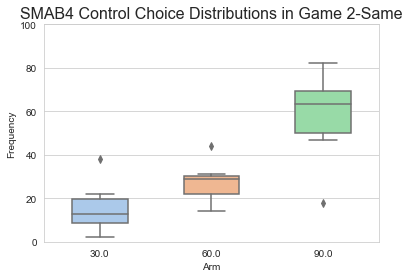

In [475]:
c_g2_s_counts_box = sns.boxplot( 
                 data=c_g2_s_counts, 
                 width=0.5,
                 palette="pastel")
c_g2_s_counts_box.axes.set_title("SMAB4 Control Choice Distributions in Game 2-Same",
                    fontsize=16)

plot_file_name="c_g2_s_counts_box.jpg"
 
plt.ylim(0, 100)
c_g2_s_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
c_g2_s_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

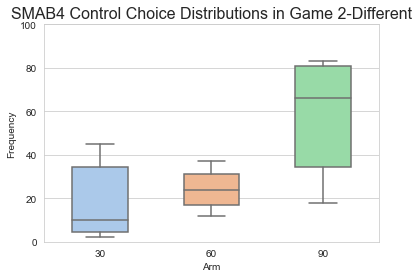

In [476]:
c_g2_d_counts_box = sns.boxplot( 
                 data=c_g2_d_counts, 
                 width=0.5,
                 palette="pastel")
c_g2_d_counts_box.axes.set_title("SMAB4 Control Choice Distributions in Game 2-Different",
                    fontsize=16)

plot_file_name="c_g2_d_counts_box.jpg"
 
plt.ylim(0, 100)
c_g2_d_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
c_g2_d_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [477]:
c_g2_s_low = np.mean(c_g2_s_counts.iloc[:,0])
c_g2_s_med = np.mean(c_g2_s_counts.iloc[:,1])
c_g2_s_high = np.mean(c_g2_s_counts.iloc[:,2])

c_g2_d_low = np.mean(c_g2_d_counts.iloc[:,0])
c_g2_d_med = np.mean(c_g2_d_counts.iloc[:,1])
c_g2_d_high = np.mean(c_g2_d_counts.iloc[:,2])

In [478]:
c_g2_s_low_std = np.std(c_g2_s_counts.iloc[:,0])
c_g2_s_med_std = np.std(c_g2_s_counts.iloc[:,1])
c_g2_s_high_std = np.std(c_g2_s_counts.iloc[:,2])

c_g2_d_low_std = np.std(c_g2_d_counts.iloc[:,0])
c_g2_d_med_std = np.std(c_g2_d_counts.iloc[:,1])
c_g2_d_high_std = np.std(c_g2_d_counts.iloc[:,2])

In [479]:
sp.stats.ttest_ind(c_g1_counts, c_g2_s_counts)

Ttest_indResult(statistic=array([ 1.23894811,  0.26146551, -0.85433918]), pvalue=array([0.22842083, 0.7961658 , 0.40212474]))

In [480]:
sp.stats.ttest_ind(c_g1_counts, c_g2_d_counts)

Ttest_indResult(statistic=array([ 0.47826477,  0.78939955, -0.72059763]), pvalue=array([0.63718017, 0.43830404, 0.47874466]))

In [481]:
sp.stats.ttest_ind(c_g2_s_counts, c_g2_d_counts)

Ttest_indResult(statistic=array([-0.37782112,  0.59289562,  0.04356437]), pvalue=array([0.71122998, 0.56270658, 0.9658669 ]))

In [482]:
c_g2_s_low_std, c_g2_s_med_std, c_g2_s_high_std, c_g2_d_low_std, c_g2_d_med_std, c_g2_d_high_std

(10.475417652771654,
 8.823795951856548,
 18.360538526960475,
 16.15887913810856,
 8.528445051707843,
 24.186450235617464)

# Reaction Time Analyses

In [124]:
'Here we get the reaction times'
'NEED to fix rewards for SMAB4'
time_c_1 = pd.DataFrame(columns = ['session','post win','post loss'])
time_c_2 = pd.DataFrame(columns = ['session','post win','post loss'])

In [125]:
time_c_1 = reaction_time(c02_p1_g1, time_c_1)
time_c_1 = reaction_time(c03_p1_g1, time_c_1)
time_c_1 = reaction_time(c05_p1_g1, time_c_1)
time_c_1 = reaction_time(c06_p1_g1, time_c_1)
time_c_1 = reaction_time(c09_p1_g1, time_c_1)
time_c_1 = reaction_time(c10_p1_g1, time_c_1)
time_c_1 = reaction_time(c11_p1_g1, time_c_1)
time_c_1 = reaction_time(c12_p1_g1, time_c_1)
time_c_1 = reaction_time(c13_p1_g1, time_c_1)
time_c_1 = reaction_time(c14_p1_g1, time_c_1)
time_c_1 = reaction_time(c15_p1_g1, time_c_1)
time_c_1 = reaction_time(c16_p1_g1, time_c_1)
time_c_1 = reaction_time(c17_p1_g1, time_c_1)
time_c_1 = reaction_time(c18_p1_g1, time_c_1)

In [126]:
time_c_1

,session,post win,post loss
0,c02_p1_g1,4.310843,4.483266
1,c03_p1_g1,3.233906,3.376468
2,c05_p1_g1,3.831172,3.794584
3,c06_p1_g1,3.367617,3.455480
4,c09_p1_g1,3.567952,3.557236
5,c10_p1_g1,3.213206,3.451479
6,c11_p1_g1,3.615086,4.014988
7,c12_p1_g1,3.721225,3.878290
8,c13_p1_g1,3.484952,3.786906
9,c14_p1_g1,3.311307,3.439066


In [127]:
time_c_2 = reaction_time(c02_p1_g2, time_c_2)
time_c_2 = reaction_time(c03_p1_g2, time_c_2)
time_c_2 = reaction_time(c05_p1_g2, time_c_2)
time_c_2 = reaction_time(c06_p1_g2, time_c_2)
time_c_2 = reaction_time(c09_p1_g2, time_c_2)
time_c_2 = reaction_time(c10_p1_g2, time_c_2)
time_c_2 = reaction_time(c11_p1_g2, time_c_2)
time_c_2 = reaction_time(c12_p1_g2, time_c_2)
time_c_2 = reaction_time(c13_p1_g2, time_c_2)
time_c_2 = reaction_time(c14_p1_g2, time_c_2)
time_c_2 = reaction_time(c15_p1_g2, time_c_2)
time_c_2 = reaction_time(c16_p1_g2, time_c_2)
time_c_2 = reaction_time(c17_p1_g2, time_c_2)
time_c_2 = reaction_time(c18_p1_g2, time_c_2)

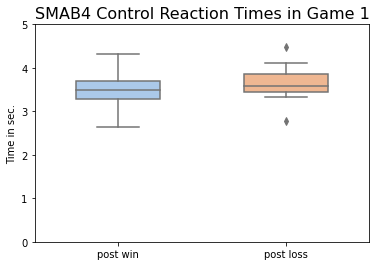

In [128]:
times_c_g1_box = sns.boxplot( 
                 data=time_c_1, 
                 width=0.5,
                 palette="pastel")
times_c_g1_box.axes.set_title("SMAB4 Control Reaction Times in Game 1",
                    fontsize=16)

plot_file_name="times_c_g1_box.jpg"
 
plt.ylim(0, 5)
times_c_g1_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_c_g1_box.figure.savefig(plot_file_name,format='jpeg')

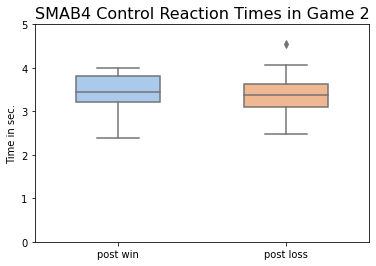

In [129]:
times_c_g2_box = sns.boxplot( 
                 data=time_c_2, 
                 width=0.5,
                 palette="pastel")
times_c_g2_box.axes.set_title("SMAB4 Control Reaction Times in Game 2",
                    fontsize=16)

plot_file_name="times_c_g2_box.jpg"
 
plt.ylim(0, 5)
times_c_g2_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_c_g2_box.figure.savefig(plot_file_name,format='jpeg')

In [130]:
np.mean(time_c_1)

post win     3.516535
post loss    3.645953
dtype: float64

In [131]:
np.mean(time_c_2)

post win     3.423937
post loss    3.395499
dtype: float64

In [132]:
np.std(time_c_1)

post win     0.399678
post loss    0.398324
dtype: float64

In [133]:
np.std(time_c_2)

post win     0.436234
post loss    0.536441
dtype: float64

In [134]:
sp.stats.ttest_rel(time_c_1['post win'],time_c_1['post loss'])

Ttest_relResult(statistic=-3.895131923798299, pvalue=0.0018430668367242645)

In [135]:
sp.stats.ttest_rel(time_c_2['post win'],time_c_2['post loss'])

Ttest_relResult(statistic=0.3910238480157525, pvalue=0.7021128497106475)

In [136]:
#not working
#sp.stats.ttest_rel(time_c_1['post win'],time_c_2['post win'])

In [137]:
#not working
#sp.stats.ttest_rel(time_c_1['post loss'],time_c_2['post loss'])

# Maximizing vs Matching

In [138]:
import math

In [139]:
'''
#TEST- JSD for multiple distributions
def entropy(prob_dist, base=math.e):
        return -sum([p * math.log(p,base) for p in prob_dist if p != 0])

def jsd(prob_dists, base=math.e):
    weight = 1/len(prob_dists) #all same weight
    js_left = [0,0,0]
    js_right = 0    
    for pd in prob_dists:
        js_left[0] += pd[0]*weight
        js_left[1] += pd[1]*weight
        js_left[2] += pd[2]*weight
        js_right += weight*entropy(pd,base)
    return entropy(js_left)-js_right'''

'\n#TEST- JSD for multiple distributions\ndef entropy(prob_dist, base=math.e):\n        return -sum([p * math.log(p,base) for p in prob_dist if p != 0])\n\ndef jsd(prob_dists, base=math.e):\n    weight = 1/len(prob_dists) #all same weight\n    js_left = [0,0,0]\n    js_right = 0    \n    for pd in prob_dists:\n        js_left[0] += pd[0]*weight\n        js_left[1] += pd[1]*weight\n        js_left[2] += pd[2]*weight\n        js_right += weight*entropy(pd,base)\n    return entropy(js_left)-js_right'

In [483]:
#NOTE: rewrite using pandas dataframe
# In[239]:

#Call 'call_jsd' for each participant for each game in the single player sessions.
#with 0, put in actual probabilities in brackets

s01_g1_max,s01_g1_match,s01_g1_rand,s01_g1_soc = call_jsd(s01_p1_g1_count)
s01_g2_max,s01_g2_match,s01_g2_rand,s01_g2_soc = call_jsd(s01_p1_g2_count)
s03_g1_max,s03_g1_match,s03_g1_rand,s03_g1_soc = call_jsd(s03_p1_g1_count)
s03_g2_max,s03_g2_match,s03_g2_rand,s03_g2_soc = call_jsd(s03_p1_g2_count)
s05_g1_max,s05_g1_match,s05_g1_rand,s05_g1_soc= call_jsd(s05_p1_g1_count)
s05_g2_max,s05_g2_match,s05_g2_rand,s05_g2_soc = call_jsd([11, 0, 89])
s06_g1_max,s06_g1_match,s06_g1_rand,s06_g1_soc = call_jsd(s06_p1_g1_count)
s06_g2_max,s06_g2_match,s06_g2_rand,s06_g2_soc = call_jsd(s06_p1_g2_count)
s07_g1_max,s07_g1_match,s07_g1_rand,s07_g1_soc = call_jsd(s07_p1_g1_count)
s07_g2_max,s07_g2_match,s07_g2_rand,s07_g2_soc = call_jsd(s07_p1_g2_count)
s08_g1_max,s08_g1_match,s08_g1_rand,s08_g1_soc = call_jsd(s08_p1_g1_count)
s08_g2_max,s08_g2_match,s08_g2_rand,s08_g2_soc = call_jsd(s08_p1_g2_count)
s09_g1_max,s09_g1_match,s09_g1_rand,s09_g1_soc = call_jsd(s09_p1_g1_count)
s09_g2_max,s09_g2_match,s09_g2_rand,s09_g2_soc = call_jsd(s09_p1_g2_count)
s11_g1_max,s11_g1_match,s11_g1_rand,s11_g1_soc = call_jsd(s11_p1_g1_count)
s11_g2_max,s11_g2_match,s11_g2_rand,s11_g2_soc = call_jsd(s11_p1_g2_count)
s12_g1_max,s12_g1_match,s12_g1_rand,s12_g1_soc = call_jsd(s12_p1_g1_count)
s12_g2_max,s12_g2_match,s12_g2_rand,s12_g2_soc = call_jsd(s12_p1_g2_count)
s14_g1_max,s14_g1_match,s14_g1_rand,s14_g1_soc = call_jsd(s14_p1_g1_count)
s14_g2_max,s14_g2_match,s14_g2_rand,s14_g2_soc = call_jsd([2,0,98])
s15_g1_max,s15_g1_match,s15_g1_rand,s15_g1_soc = call_jsd(s15_p1_g1_count)
s15_g2_max,s15_g2_match,s15_g2_rand,s15_g2_soc = call_jsd(s15_p1_g2_count)
s16_g1_max,s16_g1_match,s16_g1_rand,s16_g1_soc = call_jsd(s16_p1_g1_count)
s16_g2_max,s16_g2_match,s16_g2_rand,s16_g2_soc = call_jsd(s16_p1_g2_count)
s17_g1_max,s17_g1_match,s17_g1_rand,s17_g1_soc = call_jsd(s17_p1_g1_count)
s17_g2_max,s17_g2_match,s17_g2_rand,s17_g2_soc = call_jsd([0,22,78])
s19_g1_max,s19_g1_match,s19_g1_rand,s19_g1_soc = call_jsd(s19_p1_g1_count)
s19_g2_max,s19_g2_match,s19_g2_rand,s19_g2_soc = call_jsd(s19_p1_g2_count)
s20_g1_max,s20_g1_match,s20_g1_rand,s20_g1_soc = call_jsd(s20_p1_g1_count)
s20_g2_max,s20_g2_match,s20_g2_rand,s20_g2_soc = call_jsd(s20_p1_g2_count)
c01_g1_max,c01_g1_match,c01_g1_rand,c01_g1_soc = call_jsd(c01_p1_g1_count)
c01_g2_max,c01_g2_match,c01_g2_rand,c01_g2_soc = call_jsd(c01_p1_g2_count)
c02_g1_max,c02_g1_match,c02_g1_rand,c02_g1_soc = call_jsd(c02_p1_g1_count)
c02_g2_max,c02_g2_match,c02_g2_rand,c02_g2_soc = call_jsd(c02_p1_g2_count)
c03_g1_max,c03_g1_match,c03_g1_rand,c03_g1_soc = call_jsd(c03_p1_g1_count)
c03_g2_max,c03_g2_match,c03_g2_rand,c03_g2_soc = call_jsd(c03_p1_g2_count)
c04_g1_max,c04_g1_match,c04_g1_rand,c04_g1_soc = call_jsd(c04_p1_g1_count)
c04_g2_max,c04_g2_match,c04_g2_rand,c04_g2_soc = call_jsd(c04_p1_g2_count)
c05_g1_max,c05_g1_match,c05_g1_rand,c05_g1_soc = call_jsd(c05_p1_g1_count)
c05_g2_max,c05_g2_match,c05_g2_rand,c05_g2_soc = call_jsd(c05_p1_g2_count)
c06_g1_max,c06_g1_match,c06_g1_rand,c06_g1_soc = call_jsd(c06_p1_g1_count)
c06_g2_max,c06_g2_match,c06_g2_rand,c06_g2_soc = call_jsd(c06_p1_g1_count)
c07_g1_max,c07_g1_match,c07_g1_rand,c07_g1_soc = call_jsd(c07_p1_g1_count)
c07_g2_max,c07_g2_match,c07_g2_rand,c07_g2_soc = call_jsd(c07_p1_g1_count)
c09_g1_max,c09_g1_match,c09_g1_rand,c09_g1_soc = call_jsd(c09_p1_g1_count)
c09_g2_max,c09_g2_match,c09_g2_rand,c09_g2_soc = call_jsd(c09_p1_g2_count)
c10_g1_max,c10_g1_match,c10_g1_rand,c10_g1_soc = call_jsd(c10_p1_g1_count)
c10_g2_max,c10_g2_match,c10_g2_rand,c10_g2_soc = call_jsd(c10_p1_g2_count)
c11_g1_max,c11_g1_match,c11_g1_rand,c11_g1_soc = call_jsd(c11_p1_g1_count)
c11_g2_max,c11_g2_match,c11_g2_rand,c11_g2_soc= call_jsd(c11_p1_g2_count)
c12_g1_max,c12_g1_match,c12_g1_rand,c12_g1_soc = call_jsd(c12_p1_g1_count)
c12_g2_max,c12_g2_match,c12_g2_rand,c12_g2_soc = call_jsd(c12_p1_g2_count)
c13_g1_max,c13_g1_match,c13_g1_rand,c13_g1_soc  = call_jsd(c13_p1_g1_count)
c13_g2_max,c13_g2_match,c13_g2_rand,c13_g2_soc = call_jsd(c13_p1_g2_count)
c14_g1_max,c14_g1_match,c14_g1_rand,c14_g1_soc = call_jsd(c14_p1_g1_count)
c14_g2_max,c14_g2_match,c14_g2_rand,c14_g2_soc = call_jsd(c14_p1_g2_count)
c16_g1_max,c16_g1_match,c16_g1_rand,c16_g1_soc = call_jsd(c16_p1_g1_count)
c16_g2_max,c16_g2_match,c16_g2_rand,c16_g2_soc = call_jsd(c16_p1_g2_count)
c17_g1_max,c17_g1_match,c17_g1_rand,c17_g1_soc = call_jsd(c17_p1_g1_count)
c17_g2_max,c17_g2_match,c17_g2_rand,c17_g2_soc = call_jsd(c17_p1_g2_count)
c18_g1_max,c18_g1_match,c18_g1_rand,c18_g1_soc = call_jsd(c18_p1_g1_count)
c18_g2_max,c18_g2_match,c18_g2_rand,c18_g2_soc = call_jsd(c18_p1_g2_count)

In [484]:
s01_p1_g1_count

30    38
60    43
90    19
Name: probability, dtype: int64

In [142]:
s01_g1_max

0.4318754981734429

In [143]:
s01_g1_match

0.06054148947299787

In [144]:
s01_p1_g2_count

30    38
60    16
90    46
Name: probability, dtype: int64

In [145]:
s01_g2_max

0.23828696089939724

In [146]:
max_vs_max, max_vs_match, d, c = call_jsd(maximize)

In [485]:
# In[ ]:


#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
control_jsd_g1 = pd.DataFrame({'max':[s01_g1_max,s03_g1_max,s05_g1_max,s06_g1_max,s07_g1_max,s08_g1_max,
                                s09_g1_max, s11_g1_max, s12_g1_max, s14_g1_max, s15_g1_max, s16_g1_max, s17_g1_max, 
                                      s19_g1_max, s20_g1_max, c01_g1_max, c02_g1_max, c03_g1_max, c05_g1_max, c06_g1_max, 
                                      c07_g1_max, c09_g1_max, c10_g1_max, c11_g1_max, c12_g1_max, c13_g1_max, c14_g1_max, 
                                      c16_g1_max, c17_g1_max, c18_g1_max],
                      'match':[s01_g1_match,s03_g1_match,s05_g1_match
                               ,s06_g1_match,s07_g1_match,s08_g1_match,s09_g1_match, s11_g1_match, 
                               s12_g1_match, s14_g1_match, s15_g1_match, s16_g1_match, s17_g1_match, s19_g1_match, 
                               s20_g1_match, c01_g1_match, c02_g1_match, c03_g1_match, c05_g1_match, c06_g1_match, 
                                      c07_g1_match, c09_g1_match, c10_g1_match, c11_g1_match, c12_g1_match, c13_g1_match, c14_g1_match, 
                                      c16_g1_match, c17_g1_match, c18_g1_match],
                    'rand':[s01_g1_rand,s03_g1_rand,s05_g1_rand,s06_g1_rand,s07_g1_rand,s08_g1_rand,
                                s09_g1_rand, s11_g1_rand, s12_g1_rand, s14_g1_rand, s15_g1_rand, s16_g1_rand, s17_g1_rand, 
                                      s19_g1_rand, s20_g1_rand, c01_g1_rand, c02_g1_rand, c03_g1_rand, c05_g1_rand, c06_g1_rand, 
                                      c07_g1_rand, c09_g1_rand, c10_g1_rand, c11_g1_rand, c12_g1_rand, c13_g1_rand, c14_g1_rand, 
                                      c16_g1_rand, c17_g1_rand, c18_g1_rand],
                        'soc':[s01_g1_soc,s03_g1_soc,s05_g1_soc,s06_g1_soc,s07_g1_soc,s08_g1_soc,
                                s09_g1_soc, s11_g1_soc, s12_g1_soc, s14_g1_soc, s15_g1_soc, s16_g1_soc, s17_g1_soc, 
                                      s19_g1_soc, s20_g1_soc, c01_g1_soc, c02_g1_soc, c03_g1_soc, c05_g1_soc, c06_g1_soc, 
                                      c07_g1_soc, c09_g1_soc, c10_g1_soc, c11_g1_soc, c12_g1_soc, c13_g1_soc, c14_g1_soc, 
                                      c16_g1_soc, c17_g1_soc, c18_g1_soc]},
                              
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's14', 's15', 's16', 's17', 's19', 's20', 'c01', 'c02', 'c03', 
                               'c05', 'c06', 'c07','c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17', 'c18'])

In [486]:
control_jsd_g1

,max,match,rand,soc
s01,0.431875,0.060541,0.013773,0.013773
s03,0.313661,0.015698,0.001941,0.001941
s05,0.194304,0.003409,0.041901,0.041901
s06,0.091385,0.039518,0.095295,0.095295
s07,0.238287,0.005365,0.008818,0.008818
s08,0.028559,0.116763,0.207761,0.207761
s09,0.244099,0.001430,0.018617,0.018617
s11,0.300160,0.015397,0.000712,0.000712
s12,0.140003,0.016232,0.073835,0.073835
s14,0.665096,0.393220,0.261594,0.261594


In [487]:
# In[ ]:


#closer to 0 = closer to that pure strategy
control_jsd_g1



# get the column name of min values in every row
strategy_control_jsd_g1 = control_jsd_g1.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_control_jsd_g1)


# In[ ]:


strategy_control_jsd_g1.value_counts()

min values of row are at following columns :
s01     rand
s03     rand
s05    match
s06    match
s07    match
s08      max
s09    match
s11     rand
s12    match
s14     rand
s15    match
s16     rand
s17      max
s19    match
s20     rand
c01     rand
c02    match
c03      max
c05     rand
c06     rand
c07    match
c09     rand
c10    match
c11    match
c12     rand
c13    match
c14    match
c16    match
c17    match
c18    match
dtype: object


match    16
rand     11
max       3
dtype: int64

In [488]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
control_jsd_g2d = pd.DataFrame({'max':[s01_g2_max,s03_g2_max,s05_g2_max,s06_g2_max,s07_g2_max,s08_g2_max,
                                s09_g2_max, c02_g2_max, c03_g2_max, c05_g2_max, c06_g2_max, c07_g2_max,
                                      c09_g2_max, c10_g2_max, c11_g2_max],
                      'match':[s01_g2_match,s03_g2_match,s05_g2_match,
                               s06_g2_match,s07_g2_match,s08_g2_match,s09_g2_match, 
                                c02_g2_match, c03_g2_match, c05_g2_match, c06_g2_match, c07_g2_match,
                                      c09_g2_match, c10_g2_match, c11_g2_match],
                    'rand':[s01_g2_rand,s03_g2_rand,s05_g2_rand,s06_g2_rand,s07_g2_rand,s08_g2_rand,
                                s09_g2_rand, c02_g2_rand, c03_g2_rand, c05_g2_rand, c06_g2_rand, c07_g2_rand, 
                                      c09_g2_rand, c10_g2_rand, c11_g2_rand],
                        'soc':[s01_g2_soc,s03_g2_soc,s05_g2_soc,s06_g2_soc,s07_g2_soc,s08_g2_soc,
                                s09_g2_soc, c02_g2_soc, c03_g2_soc, c05_g2_soc, c06_g2_soc, c07_g2_soc,
                                      c09_g2_soc, c10_g2_soc, c11_g2_soc]},    
                        index=['s01', 's03','s05','s06','s07','s08','s09', 'c02', 'c03', 
                               'c05', 'c06', 'c07', 'c09', 'c10', 'c11'])

In [489]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
control_jsd_g2s = pd.DataFrame({'max':[s11_g2_max, s12_g2_max, s14_g2_max, s15_g2_max, s16_g2_max, s17_g2_max, 
                                      s19_g2_max, s20_g2_max, c01_g2_max, c12_g2_max, c13_g2_max, c14_g2_max, 
                                      c16_g2_max, c17_g2_max, c18_g2_max],
                      'match':[s11_g2_match, s12_g2_match, s14_g2_match, s15_g2_match, s16_g2_match, s17_g2_match, s19_g2_match, 
                               s20_g2_match, c01_g2_match, c12_g2_match, c13_g2_match, c14_g2_match, 
                                      c16_g2_match, c17_g2_match, c18_g2_match],
                    'rand':[s11_g2_rand, s12_g2_rand, s14_g2_rand, s15_g2_rand, s16_g2_rand, s17_g2_rand, 
                                      s19_g2_rand, s20_g2_rand, c01_g2_rand, c12_g2_rand, c13_g2_rand, c14_g2_rand, 
                                      c16_g2_rand, c17_g2_rand, c18_g2_rand],
                        'soc':[s11_g2_soc, s12_g2_soc, s14_g2_soc, s15_g2_soc, s16_g2_soc, s17_g2_soc, 
                                      s19_g2_soc, s20_g2_soc, c01_g2_soc, c12_g2_soc, c13_g2_soc, c14_g2_soc, 
                                      c16_g2_soc, c17_g2_soc, c18_g2_soc]},
                              
                        index=['s11', 's12', 's14','s15', 's16', 's17', 's19', 's20', 'c01', 'c12', 'c13', 'c14', 'c16', 'c17', 'c18'])

In [490]:
control_jsd_g2d

# get the column name of min values in every row
strategy_control_jsd_g2d = control_jsd_g2d.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_control_jsd_g2d)



minValues_control_jsd_g2d = control_jsd_g2d.min()
 
print('minimum value in each column : ')
print(minValues_control_jsd_g2d)


# In[ ]:


maxValues_control_jsd_g2d = control_jsd_g2d.max()
 
print('maximum value in each column : ')
print(maxValues_control_jsd_g2d)


# In[ ]:


strategy_control_jsd_g2d.value_counts()


min values of row are at following columns :
s01     rand
s03     rand
s05      max
s06      max
s07    match
s08    match
s09    match
c02    match
c03      max
c05     rand
c06     rand
c07    match
c09     rand
c10    match
c11    match
dtype: object
minimum value in each column : 
max      0.039725
match    0.000196
rand     0.000712
soc      0.000712
dtype: float64
maximum value in each column : 
max      0.441162
match    0.146174
rand     0.210697
soc      0.210697
dtype: float64


match    7
rand     5
max      3
dtype: int64

In [491]:
control_jsd_g2s

# get the column name of min values in every row
strategy_control_jsd_g2s = control_jsd_g2s.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_control_jsd_g2s)



minValues_control_jsd_g2s = control_jsd_g2s.min()
 
print('minimum value in each column : ')
print(minValues_control_jsd_g2s)


# In[ ]:


maxValues_control_jsd_g2s = control_jsd_g2s.max()
 
print('maximum value in each column : ')
print(maxValues_control_jsd_g2s)


# In[ ]:


strategy_control_jsd_g2s.value_counts()


min values of row are at following columns :
s11     rand
s12      max
s14      max
s15      max
s16     rand
s17    match
s19    match
s20    match
c01     rand
c12     rand
c13    match
c14    match
c16    match
c17    match
c18    match
dtype: object
minimum value in each column : 
max      0.006982
match    0.000845
rand     0.004098
soc      0.004098
dtype: float64
maximum value in each column : 
max      0.441162
match    0.188070
rand     0.282731
soc      0.282731
dtype: float64


match    8
rand     4
max      3
dtype: int64

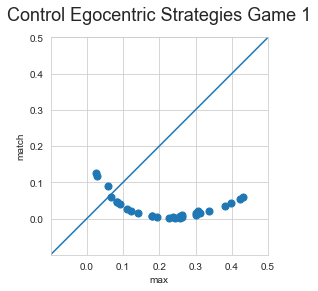

In [492]:
# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g1['max'], control_jsd_g1['match'], 1)

control_ego_jsd_g1_plot = control_jsd_g1.plot.scatter(x='max',y='match',s=50)
plt.title('Control Egocentric Strategies Game 1', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#add line of slope 1
plt.plot([0,1],[0,1], transform=plt.gca().transAxes)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('control_ego_jsd_1.jpeg',format='jpeg')
plt.show()

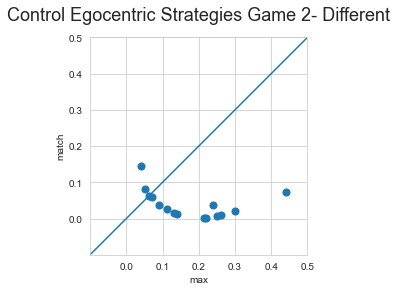

In [493]:
# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g2d['max'], control_jsd_g2d['match'], 1)

control_ego_jsd_g2d_plot = control_jsd_g2d.plot.scatter(x='max',y='match',s=50)
plt.title('Control Egocentric Strategies Game 2- Different', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

plt.plot([0,1],[0,1], transform=plt.gca().transAxes)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('control_ego_jsd_2d.jpg',format='jpg')
plt.show()

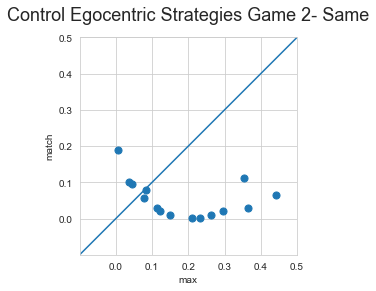

In [494]:
#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g2s['max'], control_jsd_g2s['match'], 1)

control_ego_jsd_g2s_plot = control_jsd_g2s.plot.scatter(x='max',y='match',s=50)
plt.title('Control Egocentric Strategies Game 2- Same', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

plt.plot([0,1],[0,1], transform=plt.gca().transAxes)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('control_ego_jsd_2s.jpg',format='jpg')
plt.show()

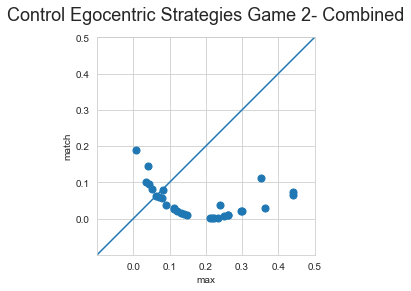

In [536]:
control_jsd_g2 = control_jsd_g2s.append(control_jsd_g2d)
#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g2['max'], control_jsd_g2['match'], 1)

control_ego_jsd_g2_plot = control_jsd_g2.plot.scatter(x='max',y='match',s=50)
plt.title('Control Egocentric Strategies Game 2- Combined', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

plt.plot([0,1],[0,1], transform=plt.gca().transAxes)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('control_ego_jsd_2.jpg',format='jpg')
plt.show()

In [495]:
sp.stats.ttest_ind(control_jsd_g1, control_jsd_g2s)

Ttest_indResult(statistic=array([ 1.03316934, -0.53859437, -1.16884678, -1.16884678]), pvalue=array([0.3073007 , 0.59294424, 0.24890451, 0.24890451]))

In [496]:
control_jsd_g2 = control_jsd_g2s.append(control_jsd_g2d)

In [497]:
sp.stats.ttest_ind(control_jsd_g2s,control_jsd_g2d)

Ttest_indResult(statistic=array([0.24298594, 0.89782292, 0.60806837, 0.60806837]), pvalue=array([0.80978755, 0.37693563, 0.54804316, 0.54804316]))

In [498]:
sp.stats.ttest_ind(control_jsd_g1,control_jsd_g2)

Ttest_indResult(statistic=array([ 1.495345  , -0.24314281, -1.04135064, -1.04135064]), pvalue=array([0.14024598, 0.80875264, 0.30203426, 0.30203426]))

# SMAB4 Joint Analysis

In [161]:
'''Here we load the csv files into Pandas dataframes by calling organize_trial_by_trial and get the score of each subject 
in each game by calling call_get_score.'''


df = organize_trial_by_trial('data/j01_gamedata.csv')
j01 = df
j01_p1_g1_score,j01_p1_g2_score,j01_p2_g1_score,j01_p2_g2_score,j01_p1_diff,j01_p2_diff,j01_p1_g1_50,j01_p1_g2_50,j01_p2_g1_50,j01_p2_g2_50= call_get_score(j01, 'j')
j01.head()

df = organize_trial_by_trial('data/j02_gamedata.csv')
j02 = df
j02_p1_g1_score,j02_p1_g2_score,j02_p2_g1_score,j02_p2_g2_score,j02_p1_diff,j02_p2_diff,j02_p1_g1_50,j02_p1_g2_50,j02_p2_g1_50,j02_p2_g2_50 = call_get_score(j02, 'j')
j02.head()


df = organize_trial_by_trial('data/j03_gamedata.csv')
j03 = df
j03_p1_g1_score,j03_p1_g2_score,j03_p2_g1_score,j03_p2_g2_score,j03_p1_diff,j03_p2_diff,j03_p1_g1_50,j03_p1_g2_50,j03_p2_g1_50,j03_p2_g2_50 = call_get_score(j03, 'j')
j03.head()


df = organize_trial_by_trial('data/j04_gamedata.csv')
j04 = df
j04_p1_g1_score,j04_p1_g2_score,j04_p2_g1_score,j04_p2_g2_score,j04_p1_diff,j04_p2_diff,j04_p1_g1_50,j04_p1_g2_50,j04_p2_g1_50,j04_p2_g2_50 = call_get_score(j04, 'j')
j04.head()


df = organize_trial_by_trial('data/j05_gamedata.csv')
j05 = df
j05_p1_g1_score,j05_p1_g2_score,j05_p2_g1_score,j05_p2_g2_score,j05_p1_diff,j05_p2_diff,j05_p1_g1_50,j05_p1_g2_50,j05_p2_g1_50,j05_p2_g2_50 = call_get_score(j05, 'j')
j05.head()


df = organize_trial_by_trial('data/j06_gamedata.csv')
j06 = df
j06_p1_g1_score,j06_p1_g2_score,j06_p2_g1_score,j06_p2_g2_score,j06_p1_diff,j06_p2_diff,j06_p1_g1_50,j06_p1_g2_50,j06_p2_g1_50,j06_p2_g2_50 = call_get_score(j06, 'j')
j06.head()


df = organize_trial_by_trial('data/j07_gamedata.csv')
j07 = df
j07_p1_g1_score,j07_p1_g2_score,j07_p2_g1_score,j07_p2_g2_score,j07_p1_diff,j07_p2_diff,j07_p1_g1_50,j07_p1_g2_50,j07_p2_g1_50,j07_p2_g2_50 = call_get_score(j07, 'j')
j07.head()


df = organize_trial_by_trial('data/j08_gamedata.csv')
j08 = df
j08_p1_g1_score,j08_p1_g2_score,j08_p2_g1_score,j08_p2_g2_score,j08_p1_diff,j08_p2_diff,j08_p1_g1_50,j08_p1_g2_50,j08_p2_g1_50,j08_p2_g2_50 = call_get_score(j08, 'j')
j08.head()


df = organize_trial_by_trial_300('data/j10_gamedata2.csv')
j10 = df
j10_p1_g1_score,j10_p1_g2_score,j10_p2_g1_score,j10_p2_g2_score,j10_p1_diff,j10_p2_diff,j10_p1_g1_50,j10_p1_g2_50,j10_p2_g1_50,j10_p2_g2_50 = call_get_score(j10, 'j')
j10.head()


df = organize_trial_by_trial_300('data/j11_gamedata2.csv')
j11 = df
j11_p1_g1_score,j11_p1_g2_score,j11_p2_g1_score,j11_p2_g2_score,j11_p1_diff,j11_p2_diff,j11_p1_g1_50,j11_p1_g2_50,j11_p2_g1_50,j11_p2_g2_50 = call_get_score(j11, 'j')
j11.head()

#NEED to add j12 to other analyses
''''df = organize_trial_by_trial_300('data/j12_gamedata_old.csv')
j12 = df
j12_p1_g1_score,j12_p1_g2_score,j12_p2_g1_score,j12_p2_g2_score,j12_p1_diff,j12_p2_diff,j12_p1_g1_50,j12_p1_g2_50,j12_p2_g1_50,j12_p2_g2_50 = call_get_score(j12, 'j')
j12.head()'''

"'df = organize_trial_by_trial_300('data/j12_gamedata_old.csv')\nj12 = df\nj12_p1_g1_score,j12_p1_g2_score,j12_p2_g1_score,j12_p2_g2_score,j12_p1_diff,j12_p2_diff,j12_p1_g1_50,j12_p1_g2_50,j12_p2_g1_50,j12_p2_g2_50 = call_get_score(j12, 'j')\nj12.head()"

In [162]:
'''Here we separate the dataframes by suject and game by calling separate_df. We also create arrays with the number of
times that each subject chose each hole by calling value_counts.'''

j01_p1_g1, j01_p1_g2, j01_p2_g1, j01_p2_g2 = separate_df(j01, 'j')
j02_p1_g1, j02_p1_g2, j02_p2_g1, j02_p2_g2 = separate_df(j02, 'j')
j03_p1_g1, j03_p1_g2, j03_p2_g1, j03_p2_g2 = separate_df(j03, 'j')
j04_p1_g1, j04_p1_g2, j04_p2_g1, j04_p2_g2 = separate_df(j04, 'j')
j05_p1_g1, j05_p1_g2, j05_p2_g1, j05_p2_g2 = separate_df(j05, 'j')
j06_p1_g1, j06_p1_g2, j06_p2_g1, j06_p2_g2 = separate_df(j06, 'j')
j07_p1_g1, j07_p1_g2, j07_p2_g1, j07_p2_g2 = separate_df(j07, 'j')
j08_p1_g1, j08_p1_g2, j08_p2_g1, j08_p2_g2 = separate_df(j08, 'j')
j10_p1_g1, j10_p1_g2, j10_p2_g1, j10_p2_g2 = separate_df(j10, 'j')
j11_p1_g1, j11_p1_g2, j11_p2_g1, j11_p2_g2 = separate_df(j11, 'j')



j01_p1_g1_count = j01_p1_g1['probability'].value_counts(sort=False)
j01_p1_g2_count = j01_p1_g2['probability'].value_counts(sort=False)
j01_p2_g1_count = j01_p2_g1['probability'].value_counts(sort=False)
j01_p2_g2_count = j01_p2_g2['probability'].value_counts(sort=False)
j02_p1_g1_count = j02_p1_g1['probability'].value_counts(sort=False)
j02_p1_g2_count = j02_p1_g2['probability'].value_counts(sort=False)
j02_p2_g1_count = j02_p2_g1['probability'].value_counts(sort=False)
j02_p2_g2_count = j02_p2_g2['probability'].value_counts(sort=False)
j03_p1_g1_count = j03_p1_g1['probability'].value_counts(sort=False)
j03_p1_g2_count = j03_p1_g2['probability'].value_counts(sort=False)
j03_p2_g1_count = j03_p2_g1['probability'].value_counts(sort=False)
j03_p2_g2_count = j03_p2_g2['probability'].value_counts(sort=False)
j04_p1_g1_count = j04_p1_g1['probability'].value_counts(sort=False)
j04_p1_g2_count = j04_p1_g2['probability'].value_counts(sort=False)
j04_p2_g1_count = j04_p2_g1['probability'].value_counts(sort=False)
j04_p2_g2_count = j04_p2_g2['probability'].value_counts(sort=False)
j05_p1_g1_count = j05_p1_g1['probability'].value_counts(sort=False)
j05_p1_g2_count = j05_p1_g2['probability'].value_counts(sort=False)
j05_p2_g1_count = j05_p2_g1['probability'].value_counts(sort=False)
j05_p2_g2_count = j05_p2_g2['probability'].value_counts(sort=False)
j06_p1_g1_count = j06_p1_g1['probability'].value_counts(sort=False)
j06_p1_g2_count = j06_p1_g2['probability'].value_counts(sort=False)
j06_p2_g1_count = j06_p2_g1['probability'].value_counts(sort=False)
j06_p2_g2_count = j06_p2_g2['probability'].value_counts(sort=False)
j07_p1_g1_count = j07_p1_g1['probability'].value_counts(sort=False)
j07_p1_g2_count = j07_p1_g2['probability'].value_counts(sort=False)
j07_p2_g1_count = j07_p2_g1['probability'].value_counts(sort=False)
j07_p2_g2_count = j07_p2_g2['probability'].value_counts(sort=False)
j08_p1_g1_count = j08_p1_g1['probability'].value_counts(sort=False)
j08_p1_g2_count = j08_p1_g2['probability'].value_counts(sort=False)
j08_p2_g1_count = j08_p2_g1['probability'].value_counts(sort=False)
j08_p2_g2_count = j08_p2_g2['probability'].value_counts(sort=False)
j10_p1_g1_count = j10_p1_g1['probability'].value_counts(sort=False)
j10_p1_g2_count = j10_p1_g2['probability'].value_counts(sort=False)
j10_p2_g1_count = j10_p2_g1['probability'].value_counts(sort=False)
j10_p2_g2_count = j10_p2_g2['probability'].value_counts(sort=False)
j11_p1_g1_count = j11_p1_g1['probability'].value_counts(sort=False)
j11_p1_g2_count = j11_p1_g2['probability'].value_counts(sort=False)
j11_p2_g1_count = j11_p2_g1['probability'].value_counts(sort=False)
j11_p2_g2_count = j11_p2_g2['probability'].value_counts(sort=False)

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python

In [163]:
'''Here we mech the hole-probability mappings in each game for each player'''
j01_p1_g1_map = hole_prob_map(j01_p1_g1)
j01_p1_g2_map = hole_prob_map(j01_p1_g2)
j01_p2_g1_map = hole_prob_map(j01_p2_g1)
j01_p2_g2_map = hole_prob_map(j01_p2_g2)

j02_p1_g1_map = hole_prob_map(j02_p1_g1)
j02_p1_g2_map = hole_prob_map(j02_p1_g2)
j02_p2_g1_map = hole_prob_map(j02_p2_g1)
j02_p2_g2_map = hole_prob_map(j02_p2_g2)

j03_p1_g1_map = hole_prob_map(j03_p1_g1)
j03_p1_g2_map = hole_prob_map(j03_p1_g2)
j03_p2_g1_map = hole_prob_map(j03_p2_g1)
j03_p2_g2_map = hole_prob_map(j03_p2_g2)

j04_p1_g1_map = hole_prob_map(j04_p1_g1)
j04_p1_g2_map = hole_prob_map(j04_p1_g2)
j04_p2_g1_map = hole_prob_map(j04_p2_g1)
j04_p2_g2_map = hole_prob_map(j04_p2_g2)

j05_p1_g1_map = hole_prob_map(j05_p1_g1)
j05_p1_g2_map = hole_prob_map(j05_p1_g2)
j05_p2_g1_map = hole_prob_map(j05_p2_g1)
j05_p2_g2_map = hole_prob_map(j05_p2_g2)

j06_p1_g1_map = hole_prob_map(j06_p1_g1)
j06_p1_g2_map = hole_prob_map(j06_p1_g2)
j06_p2_g1_map = hole_prob_map(j06_p2_g1)
j06_p2_g2_map = hole_prob_map(j06_p2_g2)

j07_p1_g1_map = hole_prob_map(j07_p1_g1)
j07_p1_g2_map = hole_prob_map(j07_p1_g2)
j07_p2_g1_map = hole_prob_map(j07_p2_g1)
j07_p2_g2_map = hole_prob_map(j07_p2_g2)

j08_p1_g1_map = hole_prob_map(j08_p1_g1)
j08_p1_g2_map = hole_prob_map(j08_p1_g2)
j08_p2_g1_map = hole_prob_map(j08_p2_g1)
j08_p2_g2_map = hole_prob_map(j08_p2_g2)

j10_p1_g1_map = hole_prob_map(j10_p1_g1)
j10_p1_g2_map = hole_prob_map(j10_p1_g2)
j10_p2_g1_map = hole_prob_map(j10_p2_g1)
j10_p2_g2_map = hole_prob_map(j10_p2_g2)

#j11_p1_g1_map = hole_prob_map(j11_p1_g1)
#j11_p1_g2_map = hole_prob_map(j11_p1_g2)
#j11_p2_g1_map = hole_prob_map(j11_p2_g1)
#j11_p2_g2_map = hole_prob_map(j11_p2_g2)

In [164]:
'''Here we create dataframes with all of the scores of each subject in games 1 and 2. 50 refers to the score half-way
through the games'''


# # Combined Joint scores G1

j_scores_1 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_1':
     [j01_p1_g1_score, j01_p2_g1_score, j02_p1_g1_score, j02_p2_g1_score, j03_p1_g1_score, j03_p2_g1_score,
      j04_p1_g1_score, j04_p2_g1_score, j05_p1_g1_score, j05_p2_g1_score, j06_p1_g1_score, j06_p2_g1_score,
      j07_p1_g1_score, j07_p2_g1_score, j08_p1_g1_score, j08_p2_g1_score, j10_p1_g1_score, j10_p2_g1_score, j11_p1_g1_score, j11_p2_g1_score]})
j_scores_1.set_index('participant', inplace=True, drop=True)
j_scores_1


# # Combined Joint scores G2

# In[ ]:


j_scores_2_d = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2'], 'score_2':
     [j01_p1_g2_score, j01_p2_g2_score, j02_p1_g2_score, j02_p2_g2_score, j03_p1_g2_score, j03_p2_g2_score,
      j04_p1_g2_score, j04_p2_g2_score, j05_p1_g2_score, j05_p2_g2_score, j06_p1_g2_score, j06_p2_g2_score,
      j07_p1_g2_score, j07_p2_g2_score, j08_p1_g2_score, j08_p2_g2_score]})
j_scores_2_d.set_index('participant', inplace=True, drop=True)

j_scores_2_s = pd.DataFrame({'participant':['j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_2':
     [j10_p1_g2_score, j10_p2_g2_score, j11_p1_g2_score, j11_p2_g2_score]})
j_scores_2_s.set_index('participant', inplace=True, drop=True)

j_scores_1_50 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_1_50':
     [j01_p1_g1_50, j01_p2_g1_50, j02_p1_g1_50, j02_p2_g1_50, j03_p1_g1_50, j03_p2_g1_50,
      j04_p1_g1_50, j04_p2_g1_50, j05_p1_g1_50, j05_p2_g1_50, j06_p1_g1_50, j06_p2_g1_50,
      j07_p1_g1_50, j07_p2_g1_50, j08_p1_g1_50, j08_p2_g1_50, j10_p1_g1_50, j10_p2_g1_50, j11_p1_g1_50, j11_p2_g1_50]})
j_scores_1_50.set_index('participant', inplace=True, drop=True)




j_scores_2_50 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_2_50':
     [j01_p1_g2_50, j01_p2_g2_50, j02_p1_g2_50, j02_p2_g2_50, j03_p1_g2_50, j03_p2_g2_50,
      j04_p1_g2_50, j04_p2_g2_50, j05_p1_g2_50, j05_p2_g2_50, j06_p1_g2_50, j06_p2_g2_50,
      j07_p1_g2_50, j07_p2_g2_50, j08_p1_g2_50, j08_p2_g2_50, j10_p1_g2_50, j10_p2_g2_50, j11_p1_g2_50, j11_p2_g2_50]})
j_scores_2_50.set_index('participant', inplace=True, drop=True)



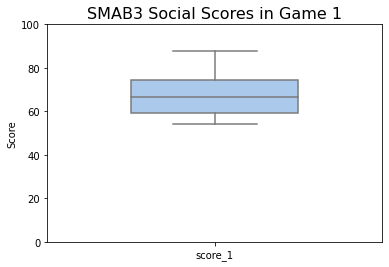

In [165]:
j_scores_1_box = sns.boxplot( 
                 data=j_scores_1, 
                 width=0.5,
                 palette="pastel")
j_scores_1_box.axes.set_title("SMAB3 Social Scores in Game 1",
                    fontsize=16)

plot_file_name="j_score_1_box.jpg"
 
plt.ylim(0, 100)
j_scores_1_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_1_box.figure.savefig(plot_file_name,
                    format='jpeg')

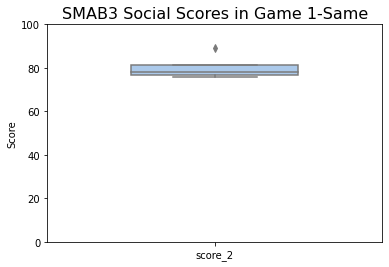

In [166]:
j_scores_2s_box = sns.boxplot( 
                 data=j_scores_2_s, 
                 width=0.5,
                 palette="pastel")
j_scores_2s_box.axes.set_title("SMAB3 Social Scores in Game 1-Same",
                    fontsize=16)

plot_file_name="j_score_2s_box.jpg"
 
plt.ylim(0, 100)
j_scores_2s_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_2s_box.figure.savefig(plot_file_name,
                    format='jpeg')

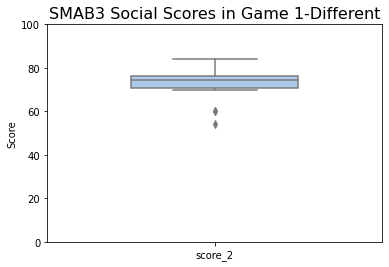

In [167]:
j_scores_2d_box = sns.boxplot( 
                 data=j_scores_2_d, 
                 width=0.5,
                 palette="pastel")
j_scores_2d_box.axes.set_title("SMAB3 Social Scores in Game 1-Different",
                    fontsize=16)

plot_file_name="j_score_2d_box.jpg"
 
plt.ylim(0, 100)
j_scores_2d_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_2d_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [168]:
j_scores_2s_mean = j_scores_2_s.mean()

In [169]:
j_scores_2d_mean = j_scores_2_d.mean()

In [170]:
j_scores_2s_std = j_scores_2_s.std()

In [171]:
j_scores_2d_std = j_scores_2_d.std()

In [172]:
j_scores_2s_mean, j_scores_2s_std

(score_2    80.25
 dtype: float64,
 score_2    5.965177
 dtype: float64)

In [173]:
j_scores_2d_mean, j_scores_2d_std

(score_2    72.6875
 dtype: float64,
 score_2    8.42788
 dtype: float64)

In [174]:
sp.stats.ttest_ind(j_scores_2_s, j_scores_2_d)

Ttest_indResult(statistic=array([1.67640168]), pvalue=array([0.11094111]))

In [175]:
s_scores_2_s.size

8

In [176]:
'''Here we get the mean, median, and standard deviation of the scores. We also run a t-test comparing the scores in games 1 and 2
and plot the data.'''

j_scores_1_mean = j_scores_1.mean()


# In[ ]:


j_scores_1_mean


# In[ ]:


j_scores_1_std = j_scores_1.std()


# In[ ]:


j_scores_1_std

score_1    9.653333
dtype: float64

In [177]:
#j_scores_p = sp.stats.ttest_rel(j_scores['Game 1'],j_scores['Game 2'])

In [178]:
len(j_scores_1)

20

In [179]:
'''
j_scores_box = sns.boxplot( 
                 data=j_scores, 
                 width=0.5,
                 palette="pastel")
j_scores_box.axes.set_title("SMAB3 Social Scores",
                    fontsize=16)

plot_file_name="j_score_box.jpg"
 
plt.ylim(0, 100)
j_scores_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')'''

'\nj_scores_box = sns.boxplot( \n                 data=j_scores, \n                 width=0.5,\n                 palette="pastel")\nj_scores_box.axes.set_title("SMAB3 Social Scores",\n                    fontsize=16)\n\nplot_file_name="j_score_box.jpg"\n \nplt.ylim(0, 100)\nj_scores_box.axes.set(ylabel=\'Score\')\n\n# save as jpeg\nj_scores_box.figure.savefig(plot_file_name,\n                    format=\'jpeg\')'

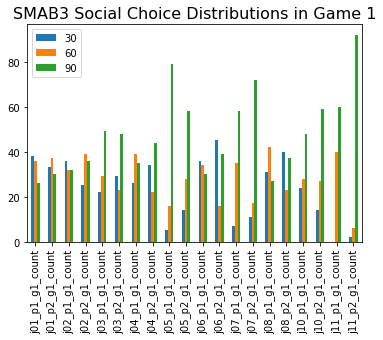

In [180]:
'''Here we place all of the data into the number of times each subject chose each hole into dataframes for games 1 
and 2. We plot this data and run statistics on it.'''

# # Joint combined choices in G1



j_g1_counts = pd.DataFrame([j01_p1_g1_count, j01_p2_g1_count, j02_p1_g1_count, j02_p2_g1_count, j03_p1_g1_count, 
              j03_p2_g1_count, j04_p1_g1_count, j04_p2_g1_count, j05_p1_g1_count, j05_p2_g1_count, j06_p1_g1_count, 
              j06_p2_g1_count, j07_p1_g1_count, j07_p2_g1_count, j08_p1_g1_count, j08_p2_g1_count, 
              j10_p1_g1_count, j10_p2_g1_count, j11_p1_g1_count, j11_p2_g1_count],
                index = ['j01_p1_g1_count', 'j01_p2_g1_count', 'j02_p1_g1_count', 'j02_p2_g1_count', 
                 'j03_p1_g1_count', 'j03_p2_g1_count', 'j04_p1_g1_count', 'j04_p2_g1_count', 'j05_p1_g1_count', 
                  'j05_p2_g1_count', 'j06_p1_g1_count', 'j06_p2_g1_count', 'j07_p1_g1_count', 
                    'j07_p2_g1_count', 'j08_p1_g1_count', 'j08_p2_g1_count', 'j10_p1_g1_count', 'j10_p2_g1_count', 
                    'j11_p1_g1_count', 'j11_p2_g1_count'])


# In[ ]:


j_g1_counts = j_g1_counts.fillna(0)


# In[ ]:


j_g1_counts 


# In[ ]:


j_g1_counts.sum(axis=1)


# In[ ]:


j_g1_counts_bar = j_g1_counts.plot.bar()

j_g1_counts_bar.axes.set_title("SMAB3 Social Choice Distributions in Game 1",
                    fontsize=16)

j_g1_counts_bar.figure.savefig("j_g1_counts_bar.jpg",
                    format='jpeg')

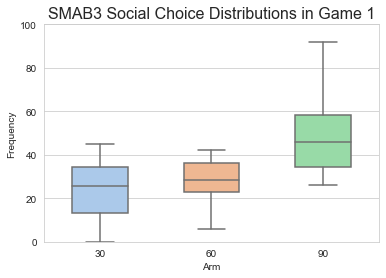

In [181]:
# In[ ]:
sns.set_style("whitegrid")

j_g1_counts_box = sns.boxplot( 
                 data=j_g1_counts, 
                 width=0.5,
                 palette="pastel")
j_g1_counts_box.axes.set_title("SMAB3 Social Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="j_g1_counts_box.jpg"
 
plt.ylim(0, 100)
j_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')


# In[ ]:

In [182]:
j_g1_low = np.mean(j_g1_counts.iloc[:,0])
j_g1_med = np.mean(j_g1_counts.iloc[:,1])
j_g1_high = np.mean(j_g1_counts.iloc[:,2])


# In[ ]:


j_g1_low


# In[ ]:


j_g1_med


# In[ ]:


j_g1_high


# In[ ]:


j_g1_low_std = np.std(j_g1_counts.iloc[:,0])
j_g1_med_std = np.std(j_g1_counts.iloc[:,1])
j_g1_high_std = np.std(j_g1_counts.iloc[:,2])


# In[ ]:


j_g1_low_std


# In[ ]:


j_g1_med_std


# In[ ]:


j_g1_high_std

17.746760267722106

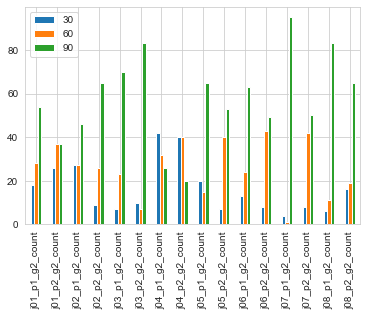

In [183]:
# # Joint combined choices in G2


j_g2_d_counts = pd.DataFrame([j01_p1_g2_count, j01_p2_g2_count, j02_p1_g2_count, j02_p2_g2_count, j03_p1_g2_count, 
              j03_p2_g2_count, j04_p1_g2_count, j04_p2_g2_count, j05_p1_g2_count, j05_p2_g2_count, j06_p1_g2_count, 
              j06_p2_g2_count, j07_p1_g2_count, j07_p2_g2_count, j08_p1_g2_count, j08_p2_g2_count],
                index = ['j01_p1_g2_count', 'j01_p2_g2_count', 'j02_p1_g2_count', 'j02_p2_g2_count', 
                 'j03_p1_g2_count', 'j03_p2_g2_count', 'j04_p1_g2_count', 'j04_p2_g2_count', 'j05_p1_g2_count', 
                  'j05_p2_g2_count', 'j06_p1_g2_count', 'j06_p2_g2_count', 'j07_p1_g2_count', 'j07_p2_g2_count', 
                 'j08_p1_g2_count', 'j08_p2_g2_count'])



j_g2_d_counts = j_g2_d_counts.fillna(0)



j_g2_d_counts.sum(axis=1)



j_g2_d_counts_bar = j_g2_d_counts.plot.bar()

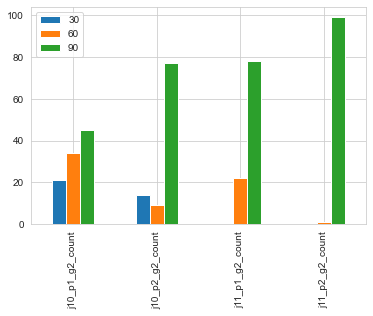

In [184]:
j_g2_s_counts = pd.DataFrame([j10_p1_g2_count, j10_p2_g2_count, j11_p1_g2_count, j11_p2_g2_count],
                index = ['j10_p1_g2_count', 'j10_p2_g2_count', 
                    'j11_p1_g2_count', 'j11_p2_g2_count'])



j_g2_s_counts = j_g2_s_counts.fillna(0)



j_g2_s_counts.sum(axis=1)



j_g2_s_counts_bar = j_g2_s_counts.plot.bar()

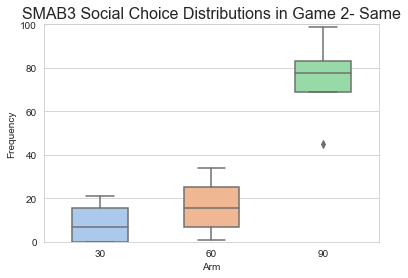

In [185]:
# In[ ]:


j_g2_s_counts_box = sns.boxplot( 
                 data=j_g2_s_counts, 
                 width=0.5,
                 palette="pastel")
j_g2_s_counts_box.axes.set_title("SMAB3 Social Choice Distributions in Game 2- Same",
                    fontsize=16)

plot_file_name="j_g2_s_counts_box.jpg"
 
plt.ylim(0, 100)
j_g2_s_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g2_s_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

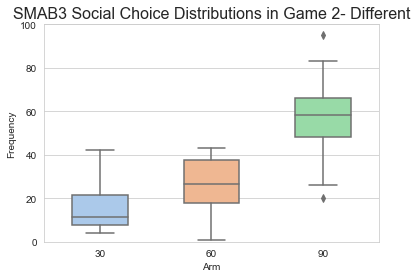

In [186]:
j_g2_d_counts_box = sns.boxplot( 
                 data=j_g2_d_counts, 
                 width=0.5,
                 palette="pastel")
j_g2_d_counts_box.axes.set_title("SMAB3 Social Choice Distributions in Game 2- Different",
                    fontsize=16)

plot_file_name="j_g2_d_counts_box.jpg"
 
plt.ylim(0, 100)
j_g2_d_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g2_d_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [187]:
j_scores_1

,score_1
participant,
j01_p1,57
j01_p2,61
j02_p1,54
j02_p2,68
j03_p1,69
j03_p2,67
j04_p1,64
j04_p2,56
j05_p1,77


In [188]:
j_scores_1_mean

score_1    66.85
dtype: float64

In [189]:
j_scores_1_std

score_1    9.653333
dtype: float64

In [190]:
# In[ ]:

j_g1_low = np.mean(j_g1_counts.iloc[:,0])
j_g1_med = np.mean(j_g1_counts.iloc[:,1])
j_g1_high = np.mean(j_g1_counts.iloc[:,2])

j_g2_s_low = np.mean(j_g2_s_counts.iloc[:,0])
j_g2_s_med = np.mean(j_g2_s_counts.iloc[:,1])
j_g2_s_high = np.mean(j_g2_s_counts.iloc[:,2])

j_g2_d_low = np.mean(j_g2_d_counts.iloc[:,0])
j_g2_d_med = np.mean(j_g2_d_counts.iloc[:,1])
j_g2_d_high = np.mean(j_g2_d_counts.iloc[:,2])

In [191]:
j_g1_low, j_g1_med, j_g1_high

(23.6, 28.45, 47.95)

In [192]:
j_g1_low_std, j_g1_med_std, j_g1_high_std

(13.268006632497586, 9.499868420141407, 17.746760267722106)

In [193]:
j_g1_counts

,30,60,90
j01_p1_g1_count,38.0,36.0,26.0
j01_p2_g1_count,33.0,37.0,30.0
j02_p1_g1_count,36.0,32.0,32.0
j02_p2_g1_count,25.0,39.0,36.0
j03_p1_g1_count,22.0,29.0,49.0
j03_p2_g1_count,29.0,23.0,48.0
j04_p1_g1_count,26.0,39.0,35.0
j04_p2_g1_count,34.0,22.0,44.0
j05_p1_g1_count,5.0,16.0,79.0
j05_p2_g1_count,14.0,28.0,58.0


# Reaction Time

In [194]:
'Here we get the reaction times'
time_j_1 = pd.DataFrame(columns = ['session','post win','post loss'])
time_j_2 = pd.DataFrame(columns = ['session','post win','post loss'])

In [195]:
time_j_1 = reaction_time(j01_p1_g1, time_j_1)
time_j_1 = reaction_time(j02_p1_g1, time_j_1)
time_j_1 = reaction_time(j03_p1_g1, time_j_1)
time_j_1 = reaction_time(j04_p1_g1, time_j_1)
time_j_1 = reaction_time(j05_p1_g1, time_j_1)
time_j_1 = reaction_time(j06_p1_g1, time_j_1)
time_j_1 = reaction_time(j07_p1_g1, time_j_1)
time_j_1 = reaction_time(j08_p1_g1, time_j_1)
time_j_1 = reaction_time(j10_p1_g1, time_j_1)
time_j_1 = reaction_time(j11_p1_g1, time_j_1)

In [196]:
time_j_2 = reaction_time(j01_p1_g2, time_j_2)
time_j_2 = reaction_time(j02_p1_g2, time_j_2)
time_j_2 = reaction_time(j03_p1_g2, time_j_2)
time_j_2 = reaction_time(j04_p1_g2, time_j_2)
time_j_2 = reaction_time(j05_p1_g2, time_j_2)
time_j_2 = reaction_time(j06_p1_g2, time_j_2)
time_j_2 = reaction_time(j07_p1_g2, time_j_2)
time_j_2 = reaction_time(j08_p1_g2, time_j_2)
time_j_2 = reaction_time(j10_p1_g2, time_j_2)
time_j_2 = reaction_time(j11_p1_g2, time_j_2)

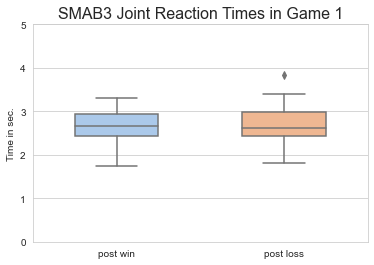

In [197]:
times_j_g1_box = sns.boxplot( 
                 data=time_j_1, 
                 width=0.5,
                 palette="pastel")
times_j_g1_box.axes.set_title("SMAB3 Joint Reaction Times in Game 1",
                    fontsize=16)

plot_file_name="times_j_g1_box.jpg"
 
plt.ylim(0, 5)
times_j_g1_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_j_g1_box.figure.savefig(plot_file_name,format='jpeg')

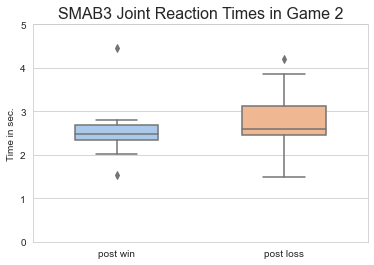

In [198]:
times_j_g2_box = sns.boxplot( 
                 data=time_j_2, 
                 width=0.5,
                 palette="pastel")
times_j_g2_box.axes.set_title("SMAB3 Joint Reaction Times in Game 2",
                    fontsize=16)

plot_file_name="times_j_g2_box.jpg"
 
plt.ylim(0, 5)
times_j_g2_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_j_g2_box.figure.savefig(plot_file_name,format='jpeg')

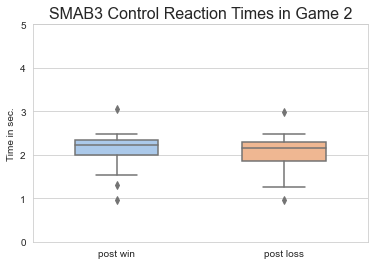

In [199]:
times_s_g2_box = sns.boxplot( 
                 data=time_s_2, 
                 width=0.5,
                 palette="pastel")
times_s_g2_box.axes.set_title("SMAB3 Control Reaction Times in Game 2",
                    fontsize=16)

plot_file_name="times_s_g2_box.jpg"
 
plt.ylim(0, 5)
times_s_g2_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_s_g2_box.figure.savefig(plot_file_name,format='jpeg')

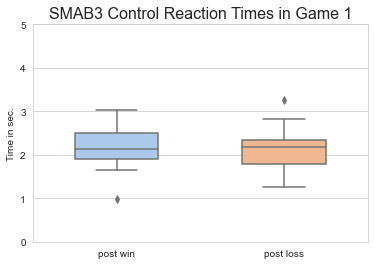

In [200]:
times_s_g1_box = sns.boxplot( 
                 data=time_s_1, 
                 width=0.5,
                 palette="pastel")
times_s_g1_box.axes.set_title("SMAB3 Control Reaction Times in Game 1",
                    fontsize=16)

plot_file_name="times_s_g1_box.jpg"
 
plt.ylim(0, 5)
times_s_g1_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_s_g1_box.figure.savefig(plot_file_name,format='jpeg')

In [201]:
np.mean(time_s_1)

post win     2.143281
post loss    2.156833
dtype: float64

In [202]:
np.mean(time_s_2)

post win     2.095491
post loss    2.040904
dtype: float64

In [203]:
np.std(time_s_1)

post win     0.501875
post loss    0.504602
dtype: float64

In [204]:
np.std(time_s_2)

post win     0.539784
post loss    0.528833
dtype: float64

In [205]:
np.mean(time_j_1)

post win     3.003842
post loss    2.743744
dtype: float64

In [206]:
np.mean(time_j_2)

post win     2.571192
post loss    2.772587
dtype: float64

In [207]:
np.std(time_j_1)

post win     1.287668
post loss    0.547701
dtype: float64

In [208]:
np.std(time_j_2)

post win     0.715499
post loss    0.768199
dtype: float64

In [209]:
sp.stats.ttest_rel(time_s_1['post win'],time_s_1['post loss'])

Ttest_relResult(statistic=-0.22232713395530926, pvalue=0.8277981973516864)

In [210]:
sp.stats.ttest_rel(time_s_2['post win'],time_s_2['post loss'])

Ttest_relResult(statistic=1.6133551404642006, pvalue=0.1349630881166298)

In [211]:
sp.stats.ttest_rel(time_j_1['post win'],time_j_1['post loss'])

Ttest_relResult(statistic=0.8796229730498023, pvalue=0.40193938606783575)

In [212]:
sp.stats.ttest_rel(time_j_2['post win'],time_j_2['post loss'])

Ttest_relResult(statistic=-1.240209628973232, pvalue=0.24625663257219957)

# SMAB4 Joint Data 

In [213]:
'''Here we load the csv files into pandas dataframes by calling organize_trial_by_trial and get the scores in games
1 and 2 by calling call_get_score.
Note: for the files that were hand coded, the scores will be obtained later, as the score column needs to be filled out still.'''

# # Multi Analysis

df = organize_trial_by_trial_hand_code2('data/m01_gamedata_handcode.csv')
m01 = df
#m01_p1_g1_score,m01_p1_g2_score,m01_p2_g1_score,m01_p2_g2_score,m01_p1_diff,m01_p2_diff,m01_p1_g1_50,m01_p1_g2_50,m01_p2_g1_50,m01_p2_g2_50 = call_get_score(m01, 'm')
m01.head()

df = organize_trial_by_trial_hand_code2('data/m03_gamedata_handcode.csv')
m03 = df
#m01_p1_g1_score,m01_p1_g2_score,m01_p2_g1_score,m01_p2_g2_score,m01_p1_diff,m01_p2_diff,m01_p1_g1_50,m01_p1_g2_50,m01_p2_g1_50,m01_p2_g2_50 = call_get_score(m01, 'm')
m03.head()

df = organize_trial_by_trial('data/m05_gamedata.csv')
m05 = df
m05_p1_g1_score,m05_p1_g2_score,m05_p2_g1_score,m05_p2_g2_score,m05_p1_diff,m05_p2_diff,m05_p1_g1_50,m05_p1_g2_50,m05_p2_g1_50,m05_p2_g2_50 = call_get_score(m05, 'm')
m05.head()


# In[ ]:


df = organize_trial_by_trial_300('data/m06_gamedata2.csv')
m06 = df
m06_p1_g1_score,m06_p1_g2_score,m06_p2_g1_score,m06_p2_g2_score,m06_p1_diff,m06_p2_diff,m06_p1_g1_50,m06_p1_g2_50,m06_p2_g1_50,m06_p2_g2_50 = call_get_score(m06, 'm')
m06.head()


df = organize_trial_by_trial_hand_code2('data/m07_gamedata_handcode.csv')
m07 = df
#m01_p1_g1_score,m01_p1_g2_score,m01_p2_g1_score,m01_p2_g2_score,m01_p1_diff,m01_p2_diff,m01_p1_g1_50,m01_p1_g2_50,m01_p2_g1_50,m01_p2_g2_50 = call_get_score(m01, 'm')
m07.head()

#NOTE: m09 from LSL needs to be combined with hand coded data because the lsl csv file is missing the first 13 trials
df = organize_trial_by_trial_hand_code('data/m09_gamedata_handcode.csv')
m09 = df
#m01_p1_g1_score,m01_p1_g2_score,m01_p2_g1_score,m01_p2_g2_score,m01_p1_diff,m01_p2_diff,m01_p1_g1_50,m01_p1_g2_50,m01_p2_g1_50,m01_p2_g2_50 = call_get_score(m01, 'm')
m09.head()

df = organize_trial_by_trial_300('data/m09_gamedata_300.csv')
m09_lsl = df
#m08_p1_g1_score,m08_p1_g2_score,m08_p2_g1_score,m08_p2_g2_score,m08_p1_diff,m08_p2_diff,m08_p1_g1_50,m08_p1_g2_50,m08_p2_g1_50,m08_p2_g2_50 = call_get_score(m08, 'm')
#combine m09 and m09_lsl
m09 = m09

df = organize_trial_by_trial_300('data/m08_gamedata2.csv')
m08 = df
m08_p1_g1_score,m08_p1_g2_score,m08_p2_g1_score,m08_p2_g2_score,m08_p1_diff,m08_p2_diff,m08_p1_g1_50,m08_p1_g2_50,m08_p2_g1_50,m08_p2_g2_50 = call_get_score(m08, 'm')
m08.head()


# In[ ]:


# In[ ]:


df = organize_trial_by_trial_300('data/m10_gamedata2.csv')
m10 = df
m10_p1_g1_score,m10_p1_g2_score,m10_p2_g1_score,m10_p2_g2_score,m10_p1_diff,m10_p2_diff,m10_p1_g1_50,m10_p1_g2_50,m10_p2_g1_50,m10_p2_g2_50 = call_get_score(m10, 'm')
m10.head()


# In[ ]:


df = organize_trial_by_trial_300('data/m11_gamedata2.csv')
m11 = df
m11_p1_g1_score,m11_p1_g2_score,m11_p2_g1_score,m11_p2_g2_score,m11_p1_diff,m11_p2_diff,m11_p1_g1_50,m11_p1_g2_50,m11_p2_g1_50,m11_p2_g2_50 = call_get_score(m11, 'm')
m11.head()


# In[ ]:

#session ends early
#df = organize_trial_by_trial_floatclick('data/m12_gamedata.csv')
#m12 = df
#m12_p1_g1_score,m12_p1_g2_score,m12_p2_g1_score,m12_p2_g2_score,m12_p1_score_diff,m12_p2_score_diff = call_get_score(m12, 'm')
#m12.head()


# In[ ]:


df = organize_trial_by_trial_300('data/m13_gamedata2.csv')
m13 = df
m13_p1_g1_score,m13_p1_g2_score,m13_p2_g1_score,m13_p2_g2_score,m13_p1_diff,m13_p2_diff,m13_p1_g1_50,m13_p1_g2_50,m13_p2_g1_50,m13_p2_g2_50 = call_get_score(m13, 'm')
m13.head()


# In[ ]:


df = organize_trial_by_trial_300('data/m14_gamedata2.csv')
m14 = df
m14_p1_g1_score,m14_p1_g2_score,m14_p2_g1_score,m14_p2_g2_score,m14_p1_diff,m14_p2_diff,m14_p1_g1_50,m14_p1_g2_50,m14_p2_g1_50,m14_p2_g2_50 = call_get_score(m14, 'm')
m14.head()


# In[ ]:


m05_p1_g1, m05_p1_g2, m05_p2_g1, m05_p2_g2 = separate_df(m05, 'm')
m06_p1_g1, m06_p1_g2, m06_p2_g1, m06_p2_g2 = separate_df(m06, 'm')
m07_p1_g1, m07_p1_g2, m07_p2_g1, m07_p2_g2 = separate_df(m07, 'm')
m08_p1_g1, m08_p1_g2, m08_p2_g1, m08_p2_g2 = separate_df(m08, 'm')
m10_p1_g1, m10_p1_g2, m10_p2_g1, m10_p2_g2 = separate_df(m10, 'm')
m11_p1_g1, m11_p1_g2, m11_p2_g1, m11_p2_g2 = separate_df(m11, 'm')
m13_p1_g1, m13_p1_g2, m13_p2_g1, m13_p2_g2 = separate_df(m13, 'm')

m14_p1_g1, m14_p1_g2, m14_p2_g1, m14_p2_g2 = separate_df(m14, 'm')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python

In [214]:
m01_p1_counts, m01_p2_counts, m01_p1_probs, m01_p2_probs = handcode_calc_prob(m01)
m03_p1_counts, m03_p2_counts, m03_p1_probs, m03_p2_probs = handcode_calc_prob(m03)
m07_p1_counts, m07_p2_counts, m07_p1_probs, m07_p2_probs = handcode_calc_prob(m07)

In [215]:
m01_p1_counts

,g1_p1_h1_count,g1_p1_h2_count,g1_p1_h3_count,g2_p1_h1_count,g2_p1_h2_count,g2_p1_h3_count
rewarded,26,29,12,4,6,69
non-rewarded,3,9,9,4,9,9


In [216]:
m01_p2_counts

,g1_p2_h1_count,g1_p2_h2_count,g1_p2_h3_count,g2_p2_h1_count,g2_p2_h2_count,g2_p2_h3_count
rewarded,9,15,35,12,47,10
non-rewarded,24,13,13,8,2,2


In [217]:
m01_p1_probs

,p1_h1,p1_h2,p1_h3
game 1,89.655172,76.315789,57.142857
game 2,50.000000,40.000000,88.461538


In [218]:
m01_p2_probs

,p2_h1,p1_h2,p1_h3
game 1,27.272727,53.571429,72.916667
game 2,60.000000,95.918367,83.333333


In [219]:
m03_p1_counts

,g1_p1_h1_count,g1_p1_h2_count,g1_p1_h3_count,g2_p1_h1_count,g2_p1_h2_count,g2_p1_h3_count
rewarded,10,29,22,19,7,31
non-rewarded,14,2,2,1,27,27


In [220]:
m03_p2_counts

,g1_p2_h1_count,g1_p2_h2_count,g1_p2_h3_count,g2_p2_h1_count,g2_p2_h2_count,g2_p2_h3_count
rewarded,37,13,15,11,27,16
non-rewarded,3,24,24,34,5,5


In [221]:
m03_p1_probs

,p1_h1,p1_h2,p1_h3
game 1,41.666667,93.548387,91.666667
game 2,95.000000,20.588235,53.448276


In [222]:
m03_p2_probs

,p2_h1,p1_h2,p1_h3
game 1,92.500000,35.135135,38.461538
game 2,24.444444,84.375000,76.190476


In [223]:
m01 = fill_in_prob(m01,90,60,30,60,30,90,30,60,90,60,90,30)
m03 = fill_in_prob(m03,30,90,60,90,30,60,90,30,60,30,90,60)

In [224]:
m01_p1_g1, m01_p1_g2, m01_p2_g1, m01_p2_g2 = separate_df(m01, 'm')
m03_p1_g1, m03_p1_g2, m03_p2_g1, m03_p2_g2 = separate_df(m03, 'm')
m07_p1_g1, m07_p1_g2, m07_p2_g1, m07_p2_g2 = separate_df(m07, 'm')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python

In [225]:
m01_p1_g1_score = m01_p1_g1['reward'].sum()
m01_p1_g2_score = m01_p1_g2['reward'].sum()
m01_p2_g1_score = m01_p2_g1['reward'].sum()
m01_p2_g2_score = m01_p2_g2['reward'].sum()

m03_p1_g1_score = m03_p1_g1['reward'].sum()
m03_p1_g2_score = m03_p1_g2['reward'].sum()
m03_p2_g1_score = m03_p2_g1['reward'].sum()
m03_p2_g2_score = m03_p2_g2['reward'].sum()

m07_p1_g1_score = m07_p1_g1['reward'].sum()
m07_p1_g2_score = m07_p1_g2['reward'].sum()
m07_p2_g1_score = m07_p2_g1['reward'].sum()
m07_p2_g2_score = m07_p2_g2['reward'].sum()

In [226]:
# In[ ]:
#Not working for m01 and m07 (hand coded)- need to fill in the probability column
m01_p1_g1_count = m01_p1_g1['probability'].value_counts(sort=False)
m01_p1_g2_count = m01_p1_g2['probability'].value_counts(sort=False)
m01_p2_g1_count = m01_p2_g1['probability'].value_counts(sort=False)
m01_p2_g2_count = m01_p2_g2['probability'].value_counts(sort=False)
m03_p1_g1_count = m03_p1_g1['probability'].value_counts(sort=False)
m03_p1_g2_count = m03_p1_g2['probability'].value_counts(sort=False)
m03_p2_g1_count = m03_p2_g1['probability'].value_counts(sort=False)
m03_p2_g2_count = m03_p2_g2['probability'].value_counts(sort=False)

m05_p1_g1_count = m05_p1_g1['probability'].value_counts(sort=False)
m05_p1_g2_count = m05_p1_g2['probability'].value_counts(sort=False)
m05_p2_g1_count = m05_p2_g1['probability'].value_counts(sort=False)
m05_p2_g2_count = m05_p2_g2['probability'].value_counts(sort=False)

m07_p1_g1_count = m07_p1_g1['probability'].value_counts(sort=False)
m07_p1_g2_count = m07_p1_g2['probability'].value_counts(sort=False)
m07_p2_g1_count = m07_p2_g1['probability'].value_counts(sort=False)
m07_p2_g2_count = m07_p2_g2['probability'].value_counts(sort=False)

In [227]:
'''Here we check the probability-hole mappings for each player in each game'''
#m07,m06, and m09 are excluded from further analyses because the hole probability matchings are incorrect for those sessions
m01_p1_g1_map = hole_prob_map(m01_p1_g1)
m01_p1_g2_map = hole_prob_map(m01_p1_g2)
m01_p2_g1_map = hole_prob_map(m01_p2_g1)

m03_p2_g2_map = hole_prob_map(m03_p2_g2)
m03_p1_g1_map = hole_prob_map(m03_p1_g1)
m03_p1_g2_map = hole_prob_map(m03_p1_g2)
m03_p2_g1_map = hole_prob_map(m03_p2_g1)
m03_p2_g2_map = hole_prob_map(m03_p2_g2)

m05_p1_g1_map = hole_prob_map(m05_p1_g1)
m05_p1_g2_map = hole_prob_map(m05_p1_g2)
m05_p2_g1_map = hole_prob_map(m05_p2_g1)
m05_p2_g2_map = hole_prob_map(m05_p2_g2)

m06_p1_g1_map = hole_prob_map(m06_p1_g1)
m06_p1_g2_map = hole_prob_map(m06_p1_g2)
m06_p2_g1_map = hole_prob_map(m06_p2_g1)
m06_p2_g2_map = hole_prob_map(m06_p2_g2)

m07_p1_g1_map = hole_prob_map(m07_p1_g1)
#m07_p1_g2_map = hole_prob_map(m07_p1_g2)
m07_p2_g1_map = hole_prob_map(m07_p2_g1)
#m07_p2_g2_map = hole_prob_map(m07_p2_g2)

m08_p1_g1_map = hole_prob_map(m08_p1_g1)
m08_p1_g2_map = hole_prob_map(m08_p1_g2)
m08_p2_g1_map = hole_prob_map(m08_p2_g1)
m08_p2_g2_map = hole_prob_map(m08_p2_g2)

m10_p1_g1_map = hole_prob_map(m10_p1_g1)
m10_p1_g2_map = hole_prob_map(m10_p1_g2)
m10_p2_g1_map = hole_prob_map(m10_p2_g1)
m10_p2_g2_map = hole_prob_map(m10_p2_g2)

m11_p1_g1_map = hole_prob_map(m11_p1_g1)
#m11_p1_g2_map = hole_prob_map(m11_p1_g2)
m11_p2_g1_map = hole_prob_map(m11_p2_g1)
#m11_p2_g2_map = hole_prob_map(m11_p2_g2)

m13_p1_g1_map = hole_prob_map(m13_p1_g1)
m13_p1_g2_map = hole_prob_map(m13_p1_g2)
m13_p2_g1_map = hole_prob_map(m13_p2_g1)
m13_p2_g2_map = hole_prob_map(m13_p2_g2)

In [228]:
m08_p1_g1_map, m08_p2_g1_map

(   h1_prob  h2_prob  h3_prob
 0       30       60       90,
    h1_prob  h2_prob  h3_prob
 0       90       60       30)

In [229]:
#same_probs_g1_2
m06_p1_g1_count = m06_p1_g1['probability'].value_counts(sort=False)
m06_p1_g2_count = m06_p1_g2['probability'].value_counts(sort=False)
m06_p2_g1_count = m06_p2_g1['probability'].value_counts(sort=False)
m06_p2_g2_count = m06_p2_g2['probability'].value_counts(sort=False)
m07_p1_g1_count = m07_p1_g1['probability'].value_counts(sort=False)
m07_p1_g2_count = m07_p1_g2['probability'].value_counts(sort=False)
m07_p2_g1_count = m07_p2_g1['probability'].value_counts(sort=False)
m07_p2_g2_count = m07_p2_g2['probability'].value_counts(sort=False)
m08_p1_g1_count = m08_p1_g1['probability'].value_counts(sort=False)
m08_p1_g2_count = m08_p1_g2['probability'].value_counts(sort=False)
m08_p2_g1_count = m08_p2_g1['probability'].value_counts(sort=False)
m08_p2_g2_count = m08_p2_g2['probability'].value_counts(sort=False)
m10_p1_g1_count = m10_p1_g1['probability'].value_counts(sort=False)
m10_p1_g2_count = m10_p1_g2['probability'].value_counts(sort=False)
m10_p2_g1_count = m10_p2_g1['probability'].value_counts(sort=False)
m10_p2_g2_count = m10_p2_g2['probability'].value_counts(sort=False)
m11_p1_g1_count = m11_p1_g1['probability'].value_counts(sort=False)
m11_p1_g2_count = m11_p1_g2['probability'].value_counts(sort=False)
m11_p2_g1_count = m11_p2_g1['probability'].value_counts(sort=False)
m11_p2_g2_count = m11_p2_g2['probability'].value_counts(sort=False)
m13_p1_g1_count = m13_p1_g1['probability'].value_counts(sort=False)
m13_p1_g2_count = m13_p1_g2['probability'].value_counts(sort=False)
m13_p2_g1_count = m13_p2_g1['probability'].value_counts(sort=False)
m13_p2_g2_count = m13_p2_g2['probability'].value_counts(sort=False)
m14_p1_g1_count = m14_p1_g1['probability'].value_counts(sort=False)
m14_p1_g2_count = m14_p1_g2['probability'].value_counts(sort=False)
m14_p2_g1_count = m14_p2_g1['probability'].value_counts(sort=False)
m14_p2_g2_count = m14_p2_g2['probability'].value_counts(sort=False)

In [230]:
#call fix_reward on all of the files imported with '300' to fix the reward column
m06_p1_g1 = fix_reward(m06_p1_g1)
m06_p1_g2 = fix_reward(m06_p1_g2)
m06_p2_g1 = fix_reward(m06_p2_g1)
m06_p2_g2 = fix_reward(m06_p2_g2)
m08_p1_g1 = fix_reward(m08_p1_g1)
m08_p1_g2 = fix_reward(m08_p1_g2)
m08_p2_g1 = fix_reward(m08_p2_g1)
m08_p2_g2 = fix_reward(m08_p2_g2)
m10_p1_g1 = fix_reward(m10_p1_g1)
m10_p1_g2 = fix_reward(m10_p1_g2)
m10_p2_g1 = fix_reward(m10_p2_g1)
m10_p2_g2 = fix_reward(m10_p2_g2)
m11_p1_g1 = fix_reward(m11_p1_g1)
m11_p1_g2 = fix_reward(m11_p1_g2)
m11_p2_g1 = fix_reward(m11_p2_g1)
m11_p2_g2 = fix_reward(m11_p2_g2)
m13_p1_g1 = fix_reward(m13_p1_g1)
m13_p1_g2 = fix_reward(m13_p1_g2)
m13_p2_g1 = fix_reward(m13_p2_g1)
m13_p2_g2 = fix_reward(m13_p2_g2)
m14_p1_g1 = fix_reward(m14_p1_g1)
m14_p1_g2 = fix_reward(m14_p1_g2)
m14_p2_g1 = fix_reward(m14_p2_g1)
m14_p2_g2 = fix_reward(m14_p2_g2)

In [231]:
# # Combined multi scores G1

# In[ ]:


m_scores_1 = pd.DataFrame({'participant':['m01_p1','m01_p2', 'm03_p1', 'm03_p2','m05_p1', 'm05_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1':
     [m01_p1_g1_score, m01_p2_g1_score, m03_p1_g1_score, m03_p2_g1_score, m05_p1_g1_score, m05_p2_g1_score, m08_p1_g1_score, m08_p2_g1_score,
      m10_p1_g1_score, m10_p2_g1_score, m11_p1_g1_score, m11_p2_g1_score, m13_p1_g1_score, m13_p2_g1_score,
      m14_p1_g1_score, m14_p2_g1_score]})
m_scores_1.set_index('participant', inplace=True, drop=True)
m_scores_1

,score_1
participant,
m01_p1,67
m01_p2,59
m03_p1,61
m03_p2,65
m05_p1,86
m05_p2,75
m08_p1,69
m08_p2,83
m10_p1,69


In [232]:
# # Combined multi scores G2

# In[ ]:

#NEEDS TO BE SEPARATED
m_scores_2_d = pd.DataFrame({'participant':['m01_p1', 'm01_p2','m03_p1','m03_p2','m05_p1','m05_p2'], 'score_2':
     [m01_p1_g2_score, m01_p2_g2_score, m03_p1_g2_score, m03_p2_g2_score, m05_p1_g2_score, m05_p2_g2_score]})
m_scores_2_d.set_index('participant', inplace=True, drop=True)

m_scores_2_s = pd.DataFrame({'participant':['m08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_2':
     [m08_p1_g2_score, m08_p2_g2_score,
      m10_p1_g2_score, m10_p2_g2_score, m11_p1_g2_score, m11_p2_g2_score, m13_p1_g2_score, m13_p2_g2_score,
      m14_p1_g2_score, m14_p2_g2_score]})
m_scores_2_s.set_index('participant', inplace=True, drop=True)


#NEEDS TO BE REVISITED, add 50 to hand coded sessions
'''m_scores_1_50 = pd.DataFrame({'participant':['m01_p1','m01_p2', 'm03_p1', 'm03_p2','m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm07_p1', 'm07_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1_50':
     [m01_p1_g1_50, m01_p2_g1_50, m03_p1_g1_50, m03_p2_g1_50, m05_p1_g1_50, m05_p2_g1_50, m06_p1_g1_50, m06_p2_g1_50, m07_p1_g1_50, m07_p2_g1_50, m08_p1_g1_50, m08_p2_g1_50, m10_p1_g1_50, m10_p2_g1_50, m11_p1_g1_50, m11_p2_g1_50, m13_p1_g1_50, m13_p2_g1_50,
     m14_p1_g1_50, m14_p2_g1_50,]})
m_scores_1_50.set_index('participant', inplace=True, drop=True)

#NEEDS TO BE SEPARATED
m_scores_2_50 = pd.DataFrame({'participant':['m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm07_p1', 'm07_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1_50':
     [m01_p1_g2_50, m01_p2_g2_50, m03_p1_g2_50, m03_p2_g2_50, m05_p1_g2_50, m05_p2_g2_50, m06_p1_g2_50, m06_p2_g2_50, m07_p1_g2_50, m07_p2_g2_50, m08_p1_g2_50, m08_p2_g2_50, m10_p1_g2_50, m10_p2_g2_50, m11_p1_g2_50, m11_p2_g2_50, m13_p1_g2_50, m13_p2_g2_50,
     m14_p1_g2_50, m14_p2_g2_50,]})
m_scores_2_50.set_index('participant', inplace=True, drop=True)'''

"m_scores_1_50 = pd.DataFrame({'participant':['m01_p1','m01_p2', 'm03_p1', 'm03_p2','m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm07_p1', 'm07_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1_50':\n     [m01_p1_g1_50, m01_p2_g1_50, m03_p1_g1_50, m03_p2_g1_50, m05_p1_g1_50, m05_p2_g1_50, m06_p1_g1_50, m06_p2_g1_50, m07_p1_g1_50, m07_p2_g1_50, m08_p1_g1_50, m08_p2_g1_50, m10_p1_g1_50, m10_p2_g1_50, m11_p1_g1_50, m11_p2_g1_50, m13_p1_g1_50, m13_p2_g1_50,\n     m14_p1_g1_50, m14_p2_g1_50,]})\nm_scores_1_50.set_index('participant', inplace=True, drop=True)\n\n#NEEDS TO BE SEPARATED\nm_scores_2_50 = pd.DataFrame({'participant':['m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm07_p1', 'm07_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1_50':\n     [m01_p1_g2_50, m01_p2_g2_50, m03_p1_g2_50, m03_p2_g2_50, m05_p1_g2_50, m05_p2_g2_50, m06_p1_g2_50, m06_p2_g2_50, m07_p1_g2_50, m0

In [233]:
m_scores_1

,score_1
participant,
m01_p1,67
m01_p2,59
m03_p1,61
m03_p2,65
m05_p1,86
m05_p2,75
m08_p1,69
m08_p2,83
m10_p1,69


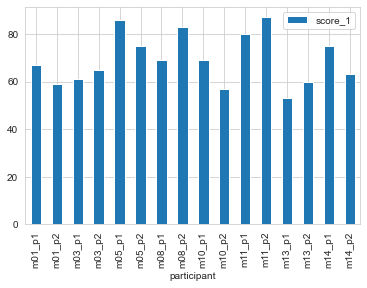

In [234]:
m_scores_1_bar = m_scores_1.plot.bar()

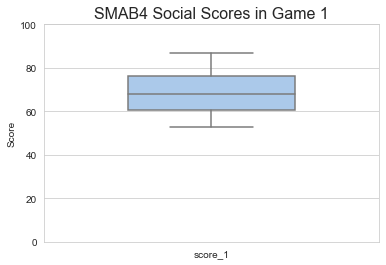

In [235]:
m_g1_scores_box = sns.boxplot( 
                 data=m_scores_1, 
                 width=0.5,
                 palette="pastel")
m_g1_scores_box.axes.set_title("SMAB4 Social Scores in Game 1",
                    fontsize=16)

plot_file_name="m_g1_score_box.jpg"
 
plt.ylim(0, 100)
m_g1_scores_box.axes.set(ylabel='Score')

# save as jpeg
m_g1_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')


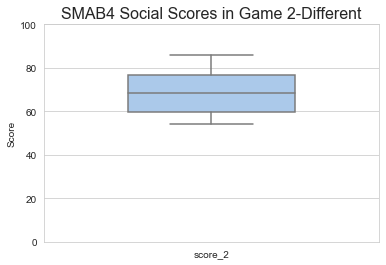

In [236]:
m_g2d_scores_box = sns.boxplot( 
                 data=m_scores_2_d, 
                 width=0.5,
                 palette="pastel")
m_g2d_scores_box.axes.set_title("SMAB4 Social Scores in Game 2-Different",
                    fontsize=16)

plot_file_name="m_g2d_score_box.jpg"
 
plt.ylim(0, 100)
m_g2d_scores_box.axes.set(ylabel='Score')

# save as jpeg
m_g2d_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

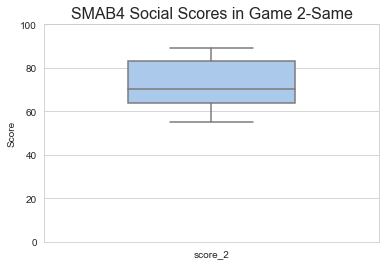

In [237]:
m_g2s_scores_box = sns.boxplot( 
                 data=m_scores_2_s, 
                 width=0.5,
                 palette="pastel")
m_g2s_scores_box.axes.set_title("SMAB4 Social Scores in Game 2-Same",
                    fontsize=16)

plot_file_name="m_g2s_score_box.jpg"
 
plt.ylim(0, 100)
m_g2s_scores_box.axes.set(ylabel='Score')

# save as jpeg
m_g2s_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [238]:
m_scores_2_d

,score_2
participant,
m01_p1,79
m01_p2,69
m03_p1,57
m03_p2,54
m05_p1,68
m05_p2,86


In [239]:
m_scores_2s_mean = m_scores_2_s.mean()

In [240]:
m_scores_2s_std = m_scores_2_s.std()

In [241]:
m_scores_2d_mean = m_scores_2_d.mean()

In [242]:
m_scores_2d_std = m_scores_2_d.std()

In [243]:
m_scores_2s_mean, m_scores_2s_std

(score_2    72.5
 dtype: float64,
 score_2    12.49222
 dtype: float64)

In [244]:
m_scores_2d_mean, m_scores_2d_std

(score_2    68.833333
 dtype: float64,
 score_2    12.319361
 dtype: float64)

In [245]:
sp.stats.ttest_ind(m_scores_2_s, m_scores_2_d)

Ttest_indResult(statistic=array([0.57120153]), pvalue=array([0.57691828]))

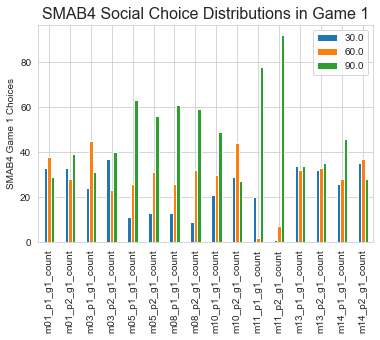

In [246]:
'''Here we place the counts of how many times each hole was chosen into dataframes for games 1 and 2. We also 
get statistics on this data and plot it.'''

# # Multi combined choices in G1

# In[ ]:


m_g1_counts = pd.DataFrame([m01_p1_g1_count, m01_p2_g1_count, m03_p1_g1_count, m03_p2_g1_count, m05_p1_g1_count, m05_p2_g1_count, m08_p1_g1_count, m08_p2_g1_count, 
              m10_p1_g1_count, m10_p2_g1_count, m11_p1_g1_count, m11_p2_g1_count, m13_p1_g1_count, m13_p2_g1_count, 
              m14_p1_g1_count, m14_p2_g1_count],
                index = ['m01_p1_g1_count', 'm01_p2_g1_count', 'm03_p1_g1_count', 'm03_p2_g1_count', 'm05_p1_g1_count', 'm05_p2_g1_count', 
                'm08_p1_g1_count', 'm08_p2_g1_count', 'm10_p1_g1_count', 'm10_p2_g1_count', 'm11_p1_g1_count', 
                'm11_p2_g1_count', 'm13_p1_g1_count', 'm13_p2_g1_count', 'm14_p1_g1_count', 'm14_p2_g1_count']) 

# In[ ]:


m_g1_counts = m_g1_counts.fillna(0) 



# In[ ]:


m_g1_counts


# In[ ]:


m_g1_counts.sum(axis=1)


# In[ ]:

# save as jpeg


m_g1_counts_bar = m_g1_counts.plot.bar()

m_g1_counts_bar.axes.set(ylabel='SMAB4 Game 1 Choices')

m_g1_counts_bar.axes.set_title("SMAB4 Social Choice Distributions in Game 1",fontsize=16)

m_g1_counts_bar.figure.savefig("m1_g1_counts_bar.jpg",
                    format='jpeg')

In [247]:
m01_p1_g1_count

30.0    33
90.0    29
60.0    38
Name: probability, dtype: int64

In [248]:
m_g1_counts

,30.0,60.0,90.0
m01_p1_g1_count,33,38,29
m01_p2_g1_count,33,28,39
m03_p1_g1_count,24,45,31
m03_p2_g1_count,37,23,40
m05_p1_g1_count,11,26,63
m05_p2_g1_count,13,31,56
m08_p1_g1_count,13,26,61
m08_p2_g1_count,9,32,59
m10_p1_g1_count,21,30,49
m10_p2_g1_count,29,44,27


In [249]:
len(m_g1_counts)

16

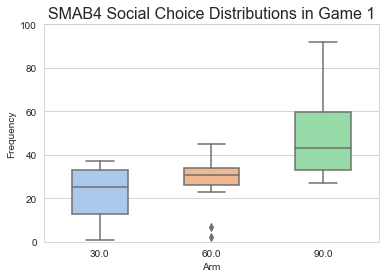

In [250]:
# In[ ]:


m_g1_counts_box = sns.boxplot( 
                 data = m_g1_counts, 
                 width=0.5,
                 palette="pastel")
m_g1_counts_box.axes.set_title("SMAB4 Social Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="m_g1_counts_box.jpg"
 
plt.ylim(0, 100)
m_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
m_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [251]:
# In[ ]:


m_g1_low = np.mean(m_g1_counts.iloc[:,0])
m_g1_med = np.mean(m_g1_counts.iloc[:,1])
m_g1_high = np.mean(m_g1_counts.iloc[:,2])


# In[ ]:


m_g1_low


# In[ ]:


m_g1_med


# In[ ]:


m_g1_high


# In[ ]:


m_g1_low_std = np.std(m_g1_counts.iloc[:,0])
m_g1_med_std = np.std(m_g1_counts.iloc[:,1])
m_g1_high_std = np.std(m_g1_counts.iloc[:,2])


# In[ ]:


m_g1_low_std


# In[ ]:


m_g1_med_std


# In[ ]:


m_g1_high_std

18.406754025357106

In [252]:
# # Multi combined choices in G2


m_g2d_counts = pd.DataFrame([m01_p1_g2_count, m01_p2_g2_count, m03_p1_g2_count, m03_p2_g2_count, m05_p1_g2_count, m05_p2_g2_count],
                index = ['m01_p1_g2_count','m01_p2_g2_count','m03_p1_g2_count', 'm03_p2_g2_count','m05_p1_g2_count', 'm05_p2_g2_count'])



m_g2d_counts = m_g2d_counts.fillna(0) 


m_g2d_counts.sum(axis=1)

m01_p1_g2_count    100
m01_p2_g2_count    100
m03_p1_g2_count    100
m03_p2_g2_count    100
m05_p1_g2_count    100
m05_p2_g2_count    100
dtype: int64

In [253]:
# # Multi combined choices in G2


m_g2s_counts = pd.DataFrame([m08_p1_g2_count, m08_p2_g2_count, 
              m10_p1_g2_count, m10_p2_g2_count, m11_p1_g2_count, m11_p2_g2_count, m13_p1_g2_count, m13_p2_g2_count, 
              m14_p1_g2_count, m14_p2_g2_count],
                index = ['m08_p1_g2_count', 'm08_p2_g2_count', 'm10_p1_g2_count', 'm10_p2_g2_count', 'm11_p1_g2_count', 
                'm11_p2_g2_count', 'm13_p1_g2_count', 'm13_p2_g2_count', 'm14_p1_g2_count', 'm14_p2_g2_count'])


m_g2s_counts = m_g2s_counts.fillna(0) 



m_g2s_counts.sum(axis=1)

m08_p1_g2_count    100.0
m08_p2_g2_count    100.0
m10_p1_g2_count    100.0
m10_p2_g2_count    100.0
m11_p1_g2_count    100.0
m11_p2_g2_count    100.0
m13_p1_g2_count    100.0
m13_p2_g2_count    100.0
m14_p1_g2_count    100.0
m14_p2_g2_count    100.0
dtype: float64

In [254]:
m_scores_1

,score_1
participant,
m01_p1,67
m01_p2,59
m03_p1,61
m03_p2,65
m05_p1,86
m05_p2,75
m08_p1,69
m08_p2,83
m10_p1,69


In [255]:
m_scores_mean_1 = np.mean(m_scores_1)
m_scores_std_1 = np.std(m_scores_1)

In [256]:
m_scores_mean_1

score_1    69.3125
dtype: float64

In [257]:
m_scores_std_1

score_1    10.312121
dtype: float64

In [258]:
m_g1_low, m_g1_med, m_g1_high

(23.1875, 28.875, 47.9375)

In [259]:
m_g1_low_std, m_g1_med_std, m_g1_high_std

(10.678358663671117, 10.993606096272506, 18.406754025357106)

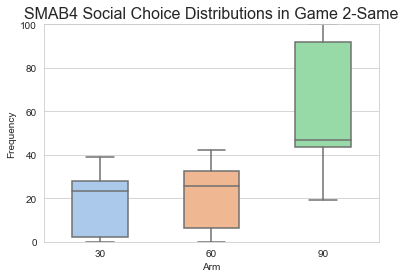

In [260]:
m_g2s_counts_box = sns.boxplot( 
                 data = m_g2s_counts, 
                 width=0.5,
                 palette="pastel")
m_g2s_counts_box.axes.set_title("SMAB4 Social Choice Distributions in Game 2-Same",
                    fontsize=16)

plot_file_name="m_g2s_counts_box.jpg"
 
plt.ylim(0, 100)
m_g2s_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
m_g2s_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

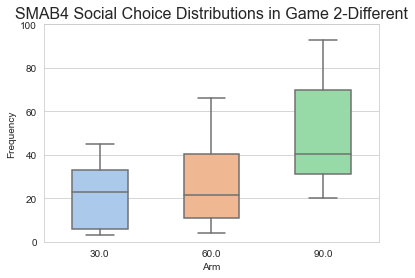

In [261]:
m_g2d_counts_box = sns.boxplot( 
                 data = m_g2d_counts, 
                 width=0.5,
                 palette="pastel")
m_g2d_counts_box.axes.set_title("SMAB4 Social Choice Distributions in Game 2-Different",
                    fontsize=16)

plot_file_name="m_g2d_counts_box.jpg"
 
plt.ylim(0, 100)
m_g2d_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
m_g2d_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [262]:
# In[ ]:


m_g2s_low = np.mean(m_g2s_counts.iloc[:,0])
m_g2s_med = np.mean(m_g2s_counts.iloc[:,1])
m_g2s_high = np.mean(m_g2s_counts.iloc[:,2])

m_g2s_low_std = np.std(m_g2s_counts.iloc[:,0])
m_g2s_med_std = np.std(m_g2s_counts.iloc[:,1])
m_g2s_high_std = np.std(m_g2s_counts.iloc[:,2])



import researchpy as rp


# In[ ]:


m_90_1 = np.array(m_g1_counts.iloc[:,2])
m_90_2s = np.array(m_g2s_counts.iloc[:,2])
m_90_2d = np.array(m_g2s_counts.iloc[:,2])

m_60_1 = np.array(m_g1_counts.iloc[:,1])
m_60_2s = np.array(m_g2s_counts.iloc[:,1])
m_60_2d = np.array(m_g2d_counts.iloc[:,1])


m_30_1 = np.array(m_g1_counts.iloc[:,0])
m_30_2s = np.array(m_g2s_counts.iloc[:,0])
m_30_2d = np.array(m_g2d_counts.iloc[:,0])

# Reaction Time

In [263]:
'Here we get the reaction times'
time_m_1 = pd.DataFrame(columns = ['session','post win','post loss'])
time_m_2 = pd.DataFrame(columns = ['session','post win','post loss'])

time_m_1 = reaction_time(m05_p1_g1, time_m_1)
time_m_1 = reaction_time(m06_p1_g1, time_m_1)
time_m_1 = reaction_time(m08_p1_g1, time_m_1)
time_m_1 = reaction_time(m10_p1_g1, time_m_1)
time_m_1 = reaction_time(m11_p1_g1, time_m_1)
time_m_1 = reaction_time(m13_p1_g1, time_m_1)
time_m_1 = reaction_time(m14_p1_g1, time_m_1)
time_m_1 = reaction_time(m05_p2_g1, time_m_1)
time_m_1 = reaction_time(m06_p2_g1, time_m_1)
time_m_1 = reaction_time(m08_p2_g1, time_m_1)
time_m_1 = reaction_time(m10_p2_g1, time_m_1)
time_m_1 = reaction_time(m11_p2_g1, time_m_1)
time_m_1 = reaction_time(m13_p2_g1, time_m_1)
time_m_1 = reaction_time(m14_p2_g1, time_m_1)

time_m_2 = reaction_time(m05_p1_g2, time_m_2)
time_m_2 = reaction_time(m06_p1_g2, time_m_2)
time_m_2 = reaction_time(m08_p1_g2, time_m_2)
time_m_2 = reaction_time(m10_p1_g2, time_m_2)
time_m_2 = reaction_time(m11_p1_g2, time_m_2)
time_m_2 = reaction_time(m13_p1_g2, time_m_2)
time_m_2 = reaction_time(m14_p1_g2, time_m_2)
time_m_2 = reaction_time(m05_p2_g2, time_m_2)
time_m_2 = reaction_time(m06_p2_g2, time_m_2)
time_m_2 = reaction_time(m08_p2_g2, time_m_2)
time_m_2 = reaction_time(m10_p2_g2, time_m_2)
time_m_2 = reaction_time(m11_p2_g2, time_m_2)
time_m_2 = reaction_time(m13_p2_g2, time_m_2)
time_m_2 = reaction_time(m14_p2_g2, time_m_2)

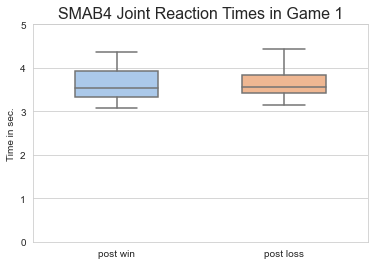

In [264]:
times_m_g1_box = sns.boxplot( 
                 data=time_m_1, 
                 width=0.5,
                 palette="pastel")
times_m_g1_box.axes.set_title("SMAB4 Joint Reaction Times in Game 1",
                    fontsize=16)

plot_file_name="times_m_g1_box.jpg"
 
plt.ylim(0, 5)
times_m_g1_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_m_g1_box.figure.savefig(plot_file_name,format='jpeg')

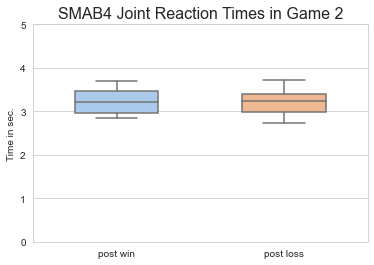

In [265]:
times_m_g2_box = sns.boxplot( 
                 data=time_m_2, 
                 width=0.5,
                 palette="pastel")
times_m_g2_box.axes.set_title("SMAB4 Joint Reaction Times in Game 2",
                    fontsize=16)

plot_file_name="times_m_g2_box.jpg"
 
plt.ylim(0, 5)
times_m_g2_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_m_g2_box.figure.savefig(plot_file_name,format='jpeg')

In [266]:
np.mean(time_m_1)

post win     3.626935
post loss    3.656920
dtype: float64

In [267]:
np.mean(time_m_2)

post win     3.426058
post loss    3.214477
dtype: float64

In [268]:
np.std(time_m_1)

post win     0.388043
post loss    0.357404
dtype: float64

In [269]:
np.std(time_m_2)

post win     0.823263
post loss    0.280154
dtype: float64

In [270]:
sp.stats.ttest_rel(time_m_1['post win'], time_m_1['post loss'])

Ttest_relResult(statistic=-0.7438584283556953, pvalue=0.4701941413958608)

In [271]:
sp.stats.ttest_rel(time_m_2['post win'], time_m_2['post loss'])

Ttest_relResult(statistic=0.9748098200412652, pvalue=0.3474456609541037)

In [272]:
sp.stats.ttest_rel(time_m_1['post win'], time_m_2['post win'])

Ttest_relResult(statistic=0.8653075259742253, pvalue=0.4025564225265744)

In [273]:
sp.stats.ttest_rel(time_m_1['post loss'], time_m_2['post loss'])

Ttest_relResult(statistic=5.168850202010096, pvalue=0.00018063098116127718)

# Test for differences between SMAB3 and SMAB4 in multi-player data

In [274]:
#simple t-test for score 
sp.stats.ttest_ind(m_scores_1, j_scores_1)

Ttest_indResult(statistic=array([0.72652466]), pvalue=array([0.47248973]))

In [275]:
#combine control_score_2 and control_score_1
#social_scores = social_scores_1.merge(social_scores_2,right_index=True,left_index=True)


#convert from wide-format to long-format
#social_scores = pd.melt(social_scores,ignore_index=False)

# Combining SMAB3 and 4

In [276]:
#combine m_counts and j_counts
soc_g1_counts_unmelt = m_g1_counts.append(j_g1_counts)

In [277]:
#combine m_counts and j_counts
soc_g2_s_counts_unmelt = m_g2s_counts.append(j_g2_s_counts)

soc_g2_d_counts_unmelt = m_g2d_counts.append(j_g2_d_counts)

soc_g2_counts_unmelt = soc_g2_s_counts_unmelt.append(soc_g2_d_counts_unmelt)

In [278]:
confed_g2_d_counts_unmelt = c_g2_d_counts.append(s_g2_d_counts)

confed_g2_s_counts_unmelt = c_g2_s_counts.append(s_g2_s_counts)

confed_g2_counts_unmelt = confed_g2_s_counts_unmelt.append(confed_g2_d_counts_unmelt)

In [279]:
soc_g2_s_scores_unmelt = m_scores_2_s.append(j_scores_2_s)

soc_g2_d_scores_unmelt = m_scores_2_d.append(j_scores_2_d)

In [280]:
confed_g2_s_scores_unmelt = c_scores_2_s.append(s_scores_2_s)

confed_g2_d_scores_unmelt = c_scores_2_d.append(s_scores_2_d)

In [281]:
'''The next few cells are done in order to be able to run ANOVA.'''
soc_g1_counts = soc_g1_counts_unmelt.melt(ignore_index=False)
soc_g2_counts = soc_g2_counts_unmelt.melt(ignore_index=False)

In [282]:
soc_g2_counts

,variable,value
m08_p1_g2_count,30.0,5.0
m08_p2_g2_count,30.0,1.0
m10_p1_g2_count,30.0,28.0
m10_p2_g2_count,30.0,25.0
m11_p1_g2_count,30.0,0.0
...,...,...
j06_p2_g2_count,90.0,49.0
j07_p1_g2_count,90.0,95.0
j07_p2_g2_count,90.0,50.0
j08_p1_g2_count,90.0,83.0


In [500]:
confed_g1_counts_unmelt = c_g1_counts.append(s_g1_counts)
confed_g1_counts = confed_g1_counts_unmelt.melt(ignore_index=False)
confed_g2_counts = confed_g2_counts_unmelt.melt(ignore_index=False)

In [501]:
np.mean(confed_g1_counts_unmelt)

30.0    18.709677
60.0    27.387097
90.0    53.870968
dtype: float64

In [502]:
np.mean(soc_g1_counts_unmelt)

30.0    23.416667
60.0    28.638889
90.0    47.944444
dtype: float64

In [503]:
np.std(confed_g1_counts_unmelt)

30.0    10.138377
60.0    13.837018
90.0    22.231541
dtype: float64

In [505]:
np.std(soc_g1_counts_unmelt)

30.0    12.186912
60.0    10.193006
90.0    18.043073
dtype: float64

In [506]:
sp.stats.ttest_ind(confed_g1_counts_unmelt,soc_g1_counts_unmelt)

Ttest_indResult(statistic=array([-1.67664153, -0.41873887,  1.18586978]), pvalue=array([0.09841618, 0.67678743, 0.23999067]))

In [507]:
g1_counts = confed_g1_counts.append(soc_g1_counts)
g2_counts = confed_g2_counts.append(soc_g2_counts)

In [508]:
g1_counts

,variable,value
c01_p1_g1_count,30.0,23.0
c02_p1_g1_count,30.0,13.0
c03_p1_g1_count,30.0,12.0
c05_p1_g1_count,30.0,34.0
c06_p1_g1_count,30.0,29.0
c07_p1_g1_count,30.0,12.0
c09_p1_g1_count,30.0,28.0
c10_p1_g1_count,30.0,9.0
c11_p1_g1_count,30.0,19.0
c12_p1_g1_count,30.0,33.0


In [291]:
#add another column to scores indicating whether it's the single or multiplayer
#TURN INTO FUNCTION

subjects = g1_counts.index.to_numpy()

condition = np.array([])

for i in subjects:
    if [i][0][0] == 's' or [i][0][0] == 'c':
        condition = np.append(condition,'control')
    elif [i][0][0] == 'm' or [i][0][0] == 'j':
        condition = np.append(condition,'social')

g1_counts['condition'] = condition

In [292]:
#add column to joint_counts indicating whether it's SMAB3 or 4
subjects = g1_counts.index.to_numpy()

experiment = np.array([])

for i in subjects:
    if [i][0][0] == 'j' or [i][0][0] == 's':
        experiment = np.append(experiment,3)
    elif [i][0][0] == 'm' or [i][0][0] == 'c':
        experiment = np.append(experiment,4)
        
g1_counts['experiment'] = experiment

In [293]:
#add another column to scores indicating whether it's the single or multiplayer
#TURN INTO FUNCTION

subjects = g2_counts.index.to_numpy()

condition = np.array([])

for i in subjects:
    if [i][0][0] == 's' or [i][0][0] == 'c':
        condition = np.append(condition,'control')
    elif [i][0][0] == 'm' or [i][0][0] == 'j':
        condition = np.append(condition,'social')

g2_counts['condition'] = condition

In [294]:
#add column to joint_counts indicating whether it's SMAB3 or 4
subjects = g2_counts.index.to_numpy()

experiment = np.array([])

for i in subjects:
    if [i][0][0] == 'j' or [i][0][0] == 's':
        experiment = np.append(experiment,3)
    elif [i][0][0] == 'm' or [i][0][0] == 'c':
        experiment = np.append(experiment,4)
        
g2_counts['experiment'] = experiment

In [295]:
g2_counts

,variable,value,condition,experiment
c01_p1_g2_count,30.0,11.0,control,4.0
c04_p1_g2_count,30.0,3.0,control,4.0
c12_p1_g2_count,30.0,38.0,control,4.0
c13_p1_g2_count,30.0,22.0,control,4.0
c14_p1_g2_count,30.0,19.0,control,4.0
...,...,...,...,...
j06_p2_g2_count,90.0,49.0,social,3.0
j07_p1_g2_count,90.0,95.0,social,3.0
j07_p2_g2_count,90.0,50.0,social,3.0
j08_p1_g2_count,90.0,83.0,social,3.0


In [296]:
#combine g1_counts and g2_counts
counts = g1_counts.append(g2_counts)

#add column to counts indicating whether it's game 1 or 2
subjects = counts.index.to_numpy()

game = np.array([])

for i in subjects:
    if [i][0][8] == '1':
        game = np.append(game,1)
    elif [i][0][8] == '2':
        game = np.append(game,2)
        
counts['game'] = game
        

In [297]:
#add participant column with subject code 
participant = np.array([])

for i in subjects:
    participant = np.append(participant, [i][0][0:6])
    
counts['participant'] = participant

In [298]:
#break up counts dataframe into 30,60,90
grouped = g1_counts.groupby(g1_counts.variable)
g1_counts_30 = grouped.get_group(30.0)
g1_counts_60 = grouped.get_group(60.0)
g1_counts_90 = grouped.get_group(90.0)

#break up counts dataframe into 30,60,90
grouped = counts.groupby(counts.variable)
counts_30 = grouped.get_group(30.0)
counts_60 = grouped.get_group(60.0)
counts_90 = grouped.get_group(90.0)

In [299]:
#combine c_score and s_score
confed_g1_score = c_scores_1.append(s_scores_1)
confed_g1_score = confed_g1_score.melt(ignore_index=False)

In [300]:
#combine m_score and j_score
soc_g1_score = m_scores_1.append(j_scores_1)
soc_g1_score = soc_g1_score.melt(ignore_index=False)

In [301]:
import pingouin as pg

Mixed measures ANOVA with all of the data looking at condition (social vs control) as the between variable and game (1 vs 2) as the within variable

In [302]:
counts_30

,variable,value,condition,experiment,game,participant
c01_p1_g1_count,30.0,23.0,control,4.0,1.0,c01_p1
c02_p1_g1_count,30.0,13.0,control,4.0,1.0,c02_p1
c03_p1_g1_count,30.0,12.0,control,4.0,1.0,c03_p1
c04_p1_g1_count,30.0,8.0,control,4.0,1.0,c04_p1
c05_p1_g1_count,30.0,34.0,control,4.0,1.0,c05_p1
...,...,...,...,...,...,...
j06_p2_g2_count,30.0,8.0,social,3.0,2.0,j06_p2
j07_p1_g2_count,30.0,4.0,social,3.0,2.0,j07_p1
j07_p2_g2_count,30.0,8.0,social,3.0,2.0,j07_p2
j08_p1_g2_count,30.0,6.0,social,3.0,2.0,j08_p1


In [303]:
counts_30.shape

(136, 6)

In [304]:
pg.mixed_anova(data=counts_30, dv='value', between='condition', within='game', subject='participant')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,381.980801,1,66,381.980801,1.538689,0.219205,0.022782,NaN
1,game,840.029412,1,66,840.029412,15.103166,0.000239,0.186222,1.0
2,Interaction,96.088644,1,66,96.088644,1.727609,0.193266,0.025508,NaN


In [305]:
pg.mixed_anova(data=counts_90, dv='value', between='condition', within='game', subject='participant')

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,523.920037,1,66,523.920037,0.666617,0.417171,0.009999,NaN
1,game,3116.183824,1,66,3116.183824,16.604592,0.000126,0.201013,1.0
2,Interaction,111.095690,1,66,111.095690,0.591974,0.444402,0.008890,NaN


In [306]:
pg.mixed_anova(data=counts_60, dv='value', between='condition', within='game', subject='participant')

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,23.923203,1,66,23.923203,0.095316,0.758497,0.001442,NaN
1,game,593.058824,1,66,593.058824,5.377704,0.023501,0.075342,1.0
2,Interaction,11.392565,1,66,11.392565,0.103305,0.748915,0.001563,NaN


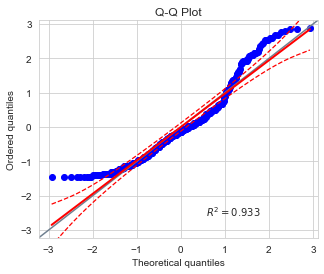

In [307]:
pg.qqplot(counts['value'])

In [308]:
counts 

,variable,value,condition,experiment,game,participant
c01_p1_g1_count,30.0,23.0,control,4.0,1.0,c01_p1
c02_p1_g1_count,30.0,13.0,control,4.0,1.0,c02_p1
c03_p1_g1_count,30.0,12.0,control,4.0,1.0,c03_p1
c04_p1_g1_count,30.0,8.0,control,4.0,1.0,c04_p1
c05_p1_g1_count,30.0,34.0,control,4.0,1.0,c05_p1
...,...,...,...,...,...,...
j06_p2_g2_count,90.0,49.0,social,3.0,2.0,j06_p2
j07_p1_g2_count,90.0,95.0,social,3.0,2.0,j07_p1
j07_p2_g2_count,90.0,50.0,social,3.0,2.0,j07_p2
j08_p1_g2_count,90.0,83.0,social,3.0,2.0,j08_p1


In [309]:
#unmelt the counts df
counts = counts.pivot_table(index = counts.index, columns = ['variable'])

In [310]:
counts

experiment           game           value            
variable              30.0 60.0 90.0 30.0 60.0 90.0  30.0  60.0  90.0
c01_p1_g1_count        4.0  4.0  4.0  1.0  1.0  1.0  23.0  34.0  43.0
c01_p1_g2_count        4.0  4.0  4.0  2.0  2.0  2.0  11.0  30.0  64.0
c02_p1_g1_count        4.0  4.0  4.0  1.0  1.0  1.0  13.0  44.0  43.0
c02_p1_g2_count        4.0  4.0  4.0  2.0  2.0  2.0   3.0  16.0  81.0
c03_p1_g1_count        4.0  4.0  4.0  1.0  1.0  1.0  12.0   4.0  84.0
...                    ...  ...  ...  ...  ...  ...   ...   ...   ...
s17_p1_g2_count        3.0  3.0  3.0  2.0  2.0  2.0   0.0  22.0  78.0
s19_p1_g1_count        3.0  3.0  3.0  1.0  1.0  1.0  20.0  23.0  57.0
s19_p1_g2_count        3.0  3.0  3.0  2.0  2.0  2.0  12.0   9.0  79.0
s20_p1_g1_count        3.0  3.0  3.0  1.0  1.0  1.0  21.0  49.0  31.0
s20_p1_g2_count        3.0  3.0  3.0  2.0  2.0  2.0  10.0  54.0  37.0

[136 rows x 9 columns]

In [311]:
'''This function calculates a weighted avg of the choice behavior and adds the average to a new column 
called avg for each row.'''
def weight_avg(df):
    avg = np.array([])
    for index, row in df.iterrows():
        value = (counts['value', 30.0][index] * 0.3) + (counts['value', 60.0][index] * 0.6) + (counts['value', 90.0][index] * 0.9) 
        avg = np.append(avg, value)
    df['avg'] = avg
    return df

In [312]:
counts = weight_avg(counts)

In [313]:
counts

experiment           game           value               avg
variable              30.0 60.0 90.0 30.0 60.0 90.0  30.0  60.0  90.0      
c01_p1_g1_count        4.0  4.0  4.0  1.0  1.0  1.0  23.0  34.0  43.0  66.0
c01_p1_g2_count        4.0  4.0  4.0  2.0  2.0  2.0  11.0  30.0  64.0  78.9
c02_p1_g1_count        4.0  4.0  4.0  1.0  1.0  1.0  13.0  44.0  43.0  69.0
c02_p1_g2_count        4.0  4.0  4.0  2.0  2.0  2.0   3.0  16.0  81.0  83.4
c03_p1_g1_count        4.0  4.0  4.0  1.0  1.0  1.0  12.0   4.0  84.0  81.6
...                    ...  ...  ...  ...  ...  ...   ...   ...   ...   ...
s17_p1_g2_count        3.0  3.0  3.0  2.0  2.0  2.0   0.0  22.0  78.0  83.4
s19_p1_g1_count        3.0  3.0  3.0  1.0  1.0  1.0  20.0  23.0  57.0  71.1
s19_p1_g2_count        3.0  3.0  3.0  2.0  2.0  2.0  12.0   9.0  79.0  80.1
s20_p1_g1_count        3.0  3.0  3.0  1.0  1.0  1.0  21.0  49.0  31.0  63.6
s20_p1_g2_count        3.0  3.0  3.0  2.0  2.0  2.0  10.0  54.0  37.0  68.7

[136 rows x 10 columns]

In [314]:
counts = counts.drop(['game','value','experiment'], axis = 1)

In [315]:
#add participant column with subject code 
subjects = counts.index.to_numpy()

participant = np.array([])

for i in subjects:
    participant = np.append(participant, [i][0][0:6])
    
counts['participant'] = participant

game = np.array([])

for i in subjects:
    if [i][0][8] == '1':
        game = np.append(game,1)
    elif [i][0][8] == '2':
        game = np.append(game,2)
        
counts['game'] = game

experiment = np.array([])

for i in subjects:
    if [i][0][0] == 'j' or [i][0][0] == 's':
        experiment = np.append(experiment,3)
    elif [i][0][0] == 'm' or [i][0][0] == 'c':
        experiment = np.append(experiment,4)
        
counts['experiment'] = experiment

condition = np.array([])

for i in subjects:
    if [i][0][0] == 's' or [i][0][0] == 'c':
        condition = np.append(condition,'control')
    elif [i][0][0] == 'm' or [i][0][0] == 'j':
        condition = np.append(condition,'social')

counts['condition'] = condition

In [316]:
#missing jo7_p2_g2
counts

,avg,participant,game,experiment,condition
variable,,,,,
c01_p1_g1_count,66.0,c01_p1,1.0,4.0,control
c01_p1_g2_count,78.9,c01_p1,2.0,4.0,control
c02_p1_g1_count,69.0,c02_p1,1.0,4.0,control
c02_p1_g2_count,83.4,c02_p1,2.0,4.0,control
c03_p1_g1_count,81.6,c03_p1,1.0,4.0,control
...,...,...,...,...,...
s17_p1_g2_count,83.4,s17_p1,2.0,3.0,control
s19_p1_g1_count,71.1,s19_p1,1.0,3.0,control
s19_p1_g2_count,80.1,s19_p1,2.0,3.0,control


In [317]:
counts.shape

(136, 5)

In [318]:
counts = counts.sort_index()

In [319]:
pg.mixed_anova(data=counts, dv='avg', between='condition', within='game', subject='participant')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/Users/baryosef/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,139.296406,1,66,139.296406,0.854591,0.358624,0.012783,NaN
1,game,725.432426,1,66,725.432426,20.222054,0.000029,0.234535,1.0
2,Interaction,20.432730,1,66,20.432730,0.569580,0.453110,0.008556,NaN


In [320]:
#split data into 2 halves and see if this is still true 
#run ANOVA for g2_s and g2_d 

# Plotting Combined Data

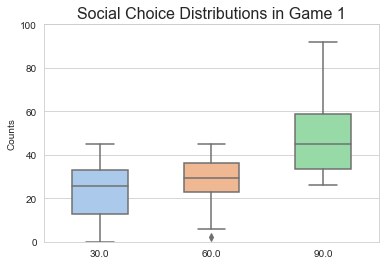

In [321]:
soc_g1_counts_box = sns.boxplot( 
                 data=soc_g1_counts_unmelt,
                 width=0.5,
                 palette="pastel")
soc_g1_counts_box.axes.set_title("Social Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="soc_counts1_box.jpg"
 
plt.ylim(0, 100)
soc_g1_counts_box.axes.set(ylabel='Counts')

# save as jpeg
soc_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

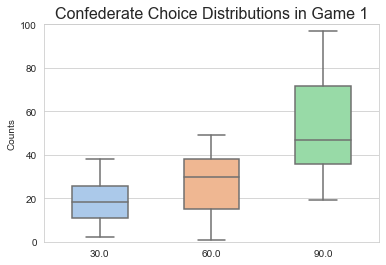

In [322]:
confed_g1_counts_box = sns.boxplot( 
                 data=confed_g1_counts_unmelt,
                 width=0.5,
                 palette="pastel")
confed_g1_counts_box.axes.set_title("Confederate Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="confed_counts1_box.jpg"
 
plt.ylim(0, 100)
confed_g1_counts_box.axes.set(ylabel='Counts')

# save as jpeg
confed_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [323]:
sp.stats.ttest_ind(soc_g1_counts_unmelt, confed_g1_counts_unmelt)

Ttest_indResult(statistic=array([ 1.81323553,  0.48206348, -1.16709022]), pvalue=array([0.07434261, 0.63135567, 0.24737337]))

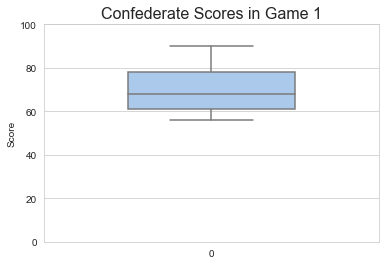

In [324]:
confed_g1_scores_box = sns.boxplot( 
                 data=confed_g1_score['value'],
                 width=0.5,
                 palette="pastel")
confed_g1_scores_box.axes.set_title("Confederate Scores in Game 1",
                    fontsize=16)

plot_file_name="confed_score1_box.jpg"
 
plt.ylim(0, 100)
confed_g1_scores_box.axes.set(ylabel='Score')

# save as jpeg
confed_g1_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

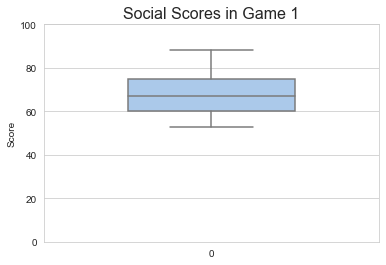

In [325]:
soc_g1_scores_box = sns.boxplot( 
                 data=soc_g1_score['value'],
                 width=0.5,
                 palette="pastel")
soc_g1_scores_box.axes.set_title("Social Scores in Game 1",
                    fontsize=16)

plot_file_name="soc_score1_box.jpg"
 
plt.ylim(0, 100)
soc_g1_scores_box.axes.set(ylabel='Score')

# save as jpeg
soc_g1_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [326]:
sp.stats.ttest_ind(soc_g1_score['value'], confed_g1_score['value'])

Ttest_indResult(statistic=-0.8839368139635342, pvalue=0.3799390222581692)

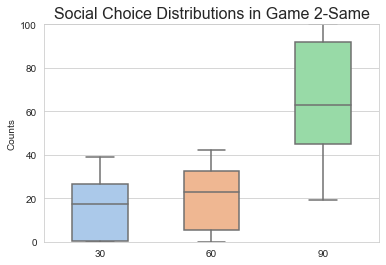

In [327]:
soc_g2s_counts_box = sns.boxplot( 
                 data=soc_g2_s_counts_unmelt,
                 width=0.5,
                 palette="pastel")
soc_g2s_counts_box.axes.set_title("Social Choice Distributions in Game 2-Same",
                    fontsize=16)

plot_file_name="soc_counts2s_box.jpg"
 
plt.ylim(0, 100)
soc_g2s_counts_box.axes.set(ylabel='Counts')

# save as jpeg
soc_g2s_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [328]:
soc_g2_s_counts_unmelt

,30,60,90
m08_p1_g2_count,5.0,13.0,82.0
m08_p2_g2_count,1.0,4.0,95.0
m10_p1_g2_count,28.0,27.0,45.0
m10_p2_g2_count,25.0,32.0,43.0
m11_p1_g2_count,0.0,1.0,99.0
m11_p2_g2_count,0.0,0.0,100.0
m13_p1_g2_count,22.0,33.0,45.0
m13_p2_g2_count,27.0,24.0,49.0
m14_p1_g2_count,39.0,42.0,19.0
m14_p2_g2_count,33.0,37.0,30.0


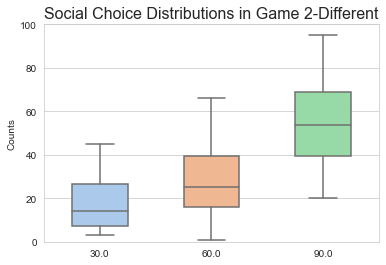

In [329]:
soc_g2d_counts_box = sns.boxplot( 
                 data=soc_g2_d_counts_unmelt,
                 width=0.5,
                 palette="pastel")
soc_g2d_counts_box.axes.set_title("Social Choice Distributions in Game 2-Different",
                    fontsize=16)

plot_file_name="soc_counts2d_box.jpg"
 
plt.ylim(0, 100)
soc_g2d_counts_box.axes.set(ylabel='Counts')

# save as jpeg
soc_g2d_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [330]:
sp.stats.ttest_ind(soc_g2_d_counts_unmelt, soc_g2_s_counts_unmelt)

Ttest_indResult(statistic=array([ 0.525891  ,  1.22612629, -1.06036517]), pvalue=array([0.60237752, 0.22857579, 0.29645329]))

In [331]:
sp.stats.ttest_ind(soc_g2_d_counts_unmelt, soc_g2_s_counts_unmelt)

Ttest_indResult(statistic=array([ 0.525891  ,  1.22612629, -1.06036517]), pvalue=array([0.60237752, 0.22857579, 0.29645329]))

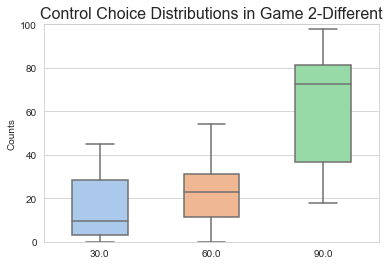

In [332]:
confed_g2d_counts_box = sns.boxplot( 
                 data=confed_g2_d_counts_unmelt,
                 width=0.5,
                 palette="pastel")
confed_g2d_counts_box.axes.set_title("Control Choice Distributions in Game 2-Different",
                    fontsize=16)

plot_file_name="confed_counts2d_box.jpg"
 
plt.ylim(0, 100)
confed_g2d_counts_box.axes.set(ylabel='Counts')

# save as jpeg
confed_g2d_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

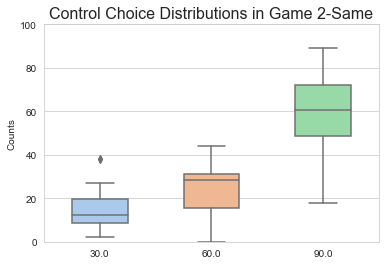

In [333]:
confed_g2s_counts_box = sns.boxplot( 
                 data=confed_g2_s_counts_unmelt,
                 width=0.5,
                 palette="pastel")
confed_g2s_counts_box.axes.set_title("Control Choice Distributions in Game 2-Same",
                    fontsize=16)

plot_file_name="confed_counts2s_box.jpg"
 
plt.ylim(0, 100)
confed_g2s_counts_box.axes.set(ylabel='Counts')

# save as jpeg
confed_g2s_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [334]:
sp.stats.ttest_ind(confed_g2_d_counts_unmelt, confed_g2_s_counts_unmelt)

Ttest_indResult(statistic=array([-0.19203444, -0.32593111,  0.28725011]), pvalue=array([0.84900919, 0.74673915, 0.77589566]))

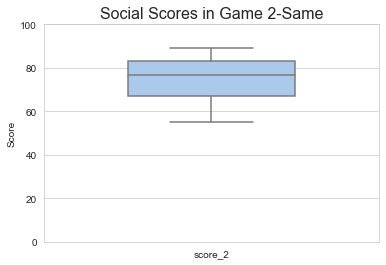

In [335]:
soc_g2_s_scores_box = sns.boxplot( 
                 data=soc_g2_s_scores_unmelt,
                 width=0.5,
                 palette="pastel")
soc_g2_s_scores_box.axes.set_title("Social Scores in Game 2-Same",
                    fontsize=16)

plot_file_name="soc_g2_s_scores_box.jpg"
 
plt.ylim(0, 100)
soc_g2_s_scores_box.axes.set(ylabel='Score')

# save as jpeg
soc_g2_s_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

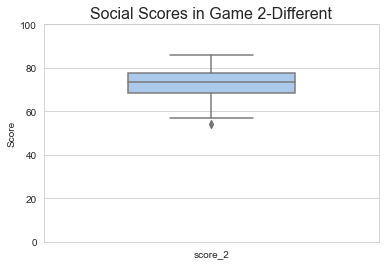

In [336]:
soc_g2_d_scores_box = sns.boxplot( 
                 data=soc_g2_d_scores_unmelt,
                 width=0.5,
                 palette="pastel")
soc_g2_d_scores_box.axes.set_title("Social Scores in Game 2-Different",
                    fontsize=16)

plot_file_name="soc_g2_d_scores_box.jpg"
 
plt.ylim(0, 100)
soc_g2_d_scores_box.axes.set(ylabel='Score')

# save as jpeg
soc_g2_d_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [337]:
sp.stats.ttest_ind(soc_g2_d_scores_unmelt, soc_g2_s_scores_unmelt)

Ttest_indResult(statistic=array([-0.87835205]), pvalue=array([0.38591794]))

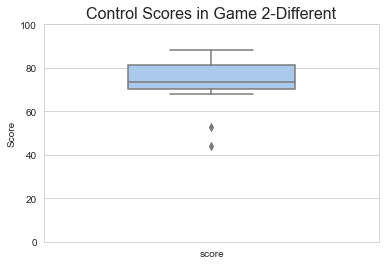

In [338]:
#NEED TO FIX
confed_g2_d_scores_box = sns.boxplot( 
                 data=confed_g2_d_scores_unmelt,
                 width=0.5,
                 palette="pastel")
confed_g2_d_scores_box.axes.set_title("Control Scores in Game 2-Different",
                    fontsize=16)

plot_file_name="confed_g2_d_scores_box.jpg"
 
plt.ylim(0, 100)
confed_g2_d_scores_box.axes.set(ylabel='Score')

# save as jpeg
confed_g2_d_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

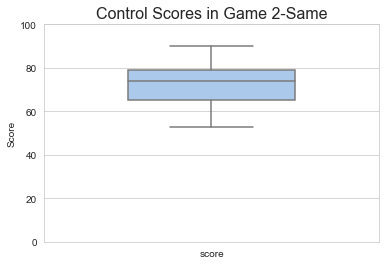

In [339]:
confed_g2_s_scores_box = sns.boxplot( 
                 data=confed_g2_s_scores_unmelt,
                 width=0.5,
                 palette="pastel")
confed_g2_s_scores_box.axes.set_title("Control Scores in Game 2-Same",
                    fontsize=16)

plot_file_name="confed_g2_s_scores_box.jpg"
 
plt.ylim(0, 100)
confed_g2_s_scores_box.axes.set(ylabel='Score')

# save as jpeg
confed_g2_s_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [340]:
sp.stats.ttest_ind(confed_g2_d_scores_unmelt, confed_g2_s_scores_unmelt)

Ttest_indResult(statistic=array([0.18499796]), pvalue=array([0.85451838]))

In [341]:
sp.stats.ttest_ind(confed_g2_d_scores_unmelt, confed_g1_score['value'])

Ttest_indResult(statistic=array([0.92565215]), pvalue=array([0.35967615]))

In [342]:
sp.stats.ttest_ind(confed_g2_s_scores_unmelt, confed_g1_score['value'])

Ttest_indResult(statistic=array([0.80348004]), pvalue=array([0.42574234]))

In [343]:
sp.stats.ttest_ind(confed_g2_d_counts_unmelt, confed_g1_counts_unmelt)

Ttest_indResult(statistic=array([-0.99869717, -0.99681589,  1.21683411]), pvalue=array([0.32316616, 0.3240688 , 0.22987383]))

In [344]:
sp.stats.ttest_ind(confed_g2_s_counts_unmelt, confed_g1_counts_unmelt)

Ttest_indResult(statistic=array([-0.85187811, -0.68345632,  1.0048921 ]), pvalue=array([0.39869513, 0.49774687, 0.32020579]))

# JSD Analysis of the Combined Data

In [345]:
soc_g1_counts

,variable,value
m01_p1_g1_count,30.0,33.0
m01_p2_g1_count,30.0,33.0
m03_p1_g1_count,30.0,24.0
m03_p2_g1_count,30.0,37.0
m05_p1_g1_count,30.0,11.0
...,...,...
j08_p2_g1_count,90.0,37.0
j10_p1_g1_count,90.0,48.0
j10_p2_g1_count,90.0,59.0
j11_p1_g1_count,90.0,60.0


In [346]:
soc_g2_counts_unmelt = soc_g2_d_counts_unmelt.append(soc_g2_s_counts_unmelt)

In [347]:
soc_g2_counts_unmelt

,30.0,60.0,90.0
m01_p1_g2_count,15.0,8.0,77.0
m01_p2_g2_count,31.0,20.0,49.0
m03_p1_g2_count,34.0,46.0,20.0
m03_p2_g2_count,45.0,23.0,32.0
m05_p1_g2_count,3.0,66.0,31.0
m05_p2_g2_count,3.0,4.0,93.0
j01_p1_g2_count,18.0,28.0,54.0
j01_p2_g2_count,26.0,37.0,37.0
j02_p1_g2_count,27.0,27.0,46.0
j02_p2_g2_count,9.0,26.0,65.0


In [348]:
confed_g1_counts_unmelt

,30.0,60.0,90.0
c01_p1_g1_count,23,34,43
c02_p1_g1_count,13,44,43
c03_p1_g1_count,12,4,84
c04_p1_g1_count,8,22,48
c05_p1_g1_count,34,31,35
c06_p1_g1_count,29,29,42
c07_p1_g1_count,12,16,70
c09_p1_g1_count,28,47,25
c10_p1_g1_count,9,13,78
c11_p1_g1_count,19,38,43


In [349]:
confed_g2_counts_unmelt = confed_g2_d_counts_unmelt.append(confed_g2_s_counts_unmelt)

In [350]:
confed_g2_counts_unmelt

,30.0,60.0,90.0
c02_p1_g2_count,3.0,16.0,81.0
c03_p1_g2_count,5.0,12.0,83.0
c05_p1_g2_count,34.0,30.0,36.0
c06_p1_g2_count,36.0,35.0,30.0
c07_p1_g2_count,2.0,17.0,81.0
c09_p1_g2_count,45.0,37.0,18.0
c10_p1_g2_count,11.0,24.0,65.0
c11_p1_g2_count,9.0,24.0,67.0
s11_p1_g2_count,28.0,30.0,42.0
s12_p1_g2_count,7.0,5.0,88.0


# Maximizing vs Matching Social Condition

In [351]:
m01_p1_g1_count

30.0    33
90.0    29
60.0    38
Name: probability, dtype: int64

In [352]:
# # Maximizing/Matching SOCIAL

# In[ ]:


from scipy import stats


# In[ ]:


#Optional: Idealized probability distributions to use for comparison. These assume a social strategy in which the probability
#distributions of both partners in a joint session are averaged (all holes reward at a 60% rate)

#social_max = [0, 0, 100]
#social_match = [30/180 * 100,60/180 * 100, 90/180 * 100]


# In[ ]:


#Calls jsd with the social distributions.
#def call_jsd_social(counts):
   # maxi = jsd(counts,social_max)
   # matchi = jsd(counts,social_match)
    #return maxi,matchi


# In[ ]:


j01_p1_g1_max,j01_p1_g1_match,j01_p1_g1_rand,j01_p1_g1_soc = call_jsd(j01_p1_g1_count)
j01_p1_g2_max,j01_p1_g2_match,j01_p1_g2_rand,j01_p1_g2_soc = call_jsd(j01_p1_g2_count)
j01_p2_g1_max,j01_p2_g1_match,j01_p2_g1_rand,j01_p2_g1_soc = call_jsd(j01_p2_g1_count)
j01_p2_g2_max,j01_p2_g2_match,j01_p2_g2_rand,j01_p2_g2_soc = call_jsd(j01_p2_g2_count)
j02_p1_g1_max,j02_p1_g1_match,j02_p1_g1_rand,j02_p1_g1_soc = call_jsd(j02_p1_g1_count)
j02_p1_g2_max,j02_p1_g2_match,j02_p1_g2_rand,j02_p1_g2_soc = call_jsd(j02_p1_g2_count)
j02_p2_g1_max,j02_p2_g1_match,j02_p2_g1_rand,j02_p2_g1_soc = call_jsd(j02_p2_g1_count)
j02_p2_g2_max,j02_p2_g2_match,j02_p2_g2_rand,j02_p2_g2_soc = call_jsd(j02_p2_g2_count)
j03_p1_g1_max,j03_p1_g1_match,j03_p1_g1_rand,j03_p1_g1_soc = call_jsd(j03_p1_g1_count)
j03_p1_g2_max,j03_p1_g2_match,j03_p1_g2_rand,j03_p1_g2_soc = call_jsd(j03_p1_g2_count)
j03_p2_g1_max,j03_p2_g1_match,j03_p2_g1_rand,j03_p2_g1_soc  = call_jsd(j03_p2_g1_count)
j03_p2_g2_max,j03_p2_g2_match,j03_p2_g2_rand,j03_p2_g2_soc = call_jsd(j03_p2_g2_count)
j04_p1_g1_max,j04_p1_g1_match,j04_p1_g1_rand,j04_p1_g1_soc = call_jsd(j04_p1_g1_count)
j04_p1_g2_max,j04_p1_g2_match,j04_p1_g2_rand,j04_p1_g2_soc = call_jsd(j04_p1_g2_count)
j04_p2_g1_max,j04_p2_g1_match,j04_p2_g1_rand,j04_p2_g1_soc  = call_jsd(j04_p2_g1_count)
j04_p2_g2_max,j04_p2_g2_match,j04_p2_g2_rand,j04_p2_g2_soc = call_jsd(j04_p2_g2_count)
j05_p1_g1_max,j05_p1_g1_match,j05_p1_g1_rand,j05_p1_g1_soc = call_jsd(j05_p1_g1_count)
j05_p1_g2_max,j05_p1_g2_match,j05_p1_g2_rand,j05_p1_g2_soc = call_jsd(j05_p1_g2_count)
j05_p2_g1_max,j05_p2_g1_match,j05_p2_g1_rand,j05_p2_g1_soc = call_jsd(j05_p2_g1_count)
j05_p2_g2_max,j05_p2_g2_match,j05_p2_g2_rand,j05_p2_g2_soc = call_jsd(j05_p2_g2_count)
j06_p1_g1_max,j06_p1_g1_match,j06_p1_g1_rand,j06_p1_g1_soc = call_jsd(j06_p1_g1_count)
j06_p1_g2_max,j06_p1_g2_match,j06_p1_g2_rand,j06_p1_g2_soc = call_jsd(j06_p1_g2_count)
j06_p2_g1_max,j06_p2_g1_match,j06_p2_g1_rand,j06_p2_g1_soc = call_jsd(j06_p2_g1_count)
j06_p2_g2_max,j06_p2_g2_match,j06_p2_g2_rand,j06_p2_g2_soc = call_jsd(j06_p2_g2_count)
j07_p1_g1_max,j07_p1_g1_match,j07_p1_g1_rand,j07_p1_g1_soc = call_jsd(j07_p1_g1_count)
j07_p1_g2_max,j07_p1_g2_match,j07_p1_g2_rand,j07_p1_g2_soc = call_jsd(j07_p1_g2_count)
j07_p2_g1_max,j07_p2_g1_match,j07_p2_g1_rand,j07_p2_g1_soc = call_jsd(j07_p2_g1_count)
j07_p2_g2_max,j07_p2_g2_match,j07_p2_g2_rand,j07_p2_g2_soc = call_jsd(j07_p2_g2_count)
j08_p1_g1_max,j08_p1_g1_match,j08_p1_g1_rand,j08_p1_g1_soc = call_jsd(j08_p1_g1_count)
j08_p1_g2_max,j08_p1_g2_match,j08_p1_g2_rand,j08_p1_g2_soc = call_jsd(j08_p1_g2_count)
j08_p2_g1_max,j08_p2_g1_match,j08_p2_g1_rand,j08_p2_g1_soc = call_jsd(j08_p2_g1_count)
j08_p2_g2_max,j08_p2_g2_match,j08_p2_g2_rand,j08_p2_g2_soc = call_jsd(j08_p2_g2_count)
j10_p1_g1_max,j10_p1_g1_match,j10_p1_g1_rand,j10_p1_g1_soc = call_jsd(j10_p1_g1_count)
j10_p1_g2_max,j10_p1_g2_match,j10_p1_g2_rand,j10_p1_g2_soc = call_jsd(j10_p1_g2_count)
j10_p2_g1_max,j10_p2_g1_match,j10_p2_g1_rand,j10_p2_g1_soc = call_jsd(j10_p2_g1_count)
j10_p2_g2_max,j10_p2_g2_match,j10_p2_g2_rand,j10_p2_g2_soc = call_jsd(j10_p2_g2_count)
j11_p1_g1_max,j11_p1_g1_match,j11_p1_g1_rand,j11_p1_g1_soc = call_jsd([0,40,60])
j11_p1_g2_max,j11_p1_g2_match,j11_p1_g2_rand,j11_p1_g2_soc = call_jsd([0,22,78])
j11_p2_g1_max,j11_p2_g1_match,j11_p2_g1_rand,j11_p2_g1_soc = call_jsd(j11_p2_g1_count)
j11_p2_g2_max,j11_p2_g2_match,j11_p2_g2_rand,j11_p2_g2_soc = call_jsd([0,1,99])
m01_p1_g1_max,m01_p1_g1_match,m01_p1_g1_rand,m01_p1_g1_soc = call_jsd(m01_p1_g1_count)
m01_p1_g2_max,m01_p1_g2_match,m01_p1_g2_rand,m01_p1_g2_soc = call_jsd(m01_p1_g2_count)
m01_p2_g1_max,m01_p2_g1_match,m01_p2_g1_rand,m01_p2_g1_soc = call_jsd(m01_p2_g1_count)
m01_p2_g2_max,m01_p2_g2_match,m01_p2_g2_rand,m01_p2_g2_soc = call_jsd(m01_p2_g2_count)
m03_p1_g1_max,m03_p1_g1_match,m03_p1_g1_rand,m03_p1_g1_soc = call_jsd(m03_p1_g1_count)
m03_p1_g2_max,m03_p1_g2_match,m03_p1_g2_rand,m03_p1_g2_soc = call_jsd(m03_p1_g2_count)
m03_p2_g1_max,m03_p2_g1_match,m03_p2_g1_rand,m03_p2_g1_soc = call_jsd(m03_p2_g1_count)
m03_p2_g2_max,m03_p2_g2_match,m03_p2_g2_rand,m03_p2_g2_soc = call_jsd(m03_p2_g2_count)
m05_p1_g1_max,m05_p1_g1_match,m05_p1_g1_rand,m05_p1_g1_soc = call_jsd(m05_p1_g1_count)
m05_p1_g2_max,m05_p1_g2_match,m05_p1_g2_rand,m05_p1_g2_soc = call_jsd(m05_p1_g2_count)
m05_p2_g1_max,m05_p2_g1_match,m05_p2_g1_rand,m05_p2_g1_soc = call_jsd(m05_p2_g1_count)
m05_p2_g2_max,m05_p2_g2_match,m05_p2_g2_rand,m05_p2_g2_soc = call_jsd(m05_p2_g2_count)
m06_p1_g1_max,m06_p1_g1_match,m06_p1_g1_rand,m06_p1_g1_soc = call_jsd(m06_p1_g1_count)
m06_p1_g2_max,m06_p1_g2_match,m06_p1_g2_rand,m06_p1_g2_soc = call_jsd(m06_p1_g2_count)
m06_p2_g1_max,m06_p2_g1_match,m06_p2_g1_rand,m06_p2_g1_soc = call_jsd(m06_p2_g1_count)
m06_p2_g2_max,m06_p2_g2_match,m06_p2_g2_rand,m06_p2_g2_soc = call_jsd(m06_p2_g2_count)
m08_p1_g1_max,m08_p1_g1_match,m08_p1_g1_rand,m08_p1_g1_soc = call_jsd(m08_p1_g1_count)
m08_p1_g2_max,m08_p1_g2_match,m08_p1_g2_rand,m08_p1_g2_soc = call_jsd(m08_p1_g2_count)
m08_p2_g1_max,m08_p2_g1_match,m08_p2_g1_rand,m08_p2_g1_soc = call_jsd(m08_p2_g1_count)
m08_p2_g2_max,m08_p2_g2_match,m08_p2_g2_rand,m08_p2_g2_soc = call_jsd(m08_p2_g2_count)
m10_p1_g1_max,m10_p1_g1_match,m10_p1_g1_rand,m10_p1_g1_soc = call_jsd(m10_p1_g1_count)
m10_p1_g2_max,m10_p1_g2_match,m10_p1_g2_rand,m10_p1_g2_soc = call_jsd(m10_p1_g2_count)
m10_p2_g1_max,m10_p2_g1_match,m10_p2_g1_rand,m10_p2_g1_soc = call_jsd(m10_p2_g1_count)
m10_p2_g2_max,m10_p2_g2_match,m10_p2_g2_rand,m10_p2_g2_soc = call_jsd(m10_p2_g2_count)
m11_p1_g1_max,m11_p1_g1_match,m11_p1_g1_rand,m11_p1_g1_soc = call_jsd(m11_p1_g1_count)
m11_p1_g2_max,m11_p1_g2_match,m11_p1_g2_rand,m11_p1_g2_soc = call_jsd([0,1,99])
m11_p2_g1_max,m11_p2_g1_match,m11_p2_g1_rand,m11_p2_g1_soc = call_jsd(m11_p2_g1_count)
m11_p2_g2_max,m11_p2_g2_match,m11_p2_g2_rand,m11_p2_g2_soc = call_jsd([0,0,100])
m13_p1_g1_max,m13_p1_g1_match,m13_p1_g1_rand,m13_p1_g1_soc = call_jsd(m13_p1_g1_count)
m13_p1_g2_max,m13_p1_g2_match,m13_p1_g2_rand,m13_p1_g2_soc = call_jsd(m13_p1_g2_count)
m13_p2_g1_max,m13_p2_g1_match,m13_p2_g1_rand,m13_p2_g1_soc = call_jsd(m13_p2_g1_count)
m13_p2_g2_max,m13_p2_g2_match,m13_p2_g2_rand,m13_p2_g2_soc = call_jsd(m13_p2_g2_count)
m14_p1_g1_max,m14_p1_g1_match,m14_p1_g1_rand,m14_p1_g1_soc = call_jsd(m14_p1_g1_count)
m14_p1_g2_max,m14_p1_g2_match,m14_p1_g2_rand,m14_p1_g2_soc = call_jsd(m14_p1_g2_count)
m14_p2_g1_max,m14_p2_g1_match,m14_p2_g1_rand,m14_p2_g1_soc = call_jsd(m14_p2_g1_count)
m14_p2_g2_max,m14_p2_g2_match,m14_p2_g2_rand,m14_p2_g2_soc = call_jsd(m14_p2_g2_count)

In [602]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g1 = pd.DataFrame({'max':[j01_p1_g1_max,j01_p2_g1_max,j02_p1_g1_max,j02_p2_g1_max,j03_p1_g1_max,j03_p2_g1_max,
                             j04_p1_g1_max,j04_p2_g1_max,j05_p1_g1_max,j05_p2_g1_max,j06_p1_g1_max,j06_p2_g1_max,
                             j07_p1_g1_max,j07_p2_g1_max,j08_p1_g1_max,j08_p2_g1_max, j10_p1_g1_max, j10_p2_g1_max,
                               j11_p1_g1_max, j11_p2_g1_max, m01_p1_g1_max, m01_p2_g1_max, m03_p1_g1_max, m03_p2_g1_max,
                                     m05_p1_g1_max, m05_p2_g1_max,
                                   m08_p1_g1_max, m08_p2_g1_max, m10_p1_g1_max, m10_p2_g1_max, m11_p1_g1_max, m11_p2_g1_max,
                                    m13_p1_g1_max, m13_p2_g1_max, m14_p1_g1_max, m14_p2_g1_max],
                    'match':[j01_p1_g1_match,j01_p2_g1_match,j02_p1_g1_match, j02_p2_g1_match,j03_p1_g1_match,j03_p2_g1_match,
                               j04_p1_g1_match,j04_p2_g1_match,j05_p1_g1_match,
                               j05_p2_g1_match,j06_p1_g1_match,j06_p2_g1_match,
                               j07_p1_g1_match,j07_p2_g1_match,j08_p1_g1_match,j08_p2_g1_match, j10_p1_g1_match,
                               j10_p2_g1_match, j11_p1_g1_match, j11_p2_g1_match, m01_p1_g1_match, m01_p2_g1_match,
                             m03_p1_g1_match, m03_p2_g1_match, m05_p1_g1_match, m05_p2_g1_match,
                                m08_p1_g1_match, m08_p2_g1_match, m10_p1_g1_match,
                               m10_p2_g1_match, m11_p1_g1_match, m11_p2_g1_match, m13_p1_g1_match, m13_p2_g1_match,
                               m14_p1_g1_match, m14_p2_g1_match],
                    'rand':[j01_p1_g1_rand,j01_p2_g1_rand,j02_p1_g1_rand,j02_p2_g1_rand,j03_p1_g1_rand,j03_p2_g1_rand,
                             j04_p1_g1_rand,j04_p2_g1_rand,j05_p1_g1_rand,j05_p2_g1_rand,j06_p1_g1_rand,j06_p2_g1_rand,
                             j07_p1_g1_rand,j07_p2_g1_rand,j08_p1_g1_rand,j08_p2_g1_rand, j10_p1_g1_rand, j10_p2_g1_rand,
                               j11_p1_g1_rand, j11_p2_g1_rand, m01_p1_g1_rand, m01_p2_g1_rand, m03_p1_g1_rand, m03_p2_g1_rand,
                                m05_p1_g1_rand, m05_p2_g1_rand,
                                   m08_p1_g1_rand, m08_p2_g1_rand, m10_p1_g1_rand, m10_p2_g1_rand, m11_p1_g1_rand, m11_p2_g1_rand,
                                    m13_p1_g1_rand, m13_p2_g1_rand, m14_p1_g1_rand, m14_p2_g1_rand],
                    'soc':[j01_p1_g1_soc,j01_p2_g1_soc,j02_p1_g1_soc, j02_p2_g1_soc,j03_p1_g1_soc,j03_p2_g1_soc,
                               j04_p1_g1_soc,j04_p2_g1_soc,j05_p1_g1_soc,
                               j05_p2_g1_soc,j06_p1_g1_soc,j06_p2_g1_soc,
                               j07_p1_g1_soc,j07_p2_g1_soc,j08_p1_g1_soc,j08_p2_g1_soc, j10_p1_g1_soc,
                               j10_p2_g1_soc, j11_p1_g1_soc, j11_p2_g1_soc, m01_p1_g1_soc, m01_p2_g1_soc, 
                               m03_p1_g1_soc, m03_p2_g1_soc, m05_p1_g1_soc, m05_p2_g1_soc,
                               m08_p1_g1_soc, m08_p2_g1_soc, m10_p1_g1_soc,
                               m10_p2_g1_soc, m11_p1_g1_soc, m11_p2_g1_soc, m13_p1_g1_soc, m13_p2_g1_soc,
                               m14_p1_g1_soc, m14_p2_g1_soc]},
                         index=['j01_p1', 'j01_p2', 'j02_p1', 'j02_p2', 'j03_p1', 'j03_p2','j04_p1',
                                'j04_p2','j05_p1', 'j05_p2', 'j06_p1', 'j06_p2','j07_p1','j07_p1','j08_p1','j08_p2',
                                'j10_p1', 'j10_p2', 'j11_p1', 'j11_p2','m01_p1','m01_p2','m03_p1','m03_p2','m05_p1',
                                'm05_p2','m08_p1','m08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1','m13_p2',
                                'm14_p1', 'm14_p2'])


# In[ ]:


#to print wothout truncation
pd.set_option('display.max_rows', None)


# In[ ]:


social_jsd_g1




# get the column name of min values in every row
strategy_social_jsd_g1 = social_jsd_g1.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_social_jsd_g1)





strategy_social_jsd_g1.value_counts()


# In[ ]:


#social_types_g1 = check_type(social_jsd_g1)


# In[ ]:


#social_types_g1.drop([0])


# In[ ]:


#(social_types_g1 == 'maxi').sum()

min values of row are at following columns :
j01_p1     rand
j01_p2     rand
j02_p1     rand
j02_p2     rand
j03_p1    match
j03_p2     rand
j04_p1     rand
j04_p2     rand
j05_p1    match
j05_p2    match
j06_p1     rand
j06_p2     rand
j07_p1    match
j07_p1    match
j08_p1     rand
j08_p2     rand
j10_p1    match
j10_p2    match
j11_p1    match
j11_p2      max
m01_p1     rand
m01_p2     rand
m03_p1     rand
m03_p2    match
m05_p1    match
m05_p2    match
m08_p1    match
m08_p2    match
m10_p1    match
m10_p2     rand
m11_p1      max
m11_p2      max
m13_p1     rand
m13_p2     rand
m14_p1    match
m14_p2     rand
dtype: object


rand     18
match    15
max       3
dtype: int64

In [354]:
m01_p1_g1_rand

0.0015217000816372308

In [355]:
social_jsd_g1

,max,match,rand,soc
j01,0.372427,0.040908,0.003292,0.003292
j01,0.342014,0.026793,0.000921,0.000921
j02,0.327601,0.028191,0.000393,0.000393
j02,0.300160,0.011029,0.004354,0.004354
j03,0.221288,0.002624,0.014097,0.014097
j03,0.226883,0.013299,0.012168,0.012168
j04,0.306858,0.012909,0.003484,0.003484
j04,0.249988,0.021931,0.009551,0.009551
j05,0.078954,0.048562,0.121976,0.121976
j05,0.173811,0.003224,0.038355,0.038355


In [356]:
sp.stats.ttest_ind(control_jsd_g1,social_jsd_g1)

Ttest_indResult(statistic=array([0.13502225, 1.3480694 , 1.28702263, 1.28702263]), pvalue=array([0.89301154, 0.18231537, 0.20265085, 0.20265085]))

In [357]:
sp.stats.ttest_ind(control_jsd_g1,social_jsd_g1)

Ttest_indResult(statistic=array([0.13502225, 1.3480694 , 1.28702263, 1.28702263]), pvalue=array([0.89301154, 0.18231537, 0.20265085, 0.20265085]))

In [603]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g2 = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max, j10_p1_g2_max, j10_p2_g2_max,
                               j11_p1_g2_max, j11_p2_g2_max, m01_p1_g2_max, m01_p2_g2_max, m03_p1_g2_max, m03_p2_g2_max,
                                     m05_p1_g2_max, m05_p2_g2_max, m08_p1_g2_max, m08_p2_g2_max, m10_p1_g2_max, m10_p2_g2_max, m11_p1_g2_max, m11_p2_g2_max,
                                    m13_p1_g2_max, m13_p2_g2_max, m14_p1_g2_max, m14_p2_g2_max],
                    'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match, j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match, j10_p1_g2_match,
                               j10_p2_g2_match, j11_p1_g2_match, j11_p2_g2_match, m01_p1_g2_match, m01_p2_g2_match,m03_p1_g2_match, 
                               m03_p2_g2_match, m05_p1_g2_match, m05_p2_g2_match,
                               m08_p1_g2_match, m08_p2_g2_match, m10_p1_g2_match,
                               m10_p2_g2_match, m11_p1_g2_match, m11_p2_g2_match, m13_p1_g2_match, m13_p2_g2_match,
                               m14_p1_g2_match, m14_p2_g2_match],
                    'rand':[j01_p1_g2_rand,j01_p2_g2_rand,j02_p1_g2_rand,j02_p2_g2_rand,j03_p1_g2_rand,j03_p2_g2_rand,
                             j04_p1_g2_rand,j04_p2_g2_rand,j05_p1_g2_rand,j05_p2_g2_rand,j06_p1_g2_rand,j06_p2_g2_rand,
                             j07_p1_g2_rand,j07_p2_g2_rand,j08_p1_g2_rand,j08_p2_g2_rand, j10_p1_g2_rand, j10_p2_g2_rand,
                               j11_p1_g2_rand, j11_p2_g2_rand, m01_p1_g2_rand, m01_p2_g2_rand,m03_p1_g2_rand, m03_p2_g2_rand,
                            m05_p1_g2_rand, m05_p2_g2_rand,
                                   m08_p1_g2_rand, m08_p2_g2_rand, m10_p1_g2_rand, m10_p2_g2_rand, m11_p1_g2_rand, m11_p2_g2_rand,
                                    m13_p1_g2_rand, m13_p2_g2_rand, m14_p1_g2_rand, m14_p2_g2_rand],
                    'soc':[j01_p1_g2_soc,j01_p2_g2_soc,j02_p1_g2_soc, j02_p2_g2_soc,j03_p1_g2_soc,j03_p2_g2_soc,
                               j04_p1_g2_soc,j04_p2_g2_soc,j05_p1_g2_soc,
                               j05_p2_g2_soc,j06_p1_g2_soc,j06_p2_g2_soc,
                               j07_p1_g2_soc,j07_p2_g2_soc,j08_p1_g2_soc,j08_p2_g2_soc, j10_p1_g2_soc,
                               j10_p2_g2_soc, j11_p1_g2_soc, j11_p2_g2_soc, m01_p1_g2_soc, m01_p2_g2_soc,m03_p1_g2_soc, 
                           m03_p2_g2_soc,
                           m05_p1_g2_soc, m05_p2_g2_soc,
                               m08_p1_g2_soc, m08_p2_g2_soc, m10_p1_g2_soc,
                               m10_p2_g2_soc, m11_p1_g2_soc, m11_p2_g2_soc, m13_p1_g2_soc, m13_p2_g2_soc,
                               m14_p1_g2_soc, m14_p2_g2_soc]},
                         index=['j01_p1', 'j01_p2', 'j02_p1', 'j02_p2', 'j03_p1', 'j03_p2','j04_p1',
                                'j04_p2','j05_p1', 'j05_p2', 'j06_p1', 'j06_p2','j07_p1','j07_p1','j08_p1','j08_p2',
                                'j10_p1', 'j10_p2', 'j11_p1', 'j11_p2','m01_p1','m01_p2','m03_p1','m03_p2','m05_p1',
                                'm05_p2','m08_p1','m08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1','m13_p2',
                                'm14_p1', 'm14_p2'])


strategy_social_jsd_g2 = social_jsd_g2.idxmin(axis=1)

print(strategy_social_jsd_g2)


strategy_social_jsd_g2.value_counts()

j01_p1    match
j01_p2     rand
j02_p1    match
j02_p2    match
j03_p1    match
j03_p2      max
j04_p1     rand
j04_p2     rand
j05_p1    match
j05_p2    match
j06_p1    match
j06_p2    match
j07_p1      max
j07_p1    match
j08_p1      max
j08_p2    match
j10_p1    match
j10_p2    match
j11_p1    match
j11_p2      max
m01_p1     rand
m01_p2     rand
m03_p1     rand
m03_p2     rand
m05_p1    match
m05_p2      max
m08_p1    match
m08_p2      max
m10_p1     rand
m10_p2    match
m11_p1      max
m11_p2      max
m13_p1    match
m13_p2    match
m14_p1     rand
m14_p2     rand
dtype: object


match    18
rand     10
max       8
dtype: int64

In [604]:
#can use to see strategy development from g1 to g2
social_jsd_strategy = strategy_social_jsd_g1.append(strategy_social_jsd_g2)
social_jsd_strategy

j01_p1     rand
j01_p2     rand
j02_p1     rand
j02_p2     rand
j03_p1    match
j03_p2     rand
j04_p1     rand
j04_p2     rand
j05_p1    match
j05_p2    match
j06_p1     rand
j06_p2     rand
j07_p1    match
j07_p1    match
j08_p1     rand
j08_p2     rand
j10_p1    match
j10_p2    match
j11_p1    match
j11_p2      max
m01_p1     rand
m01_p2     rand
m03_p1     rand
m03_p2    match
m05_p1    match
m05_p2    match
m08_p1    match
m08_p2    match
m10_p1    match
m10_p2     rand
m11_p1      max
m11_p2      max
m13_p1     rand
m13_p2     rand
m14_p1    match
m14_p2     rand
j01_p1    match
j01_p2     rand
j02_p1    match
j02_p2    match
j03_p1    match
j03_p2      max
j04_p1     rand
j04_p2     rand
j05_p1    match
j05_p2    match
j06_p1    match
j06_p2    match
j07_p1      max
j07_p1    match
j08_p1      max
j08_p2    match
j10_p1    match
j10_p2    match
j11_p1    match
j11_p2      max
m01_p1     rand
m01_p2     rand
m03_p1     rand
m03_p2     rand
m05_p1    match
m05_p2      max
m08_p1  

In [359]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g2d = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max,m01_p1_g2_max, m01_p2_g2_max, m03_p1_g2_max, m03_p2_g2_max,
                                     m05_p1_g2_max, m05_p2_g2_max],
                    'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match, j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match, m01_p1_g2_match, m01_p2_g2_match,m03_p1_g2_match, 
                               m03_p2_g2_match, m05_p1_g2_match, m05_p2_g2_match],
                    'rand':[j01_p1_g2_rand,j01_p2_g2_rand,j02_p1_g2_rand,j02_p2_g2_rand,j03_p1_g2_rand,j03_p2_g2_rand,
                             j04_p1_g2_rand,j04_p2_g2_rand,j05_p1_g2_rand,j05_p2_g2_rand,j06_p1_g2_rand,j06_p2_g2_rand,
                             j07_p1_g2_rand,j07_p2_g2_rand,j08_p1_g2_rand,j08_p2_g2_rand, m01_p1_g2_rand, m01_p2_g2_rand,
                            m03_p1_g2_rand, m03_p2_g2_rand,
                            m05_p1_g2_rand, m05_p2_g2_rand],
                    'soc':[j01_p1_g2_soc,j01_p2_g2_soc,j02_p1_g2_soc, j02_p2_g2_soc,j03_p1_g2_soc,j03_p2_g2_soc,
                               j04_p1_g2_soc,j04_p2_g2_soc,j05_p1_g2_soc,
                               j05_p2_g2_soc,j06_p1_g2_soc,j06_p2_g2_soc,
                               j07_p1_g2_soc,j07_p2_g2_soc,j08_p1_g2_soc,j08_p2_g2_soc,
                           m01_p1_g2_soc, m01_p2_g2_soc,m03_p1_g2_soc, 
                           m03_p2_g2_soc,
                           m05_p1_g2_soc, m05_p2_g2_soc]},
                         index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04',
                                'j04','j05', 'j05', 'j06', 'j06','j07','j07','j08','j08',
                                'm01','m01','m03','m03','m05','m05'])

In [360]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g2s = pd.DataFrame({'max':[j10_p1_g2_max, j10_p2_g2_max,
                               j11_p1_g2_max, j11_p2_g2_max, m08_p1_g2_max, m08_p2_g2_max, m10_p1_g2_max, 
                                      m10_p2_g2_max, m11_p1_g2_max, m11_p2_g2_max,
                                    m13_p1_g2_max, m13_p2_g2_max, m14_p1_g2_max, m14_p2_g2_max],
                    'match':[j10_p1_g2_match, j10_p2_g2_match, j11_p1_g2_match, j11_p2_g2_match, 
                               m08_p1_g2_match, m08_p2_g2_match, m10_p1_g2_match,
                               m10_p2_g2_match, m11_p1_g2_match, m11_p2_g2_match, m13_p1_g2_match, m13_p2_g2_match,
                               m14_p1_g2_match, m14_p2_g2_match],
                    'rand':[j10_p1_g2_rand, j10_p2_g2_rand,
                               j11_p1_g2_rand, j11_p2_g2_rand,
                                   m08_p1_g2_rand, m08_p2_g2_rand, m10_p1_g2_rand, m10_p2_g2_rand, m11_p1_g2_rand, m11_p2_g2_rand,
                                    m13_p1_g2_rand, m13_p2_g2_rand, m14_p1_g2_rand, m14_p2_g2_rand],
                    'soc':[j10_p1_g2_soc, j10_p2_g2_soc, j11_p1_g2_soc, j11_p2_g2_soc,
                               m08_p1_g2_soc, m08_p2_g2_soc, m10_p1_g2_soc,
                               m10_p2_g2_soc, m11_p1_g2_soc, m11_p2_g2_soc, m13_p1_g2_soc, m13_p2_g2_soc,
                               m14_p1_g2_soc, m14_p2_g2_soc]},
                         index=['j10', 'j10', 'j11', 'j11',
                                'm08', 'm08', 'm10', 'm10', 'm11', 'm11', 'm13','m13', 'm14', 'm14'])

In [361]:
# get the column name of min values in every row
strategy_social_jsd_g2s = social_jsd_g2s.idxmin(axis=1)

strategy_social_jsd_g2d = social_jsd_g2d.idxmin(axis=1)

In [362]:
strategy_social_jsd_g2s.value_counts()

match    7
max      4
rand     3
dtype: int64

In [363]:
strategy_social_jsd_g2d.value_counts()

match    11
rand      7
max       4
dtype: int64

In [364]:
sp.stats.ttest_ind(social_jsd_g1, social_jsd_g2)

Ttest_indResult(statistic=array([ 1.1888971 , -2.75594706, -2.60688222, -2.60688222]), pvalue=array([0.23849772, 0.0074552 , 0.0111575 , 0.0111575 ]))

In [365]:
sp.stats.ttest_ind(social_jsd_g1['rand'], social_jsd_g2['rand'])

Ttest_indResult(statistic=-2.6068822159803826, pvalue=0.011157499678481356)

In [366]:
sp.stats.ttest_ind(social_jsd_g1['match'],social_jsd_g2['match'])

Ttest_indResult(statistic=-2.755947055809572, pvalue=0.007455199303868949)

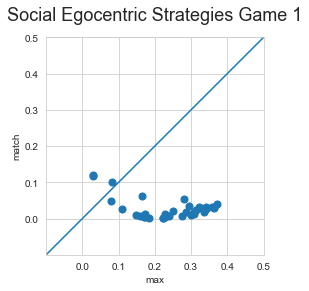

In [367]:
# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g1['max'], control_jsd_g1['match'], 1)

social_ego_jsd_g1_plot = social_jsd_g1.plot.scatter(x='max',y='match',s=50)
plt.title('Social Egocentric Strategies Game 1', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#add line of slope 1
plt.plot([0,1],[0,1], transform=plt.gca().transAxes)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('social_ego_jsd_1.jpeg',format='jpeg')
plt.show()

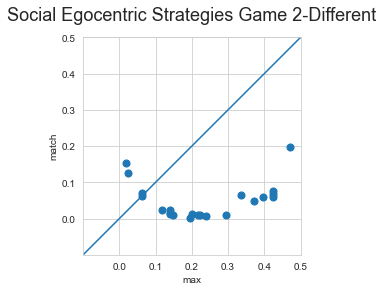

In [368]:
# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g1['max'], control_jsd_g1['match'], 1)

social_ego_jsd_g2d_plot = social_jsd_g2d.plot.scatter(x='max',y='match',s=50)
plt.title('Social Egocentric Strategies Game 2-Different', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#add line of slope 1
plt.plot([0,1],[0,1], transform=plt.gca().transAxes)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('social_ego_jsd_2d.jpeg',format='jpeg')
plt.show()

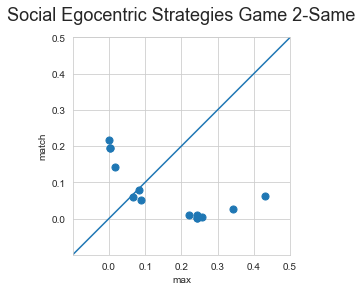

In [369]:
# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g1['max'], control_jsd_g1['match'], 1)

social_ego_jsd_g2s_plot = social_jsd_g2s.plot.scatter(x='max',y='match',s=50)
plt.title('Social Egocentric Strategies Game 2-Same', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#add line of slope 1
plt.plot([0,1],[0,1], transform=plt.gca().transAxes)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('social_ego_jsd_2s.jpeg',format='jpeg')
plt.show()

In [539]:
social_jsd_g2 = social_jsd_g2d.append(social_jsd_g2s)

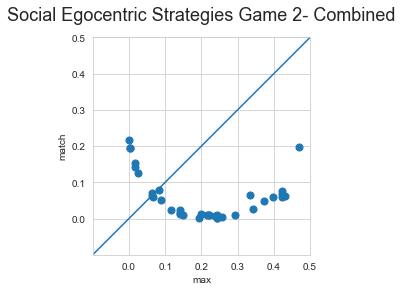

In [540]:
# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g1['max'], control_jsd_g1['match'], 1)

social_ego_jsd_g2_plot = social_jsd_g2.plot.scatter(x='max',y='match',s=50)
plt.title('Social Egocentric Strategies Game 2- Combined', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#add line of slope 1
plt.plot([0,1],[0,1], transform=plt.gca().transAxes)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('social_ego_jsd_2.jpeg',format='jpeg')
plt.show()

In [370]:
sp.stats.ttest_ind(social_jsd_g2s, social_jsd_g2d)

Ttest_indResult(statistic=array([-1.4434464 ,  1.13750872,  1.50364684,  1.50364684]), pvalue=array([0.1580461 , 0.26327869, 0.14190531, 0.14190531]))

In [537]:
sp.stats.ttest_ind(control_jsd_g1, social_jsd_g1)

Ttest_indResult(statistic=array([-0.17599541,  1.12332216,  1.27376401,  1.27376401]), pvalue=array([0.86085325, 0.26549684, 0.20735359, 0.20735359]))

In [538]:
sp.stats.ttest_ind(control_jsd_g2, social_jsd_g2)

Ttest_indResult(statistic=array([-0.67348294, -0.95444999, -0.39860311, -0.39860311]), pvalue=array([0.50306508, 0.34344713, 0.69151244, 0.69151244]))

In [541]:
sp.stats.ttest_rel(control_jsd_g1, control_jsd_g2)

Ttest_relResult(statistic=array([ 2.10376154, -0.25308948, -1.17099325, -1.17099325]), pvalue=array([0.04418727, 0.8019846 , 0.2511338 , 0.2511338 ]))

In [542]:
sp.stats.ttest_rel(social_jsd_g1, social_jsd_g2)

Ttest_relResult(statistic=array([ 1.29273176, -3.06394807, -3.18983759, -3.18983759]), pvalue=array([0.20457289, 0.00418681, 0.00299923, 0.00299923]))

In [371]:
social_jsd_g2['rand'].sum()

3.108216007357165

In [372]:
social_jsd_g2['max'].sum()

7.3058386901804555

In [373]:
social_jsd_g2['match'].sum()

2.179244290759528

In [374]:
social_jsd_g1['rand'].sum()

1.3779365041051364

In [375]:
social_jsd_g1['max'].sum()

8.5425238524054

In [376]:
social_jsd_g1['match'].sum()

1.0178395659534993

In [377]:
social_jsd_g1.mean()

max      0.237292
match    0.028273
rand     0.038276
soc      0.038276
dtype: float64

In [378]:
social_jsd_g2.mean()

max      0.202940
match    0.060535
rand     0.086339
soc      0.086339
dtype: float64

In [379]:
confed_g2_counts = confed_g2_s_counts_unmelt.append(confed_g2_d_counts_unmelt)

In [380]:
soc_g2_counts = soc_g2_s_counts_unmelt.append(soc_g2_d_counts_unmelt)

In [381]:
sp.stats.ttest_ind(confed_g1_counts_unmelt,confed_g2_counts)

Ttest_indResult(statistic=array([ 1.10286851,  1.04637312, -1.37065112]), pvalue=array([0.27434681, 0.29945113, 0.17542573]))

In [382]:
sp.stats.ttest_ind(soc_g2_s_counts_unmelt,soc_g2_d_counts_unmelt)

Ttest_indResult(statistic=array([-0.525891  , -1.22612629,  1.06036517]), pvalue=array([0.60237752, 0.22857579, 0.29645329]))

In [383]:
soc_g1_counts_unmelt.mean()

30.0    23.416667
60.0    28.638889
90.0    47.944444
dtype: float64

In [384]:
soc_g2_counts.mean()

30.0    16.861111
60.0    23.916667
90.0    59.222222
dtype: float64

In [385]:
sp.stats.ttest_ind(soc_g1_counts_unmelt,soc_g2_d_counts_unmelt)

Ttest_indResult(statistic=array([ 1.62076457,  0.63383836, -1.4413323 ]), pvalue=array([0.11068611, 0.52876688, 0.15505963]))

In [386]:
sp.stats.ttest_ind(soc_g1_counts_unmelt,soc_g2_s_counts_unmelt)

Ttest_indResult(statistic=array([ 1.98953229,  2.35139655, -2.48477115]), pvalue=array([0.05235664, 0.02285606, 0.01650266]))

In [387]:
sp.stats.ttest_ind(soc_g2_d_scores_unmelt, soc_g2_s_scores_unmelt)

Ttest_indResult(statistic=array([-0.87835205]), pvalue=array([0.38591794]))

In [388]:
sp.stats.ttest_ind(soc_g1_score['value'], soc_g2_s_scores_unmelt)

Ttest_indResult(statistic=array([-2.06330191]), pvalue=array([0.04451474]))

In [389]:
sp.stats.ttest_ind(soc_g1_score['value'], soc_g2_d_scores_unmelt)

Ttest_indResult(statistic=array([-1.38738302]), pvalue=array([0.17082175]))

In [390]:
soc_g2_scores = soc_g2_d_scores_unmelt.append(soc_g2_s_scores_unmelt)

In [391]:
sp.stats.ttest_ind(soc_g1_score['value'],soc_g2_scores)

Ttest_indResult(statistic=array([-2.04817388]), pvalue=array([0.04429538]))

In [392]:
sp.stats.ttest_ind(confed_g2_d_scores_unmelt, confed_g2_s_scores_unmelt)

Ttest_indResult(statistic=array([0.18499796]), pvalue=array([0.85451838]))

In [393]:
confed_g2_scores = confed_g2_d_scores_unmelt.append(confed_g2_s_scores_unmelt)

In [394]:
sp.stats.ttest_ind(confed_g1_score['value'], confed_g2_scores)

Ttest_indResult(statistic=array([-1.0429906]), pvalue=array([0.30106861]))

In [395]:
sp.stats.ttest_ind(confed_g1_score['value'], soc_g1_score['value'])

Ttest_indResult(statistic=0.8839368139635342, pvalue=0.3799390222581692)

In [396]:
sp.stats.ttest_ind(confed_g2_scores, soc_g2_scores)

Ttest_indResult(statistic=array([0.01441627]), pvalue=array([0.98854204]))

# Plotting combined g2 data

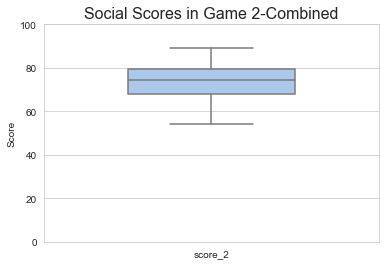

In [397]:
soc_g2_scores_box = sns.boxplot( 
                 data=soc_g2_scores,
                 width=0.5,
                 palette="pastel")
soc_g2_scores_box.axes.set_title("Social Scores in Game 2-Combined",
                    fontsize=16)

plot_file_name="soc_g2_combo_scores_box.jpg"
 
plt.ylim(0, 100)
soc_g2_scores_box.axes.set(ylabel='Score')

# save as jpeg
soc_g2_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

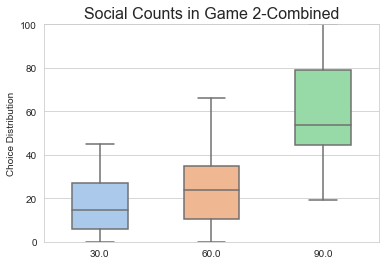

In [398]:
soc_g2_counts_box = sns.boxplot( 
                 data=soc_g2_counts,
                 width=0.5,
                 palette="pastel")
soc_g2_counts_box.axes.set_title("Social Counts in Game 2-Combined",
                    fontsize=16)

plot_file_name="soc_g2_combo_combo_box.jpg"
 
plt.ylim(0, 100)
soc_g2_counts_box.axes.set(ylabel='Choice Distribution')

# save as jpeg
soc_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [399]:
social_jsd_g2 = social_jsd_g2d.append(social_jsd_g2s)

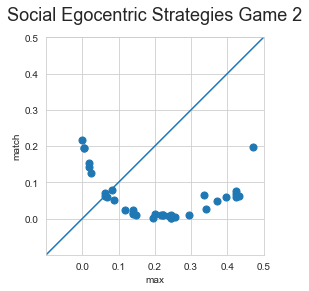

In [400]:
social_ego_jsd_g2_plot = social_jsd_g2.plot.scatter(x='max',y='match',s=50)
plt.title('Social Egocentric Strategies Game 2', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#add line of slope 1
plt.plot([0,1],[0,1], transform=plt.gca().transAxes)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('social_ego_jsd_2.jpeg',format='jpeg')
plt.show()

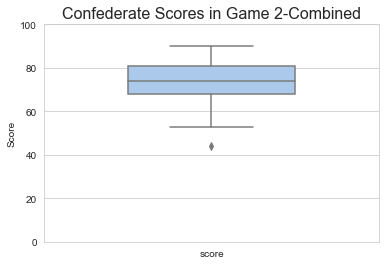

In [401]:
confed_g2_scores_box = sns.boxplot( 
                 data=confed_g2_scores,
                 width=0.5,
                 palette="pastel")
confed_g2_scores_box.axes.set_title("Confederate Scores in Game 2-Combined",
                    fontsize=16)

plot_file_name="confed_g2_combo_scores_box.jpg"
 
plt.ylim(0, 100)
confed_g2_scores_box.axes.set(ylabel='Score')

# save as jpeg
confed_g2_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

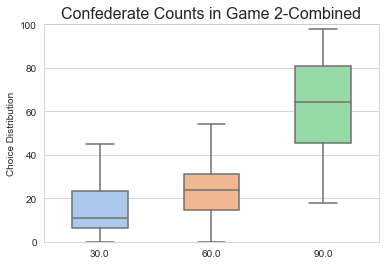

In [402]:
confed_g2_counts_box = sns.boxplot( 
                 data=confed_g2_counts,
                 width=0.5,
                 palette="pastel")
confed_g2_counts_box.axes.set_title("Confederate Counts in Game 2-Combined",
                    fontsize=16)

plot_file_name="confed_g2_combo_combo_box.jpg"
 
plt.ylim(0, 100)
confed_g2_counts_box.axes.set(ylabel='Choice Distribution')

# save as jpeg
confed_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [403]:
#confed_jsd_g2 = confed_jsd_g2_d.append(confed_jsd_g2_s)

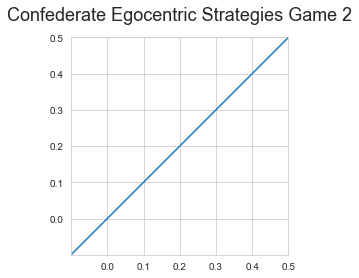

In [404]:
#confed_ego_jsd_g2_plot = confed_jsd_g2.plot.scatter(x='max',y='match',s=50)
plt.title('Confederate Egocentric Strategies Game 2', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#add line of slope 1
plt.plot([0,1],[0,1], transform=plt.gca().transAxes)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('confed_ego_jsd_2.jpeg',format='jpeg')
plt.show()

# Splitting the data into three blocks 

In [405]:
'''This function splits dataframes contained in a dictionary into separate dataframes that each contain 30 trials.
The first ten trials of a session are removed.
input: dictionary containing dataframes split by player and game
output: dictionary with the dataframes with separate blocks added and dictionary with just blocked data'''
def create_blocks (dicti):
    
    all_blocks = {}

    length = len(dicti)

    i = 0
    
    while i < length:
        key = get_nth_key(dicti, n=i)

        df = pd.DataFrame(dicti[key]).reset_index(drop=True)

        #edit these numbers if you want 
        blocks = [df[0:10], df[10:40], df[40:70], df[70:100]]
        block_names = [key + '_b0', key + '_b1', key + '_b2', key + '_b3']
        blocks = dict(zip(block_names, blocks))


        i = i + 1
    
        all_blocks.update(blocks)
        
    dicti.update(all_blocks)
        
    return dicti, all_blocks

In [406]:
def get_nth_key(dictionary, n=0):
    if n < 0:
        n += len(dictionary)
    for i, key in enumerate(dictionary.keys()):
        if i == n:
            return key
    raise IndexError("dictionary index out of range") 

In [407]:
def get_weight(df, val, dec):
    
    try:
        weight = df.loc[df['probability'] == val, 'count_column'].iloc[0] *  dec
        
    #this will raise an error when that hole was chosen 0 times in the block
    except IndexError: 
        weight = 0
        
    return weight

In [408]:
'''This function creates a dataframe that contains the average choice distribution and weighted average of the choice
distribution for all of the dataframes contained in the dictionary that is inputted.
input: dictionary containing dataframes separated by game and player number and separated into 4 blocks using the 
create blocks function. 
output: the dictionary with the count_column added to each dataframe (NOT currently);
a dataframe containing the weighted average of the choice distribution of each block'''
def choice_dist_and_avg (dicti):
    
    index = []
    avgs = []

    length = len(dicti)

    i = 0
    
    while i < length:
        key = get_nth_key(dicti, n=i)
        
        df = pd.DataFrame(dicti[key]).reset_index(drop=True)
        
        index.append(key)
        
        count = df['probability'].value_counts()
        
        #convert to dictionary
        count_dict = count.to_dict()
        
        #add count column to df
        df['count_column'] = df['probability'].map(count_dict)
        
        dicti[key] = df
        
        low = get_weight(df, 30.0, 0.30)
        med = get_weight(df, 60.0, 0.60)
        high = get_weight(df, 90.0, 0.90)
            
        avg = low + med + high
        
        avgs.append(avg)
        
        i = i + 1
        
    avgs_df_melt = pd.DataFrame({'avg': avgs}, index = index)
    
    avgs_df = unmelt_avg_df(avgs_df_melt)
    
    
    return dicti, avgs_df_melt, avgs_df

In [409]:
'''This function unmelts the avgs dataframe so that there is 1 column row subject and 1 column per block.'''
#add column to counts indicating whether it's game 1 or 2
def unmelt_avg_df (df):
    subjects = df.index.to_numpy()

    b0 = np.array([])
    b1 = np.array([])
    b2 = np.array([])
    b3 = np.array([])
    new_subjects = np.array([])

    ii = 1;
    for i in subjects:
        if [i][0][11] == '0':
            b0 = np.append(b0,df.loc[i])
        elif [i][0][11] == '1':
            b1 = np.append(b1,df.loc[i])
        elif [i][0][11] == '2':
            b2 = np.append(b2,df.loc[i])
        elif [i][0][11] == '3':
            b3 = np.append(b3,df.loc[i])
            
        #create new array for subjects with every 4th element from the subjects array
        if ii % 4 == 0:
            #remove last 3 characters from subject (ex. '_b0')
            new_subjects = np.append(new_subjects, i[:-3])
        ii = ii + 1;

    df_new = pd.DataFrame({'participant': new_subjects, 'b0': b0, 'b1': b1, 'b2': b2, 'b3': b3})

    return df_new

In [434]:
#create a list of the dataframes
soc_g1 = [m01_p1_g1, m01_p2_g1, m03_p1_g1, m03_p2_g1, m05_p1_g1, m05_p2_g1, m08_p1_g1, m08_p2_g1, m10_p1_g1,
         m10_p2_g1, m11_p1_g1, m11_p2_g1, m13_p1_g1, m13_p2_g1, m14_p1_g1, m14_p2_g1, j01_p1_g1, j01_p2_g1, j02_p1_g1, 
         j03_p1_g1, j03_p2_g1, j05_p1_g1, j05_p2_g1, j06_p1_g1, j06_p2_g1, j07_p1_g1, j07_p2_g1, j08_p1_g1, j08_p2_g1,
         j10_p1_g1, j10_p2_g1, j11_p1_g1, j11_p2_g1]

#convert list to dictionary so dataframes can be accessed by their name
soc_g1 = {"{}".format(get_df_name(df)): dict(df) for i, df in enumerate(soc_g1, start=1)}

#call function to split df's into 3 blocks 
soc_g1, soc_g1_blocks = create_blocks(soc_g1)

#call function to calculate choice distributions and weighted avgs
soc_g1_blocks, soc_g1_blocks_avgs_melt, soc_g1_blocks_avgs = choice_dist_and_avg(soc_g1_blocks)

In [435]:
soc_g1_blocks_avgs.set_index('participant', inplace=True, drop=True)

In [436]:
soc_g1_blocks_avgs

,b0,b1,b2,b3
participant,,,,
m01_p1_g1,6.6,17.1,18.0,17.1
m01_p2_g1,6.9,18.0,19.8,17.1
m03_p1_g1,6.0,19.8,17.4,18.9
m03_p2_g1,6.3,18.6,17.7,18.3
m05_p1_g1,6.0,23.4,23.1,23.1
m05_p2_g1,6.6,23.1,22.8,20.4
m08_p1_g1,6.6,20.7,23.4,23.7
m08_p2_g1,5.7,20.4,23.1,25.8
m10_p1_g1,6.3,18.6,21.6,21.9


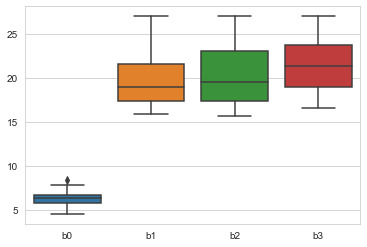

In [437]:
sns.boxplot(data=soc_g1_blocks_avgs)

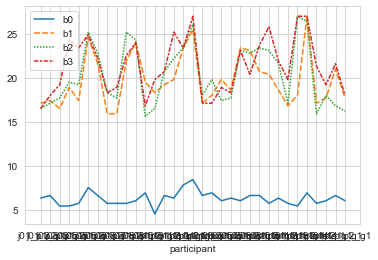

In [414]:
sns.lineplot(data=soc_g1_blocks_avgs)

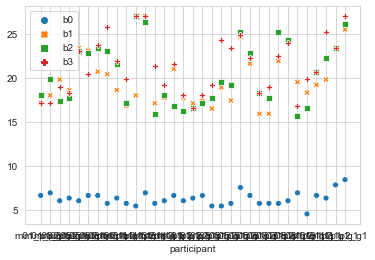

In [415]:
sns.scatterplot(data=soc_g1_blocks_avgs)

In [433]:
soc_g1_blocks_avgs_trans = soc_g1_blocks_avgs.transpose()

In [417]:
soc_g1_blocks_avgs

participant,m01_p1_g1,m01_p2_g1,m03_p1_g1,m03_p2_g1,m05_p1_g1,m05_p2_g1,m08_p1_g1,m08_p2_g1,m10_p1_g1,m10_p2_g1,m11_p1_g1,m11_p2_g1,m13_p1_g1,m13_p2_g1,m14_p1_g1,m14_p2_g1,j01_p1_g1,j01_p2_g1,j02_p1_g1,j03_p1_g1,j03_p2_g1,j05_p1_g1,j05_p2_g1,j06_p1_g1,j06_p2_g1,j07_p1_g1,j07_p2_g1,j08_p1_g1,j08_p2_g1,j10_p1_g1,j10_p2_g1,j11_p1_g1,j11_p2_g1
b0,6.6,6.9,6.0,6.3,6.0,6.6,6.6,5.7,6.3,5.7,5.4,6.9,5.7,6.0,6.6,6.0,6.3,6.6,5.4,5.4,5.7,7.5,6.6,5.7,5.7,5.7,6.0,6.9,4.5,6.6,6.3,7.8,8.4
b1,17.1,18.0,19.8,18.6,23.4,23.1,20.7,20.4,18.6,16.8,18.0,27.0,17.1,17.7,21.0,17.7,17.1,17.4,16.5,18.9,17.4,24.6,21.6,15.9,15.9,21.9,24.0,19.5,18.3,19.2,19.8,23.4,25.5
b2,18.0,19.8,17.4,17.7,23.1,22.8,23.4,23.1,21.6,17.1,27.0,26.4,15.9,18.0,16.8,16.2,16.5,17.1,17.7,19.5,19.2,25.2,22.8,18.3,17.7,25.2,24.3,15.6,16.5,20.7,22.2,23.4,26.1
b3,17.1,17.1,18.9,18.3,23.1,20.4,23.7,25.8,21.9,19.8,27.0,27.0,21.3,19.2,21.6,18.0,16.5,18.0,19.2,24.3,23.4,24.9,22.2,18.3,18.9,22.5,24.0,16.8,19.8,20.7,25.2,23.4,27.0


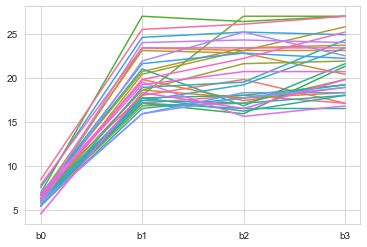

In [418]:
sns.lineplot(data=soc_g1_blocks_avgs_trans, dashes=False, legend = False)
#legend blocking data

In [445]:
#repeat for soc_g2, confed_g1, and confed_g2
#create a list of the dataframes
soc_g2 = [m01_p1_g2, m01_p2_g2, m03_p1_g2, m03_p2_g2, m05_p1_g2, m05_p2_g2, m08_p1_g2, m08_p2_g2, m10_p1_g2,
         m10_p2_g2, m11_p1_g2, m11_p2_g2, m13_p1_g2, m13_p2_g2, m14_p1_g2, m14_p2_g2, j01_p1_g2, j01_p2_g2, j02_p1_g2, 
         j03_p1_g2, j03_p2_g2, j05_p1_g2, j05_p2_g2, j06_p1_g2, j06_p2_g2, j07_p1_g2, j07_p2_g2, j08_p1_g2, j08_p2_g2,
         j10_p1_g2, j10_p2_g2, j11_p1_g2, j11_p2_g2]

#convert list to dictionary so dataframes can be accessed by their name
soc_g2 = {"{}".format(get_df_name(df)): dict(df) for i, df in enumerate(soc_g2, start=1)}

#call function to split df's into 3 blocks 
soc_g2, soc_g2_blocks = create_blocks(soc_g2)

#call function to calculate choice distributions and weighted avgs
soc_g2_blocks, soc_g2_blocks_avgs_melt, soc_g2_blocks_avgs = choice_dist_and_avg(soc_g2_blocks)

In [444]:
soc_g2_blocks_avgs

,b0,b1,b2,b3
participant,,,,
m01_p1_g2,6.3,21.9,27.0,23.4
m01_p2_g2,5.7,21.9,16.8,21.0
m03_p1_g2,5.1,16.5,16.8,17.4
m03_p2_g2,6.0,17.1,15.3,17.7
m05_p1_g2,6.9,19.2,22.8,19.5
m05_p2_g2,9.0,26.4,27.0,24.6
m08_p1_g2,6.0,25.2,25.5,26.4
m08_p2_g2,8.1,27.0,26.1,27.0
m10_p1_g2,6.0,17.7,20.4,21.0


In [529]:
soc_g2_blocks_avgs.set_index('participant', inplace=True, drop=True)
soc_g2_blocks_avgs_trans = soc_g2_blocks_avgs.transpose()

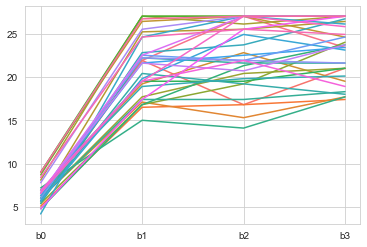

In [440]:
sns.lineplot(data=soc_g2_blocks_avgs_trans, dashes=False, legend = False)

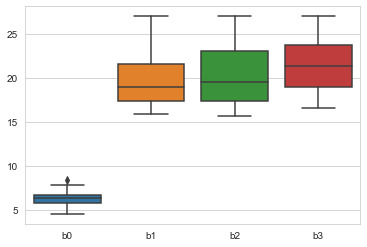

In [441]:
sns.boxplot(data=soc_g1_blocks_avgs)

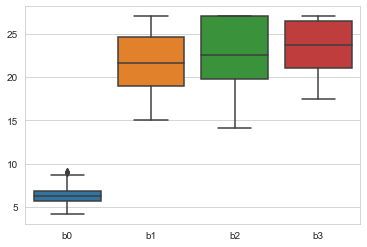

In [442]:
sns.boxplot(data=soc_g2_blocks_avgs)

In [446]:
confed_g1_counts

,variable,value
c01_p1_g1_count,30.0,23
c02_p1_g1_count,30.0,13
c03_p1_g1_count,30.0,12
c04_p1_g1_count,30.0,8
c05_p1_g1_count,30.0,34
c06_p1_g1_count,30.0,29
c07_p1_g1_count,30.0,12
c09_p1_g1_count,30.0,28
c10_p1_g1_count,30.0,9
c11_p1_g1_count,30.0,19


In [514]:
#repeat for soc_g2, confed_g1, and confed_g2
#create a list of the dataframes
confed_g1 = [c01_p1_g1, c02_p1_g1, c03_p1_g1, c05_p1_g1, c06_p1_g1, c07_p1_g1, c09_p1_g1, c10_p1_g1, 
             c11_p1_g1, c12_p1_g1, c13_p1_g1, c14_p1_g1, c15_p1_g1, c16_p1_g1, c17_p1_g1, c18_p1_g1, s01_p1_g1, 
             s03_p1_g1, s05_p1_g1, s06_p1_g1, s07_p1_g1, s08_p1_g1, s09_p1_g1, s11_p1_g1, s12_p1_g1, s14_p1_g1, 
             s15_p1_g1, s16_p1_g1, s17_p1_g1, s19_p1_g1, s20_p1_g1]

#convert list to dictionary so dataframes can be accessed by their name
confed_g1 = {"{}".format(get_df_name(df)): dict(df) for i, df in enumerate(confed_g1, start=1)}

#call function to split df's into 3 blocks 
confed_g1, confed_g1_blocks = create_blocks(confed_g1)

#call function to calculate choice distributions and weighted avgs
confed_g1_blocks, confed_g1_blocks_avgs_melt, confed_g1_blocks_avgs = choice_dist_and_avg(confed_g1_blocks)

In [515]:
confed_g1_blocks_avgs

,participant,b0,b1,b2,b3
0,c01_p1_g1,6.6,18.3,19.2,21.9
1,c02_p1_g1,5.4,18.9,24.6,20.1
2,c03_p1_g1,5.4,24.0,25.2,27.0
3,c05_p1_g1,6.3,18.3,18.0,17.7
4,c06_p1_g1,5.7,20.7,20.4,17.1
5,c07_p1_g1,6.9,18.9,25.2,25.2
6,c09_p1_g1,6.0,18.0,18.0,17.1
7,c10_p1_g1,6.3,21.3,26.1,27.0
8,c11_p1_g1,5.7,18.6,21.6,21.3
9,c12_p1_g1,5.4,16.5,16.5,17.7


In [516]:
confed_g1_blocks_avgs.set_index('participant', inplace=True, drop=True)
confed_g1_blocks_avgs_trans = confed_g1_blocks_avgs.transpose()

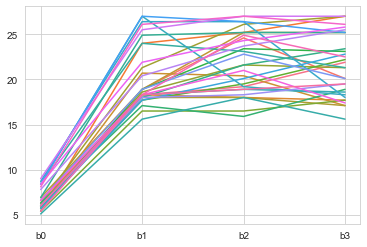

In [517]:
sns.lineplot(data=confed_g1_blocks_avgs_trans, dashes=False, legend = False)

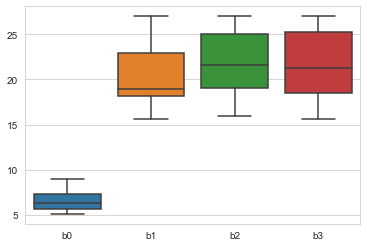

In [518]:
sns.boxplot(data=confed_g1_blocks_avgs)

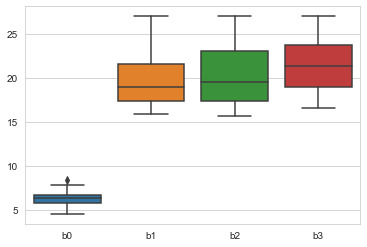

In [519]:
sns.boxplot(data=soc_g1_blocks_avgs)

In [520]:
sp.stats.ttest_ind(soc_g1_blocks_avgs, confed_g1_blocks_avgs)

Ttest_indResult(statistic=array([-1.4945105 , -0.78649671, -1.82491167, -0.21397261]), pvalue=array([0.14011474, 0.43457247, 0.07283263, 0.83127056]))

In [521]:
#repeat for soc_g2, confed_g1, and confed_g2
#create a list of the dataframes
confed_g2 = [c01_p1_g2, c02_p1_g2, c03_p1_g2, c05_p1_g2, c06_p1_g2, c07_p1_g2, c09_p1_g2, c10_p1_g2, 
             c11_p1_g2, c12_p1_g2, c13_p1_g2, c14_p1_g2, c15_p1_g2, c16_p1_g2, c17_p1_g2, c18_p1_g2, s01_p1_g2, 
             s03_p1_g2, s05_p1_g2, s06_p1_g2, s07_p1_g2, s08_p1_g2, s09_p1_g2, s11_p1_g2, s12_p1_g2, s14_p1_g2, 
             s15_p1_g2, s16_p1_g2, s17_p1_g2, s19_p1_g2, s20_p1_g2]

#convert list to dictionary so dataframes can be accessed by their name
confed_g2 = {"{}".format(get_df_name(df)): dict(df) for i, df in enumerate(confed_g2, start=1)}

#call function to split df's into 3 blocks 
confed_g2, confed_g2_blocks = create_blocks(confed_g2)

#call function to calculate choice distributions and weighted avgs
confed_g2_blocks, confed_g2_blocks_avgs_melt, confed_g2_blocks_avgs = choice_dist_and_avg(confed_g2_blocks)

In [522]:
confed_g2_blocks_avgs.set_index('participant', inplace=True, drop=True)
confed_g2_blocks_avgs_trans = confed_g2_blocks_avgs.transpose()

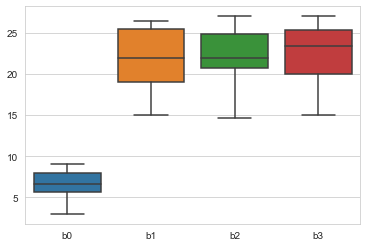

In [523]:
sns.boxplot(data=confed_g2_blocks_avgs)

In [525]:
#largest difference in block 1
sp.stats.ttest_rel(confed_g1_blocks_avgs, confed_g2_blocks_avgs)

Ttest_relResult(statistic=array([-0.28539568, -3.15028562, -0.84063556, -1.77288247]), pvalue=array([0.77730224, 0.00367997, 0.40720254, 0.0864031 ]))

In [530]:
sp.stats.ttest_rel(soc_g1_blocks_avgs, soc_g2_blocks_avgs)

Ttest_relResult(statistic=array([-1.41960106, -2.50905862, -3.70879471, -3.17273968]), pvalue=array([0.1653928 , 0.01736363, 0.00078764, 0.00332532]))

In [532]:
sp.stats.ttest_ind(confed_g1_blocks_avgs, soc_g1_blocks_avgs)

Ttest_indResult(statistic=array([1.4945105 , 0.78649671, 1.82491167, 0.21397261]), pvalue=array([0.14011474, 0.43457247, 0.07283263, 0.83127056]))

In [533]:
sp.stats.ttest_ind(confed_g2_blocks_avgs, soc_g2_blocks_avgs)

Ttest_indResult(statistic=array([ 0.44290037,  0.69887072, -0.27936287, -0.57996822]), pvalue=array([0.65937929, 0.48724626, 0.78089618, 0.56403785]))

In [543]:
#greater difference b/w g1 and g2 in social condition than control condition

In [544]:
#BUT interaction is not significant in ANOVA

In [559]:
confed_avgs = confed_g1_blocks_avgs.append(confed_g2_blocks_avgs)
soc_avgs = soc_g1_blocks_avgs.append(soc_g2_blocks_avgs)
avgs = confed_avgs.append(soc_avgs)

In [560]:
avgs = avgs.melt(ignore_index=False)

In [561]:
#ANOVA for blocks, games, by condition
#add column to counts indicating whether it's game 1 or 2

#NEED: convert to function

subjects = avgs.index.to_numpy()

game = np.array([])

for i in subjects:
    if [i][0][8] == '1':
        game = np.append(game,1)
    elif [i][0][8] == '2':
        game = np.append(game,2)
        
avgs['game'] = game
    
#add participant column with subject code 
participant = np.array([])

for i in subjects:
    participant = np.append(participant, [i][0][0:6])
    
avgs['participant'] = participant

condition = np.array([])

for i in subjects:
    if [i][0][0] == 's' or [i][0][0] == 'c':
        condition = np.append(condition,'control')
    elif [i][0][0] == 'm' or [i][0][0] == 'j':
        condition = np.append(condition,'social')

avgs['condition'] = condition

experiment = np.array([])

for i in subjects:
    if [i][0][0] == 'j' or [i][0][0] == 's':
        experiment = np.append(experiment,3)
    elif [i][0][0] == 'm' or [i][0][0] == 'c':
        experiment = np.append(experiment,4)
        
avgs['experiment'] = experiment

In [571]:
avgs = avgs.reset_index(drop=True)

In [590]:
#break up df by block
avgs_b1 = avgs.loc[avgs.variable=='b1']
avgs_b1 = avgs_b1.reset_index()

#break up df by block
avgs_b2 = avgs.loc[avgs.variable=='b2']
avgs_b2 = avgs_b2.reset_index()

#break up df by block
avgs_b3 = avgs.loc[avgs.variable=='b3']
avgs_b3 = avgs_b3.reset_index()

In [586]:
pg.mixed_anova(data=avgs_b1, dv='value', between='condition', within='game', subject='participant')

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,12.467294,1,62,12.467294,0.715006,0.401039,1.140087e-02,NaN
1,game,81.760078,1,62,81.760078,15.169080,0.000243,1.965694e-01,1.0
2,Interaction,0.000083,1,62,0.000083,0.000015,0.996878,2.488676e-07,NaN


In [589]:
pg.mixed_anova(data=avgs_b2, dv='value', between='condition', within='game', subject='participant')

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,14.004900,1,62,14.004900,0.714105,0.401334,0.011387,NaN
1,game,61.605000,1,62,61.605000,11.621070,0.001151,0.157850,1.0
2,Interaction,26.693886,1,62,26.693886,5.035492,0.028413,0.075117,NaN


In [591]:
pg.mixed_anova(data=avgs_b3, dv='value', between='condition', within='game', subject='participant')

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,0.831653,1,62,0.831653,0.046816,0.829410,0.000755,NaN
1,game,64.980000,1,62,64.980000,12.128222,0.000916,0.163611,1.0
2,Interaction,3.699413,1,62,3.699413,0.690479,0.409190,0.011014,NaN


In [593]:
#significant interaction in b2
#may be reduced bc there is more information on hole 60

In [594]:
confed_g1_blocks_avgs.mean()

b0     6.619355
b1    20.380645
b2    21.948387
b3    21.551613
dtype: float64

In [595]:
soc_g1_blocks_avgs.mean()

b0     6.254545
b1    19.754545
b2    20.372727
b3    21.372727
dtype: float64

In [597]:
confed_g2_blocks_avgs.mean()

b0     6.706452
b1    21.977419
b2    22.393548
b3    22.625806
dtype: float64

In [596]:
soc_g2_blocks_avgs.mean()

b0     6.554545
b1    21.354545
b2    22.645455
b3    23.127273
dtype: float64

In [599]:
#learn to ignore participant's choices in g2

In [598]:
#check that subjects are above chance ?